In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
scorelist = []

In [4]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    scorelist.append(np.mean(scores))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## mpg数据集实验

In [5]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('mpg')

### 基学习器的训练

#### support vector regression

In [6]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:38:55 2019
Fold 1 started at Tue Dec 17 10:38:55 2019
Fold 2 started at Tue Dec 17 10:38:55 2019
Fold 3 started at Tue Dec 17 10:38:55 2019
Fold 4 started at Tue Dec 17 10:38:55 2019
Fold 5 started at Tue Dec 17 10:38:55 2019
Fold 6 started at Tue Dec 17 10:38:55 2019
Fold 7 started at Tue Dec 17 10:38:55 2019
Fold 8 started at Tue Dec 17 10:38:55 2019
Fold 9 started at Tue Dec 17 10:38:55 2019
CV mean score: 7.8100, std: 0.6673.


#### lightgbm

Fold 0 started at Tue Dec 17 10:38:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.57388	valid_1's rmse: 2.08215
Early stopping, best iteration is:
[1044]	training's rmse: 1.54872	valid_1's rmse: 2.07603
Fold 1 started at Tue Dec 17 10:38:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[750]	training's rmse: 1.72413	valid_1's rmse: 2.60837
Fold 2 started at Tue Dec 17 10:38:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34621	valid_1's rmse: 2.73216
Fold 3 started at Tue Dec 17 10:38:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.51796	valid_1's rmse: 2.73624
Early stopping, best iteration is:
[934]	training's rmse: 1.55771	valid_1's rmse: 2.72658
Fold 4 started at Tue Dec 17 10:39:00 2019
Training until validation scores don't improve for 200 round

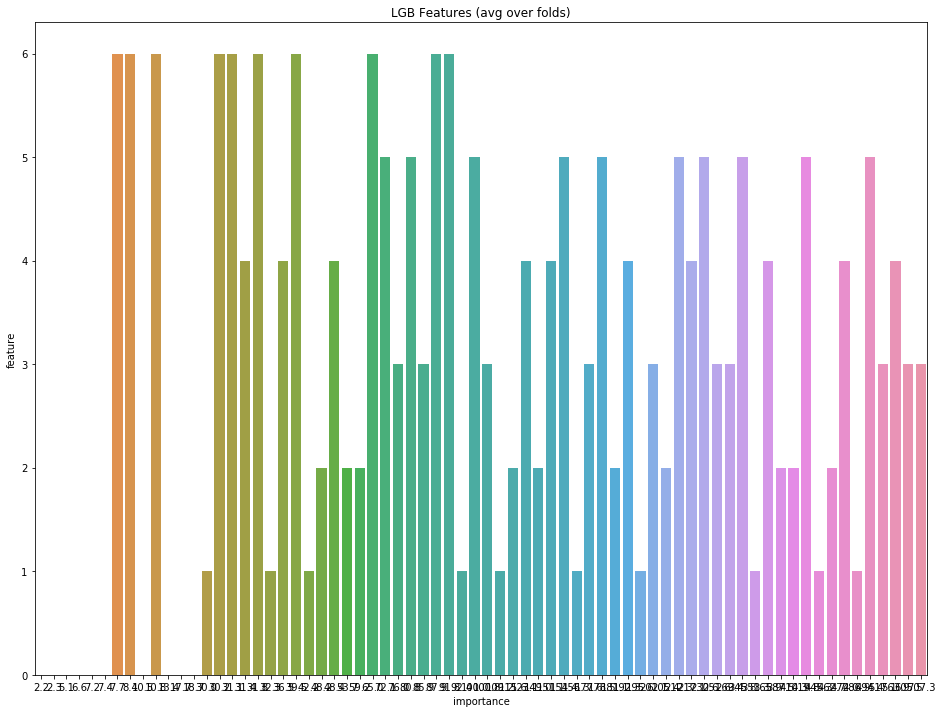

In [7]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:39:09 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.67748	valid_1's rmse: 2.06332
Early stopping, best iteration is:
[1005]	training's rmse: 1.67462	valid_1's rmse: 2.06129
Fold 1 started at Tue Dec 17 10:39:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.65909	valid_1's rmse: 2.61406
Early stopping, best iteration is:
[1497]	training's rmse: 1.44379	valid_1's rmse: 2.59095
Fold 2 started at Tue Dec 17 10:39:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34906	valid_1's rmse: 2.7348
Fold 3 started at Tue Dec 17 10:39:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.62375	valid_1's rmse: 2.7582
Early stopping, best iteration is:
[821]	training's rmse: 1.72261	valid_1's rmse: 2.74796
Fold 4 started at Tue Dec 17 10:39:26 2019
Train

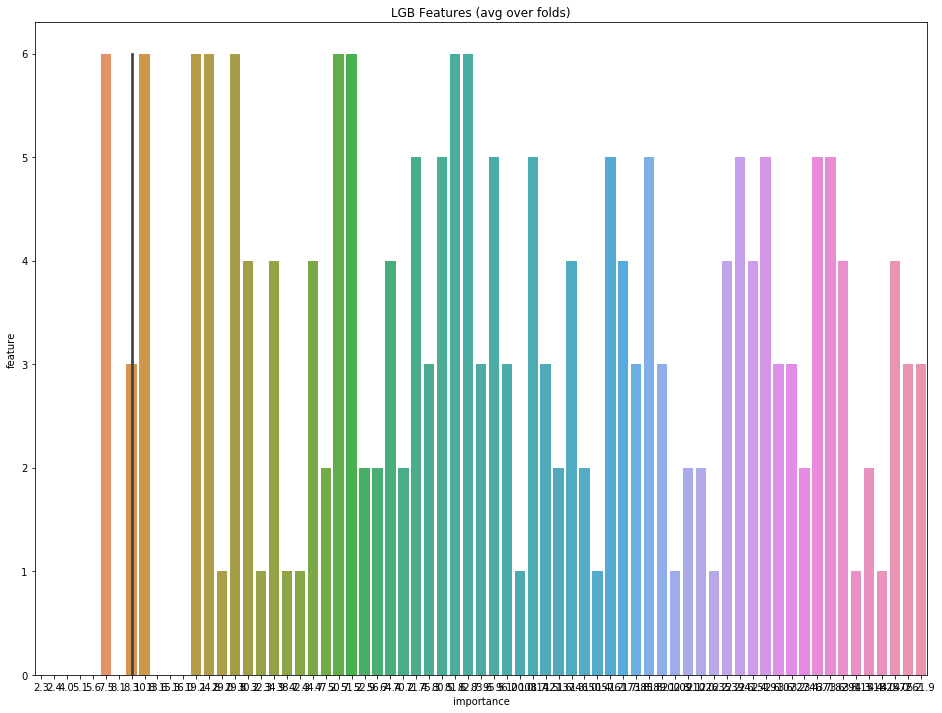

In [8]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:39:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.67748	valid_1's rmse: 2.06332
Early stopping, best iteration is:
[1005]	training's rmse: 1.67462	valid_1's rmse: 2.06129
Fold 1 started at Tue Dec 17 10:39:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.65909	valid_1's rmse: 2.61406
Early stopping, best iteration is:
[1497]	training's rmse: 1.44379	valid_1's rmse: 2.59095
Fold 2 started at Tue Dec 17 10:39:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34906	valid_1's rmse: 2.7348
Fold 3 started at Tue Dec 17 10:39:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.62375	valid_1's rmse: 2.7582
Early stopping, best iteration is:
[821]	training's rmse: 1.72261	valid_1's rmse: 2.74796
Fold 4 started at Tue Dec 17 10:39:48 2019
Train

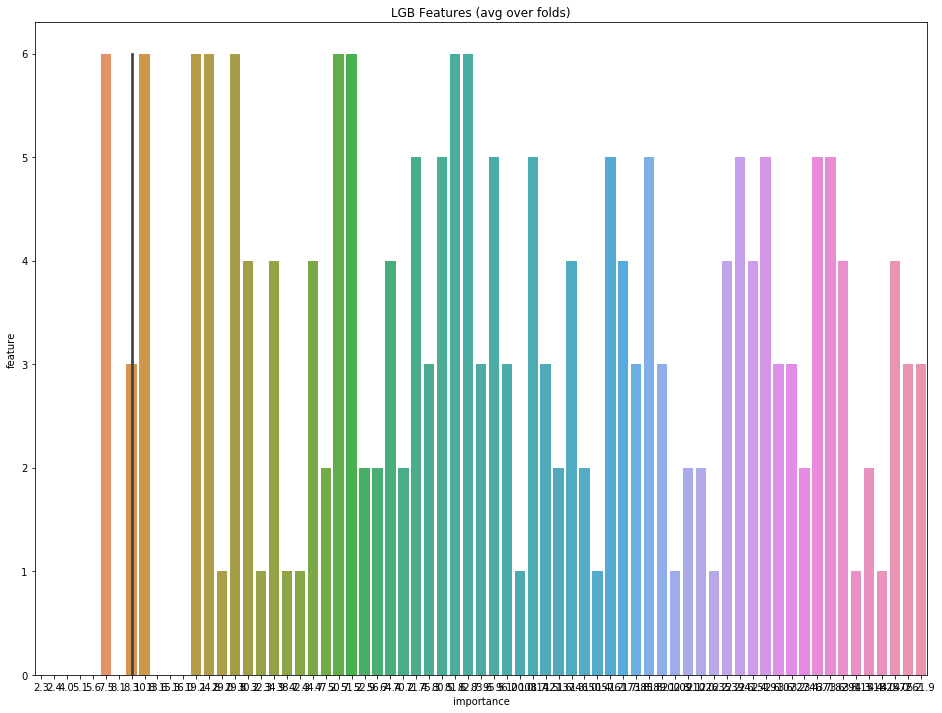

In [9]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [10]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:40:47 2019
Fold 1 started at Tue Dec 17 10:40:47 2019
Fold 2 started at Tue Dec 17 10:40:48 2019
Fold 3 started at Tue Dec 17 10:40:48 2019
Fold 4 started at Tue Dec 17 10:40:48 2019
Fold 5 started at Tue Dec 17 10:40:48 2019
Fold 6 started at Tue Dec 17 10:40:48 2019
Fold 7 started at Tue Dec 17 10:40:49 2019
Fold 8 started at Tue Dec 17 10:40:49 2019
Fold 9 started at Tue Dec 17 10:40:49 2019
CV mean score: 2.9381, std: 0.5400.


#### xgboost

In [11]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:40:49 2019
[0]	train-rmse:23.9882	valid_data-rmse:24.1119
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.9723	valid_data-rmse:2.2089
Stopping. Best iteration:
[701]	train-rmse:0.607195	valid_data-rmse:2.18604

Fold 1 started at Tue Dec 17 10:40:50 2019
[0]	train-rmse:24.1986	valid_data-rmse:22.168
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.970502	valid_data-rmse:2.25273
Stopping. Best iteration:
[584]	train-rmse:0.77059	valid_data-rmse:2.23718

Fold 2 started at Tue Dec 17 10:40:50 2019
[0]	train-rmse:24.0152	valid_data-rmse:23.8663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### catboost

In [12]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 10:40:59 2019
Fold 1 started at Tue Dec 17 10:41:06 2019
Fold 2 started at Tue Dec 17 10:41:33 2019
Fold 3 started at Tue Dec 17 10:41:36 2019
Fold 4 started at Tue Dec 17 10:41:42 2019
Fold 5 started at Tue Dec 17 10:41:51 2019
Fold 6 started at Tue Dec 17 10:42:11 2019
Fold 7 started at Tue Dec 17 10:42:46 2019
Fold 8 started at Tue Dec 17 10:42:56 2019
Fold 9 started at Tue Dec 17 10:43:09 2019
CV mean score: 2.6264, std: 0.3991.


### stacking

#### 所有结果均用于做stacking

In [13]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:43:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[547]	training's rmse: 2.10514	valid_1's rmse: 2.28102
Fold 1 started at Tue Dec 17 10:43:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 2.41124	valid_1's rmse: 2.34913
Fold 2 started at Tue Dec 17 10:43:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.42679	valid_1's rmse: 2.76024
Fold 3 started at Tue Dec 17 10:43:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's rmse: 2.14736	valid_1's rmse: 2.63461
Fold 4 started at Tue Dec 17 10:43:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.09592	valid_1's rmse: 3.88172
Fold 5 started at Tu

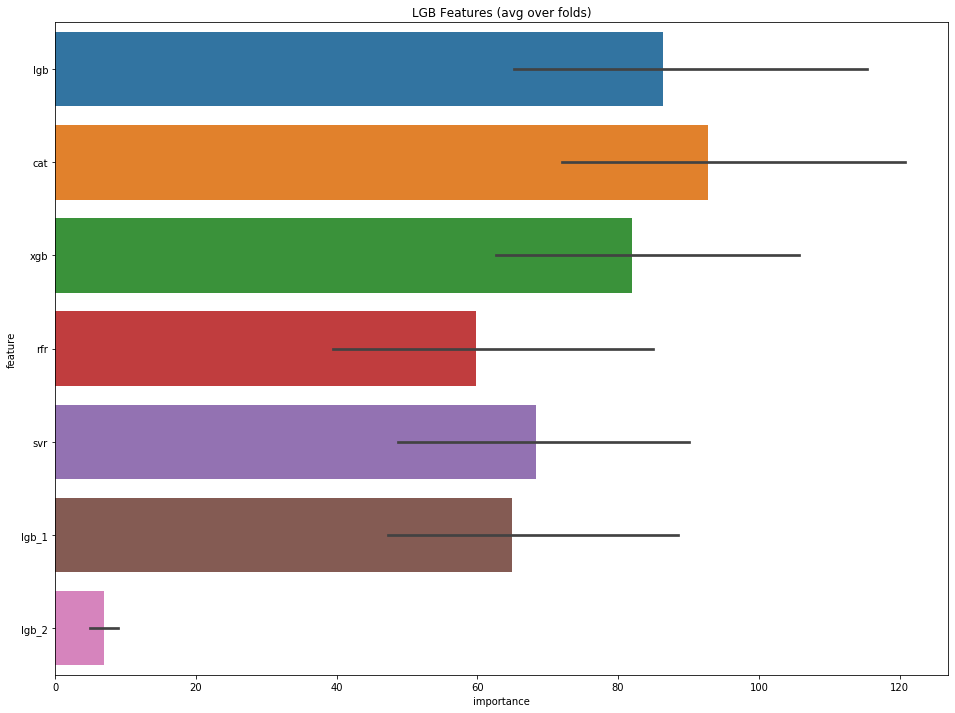

In [14]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 2.30297	valid_1's rmse: 2.25818
Fold 1 started at Tue Dec 17 10:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.46845	valid_1's rmse: 2.35737
Fold 2 started at Tue Dec 17 10:43:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[212]	training's rmse: 2.53804	valid_1's rmse: 2.76511
Fold 3 started at Tue Dec 17 10:43:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[492]	training's rmse: 2.25639	valid_1's rmse: 2.6044
Fold 4 started at Tue Dec 17 10:43:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[310]	training's rmse: 2.19963	valid_1's rmse: 3.93138
Fold 5 started at Tue

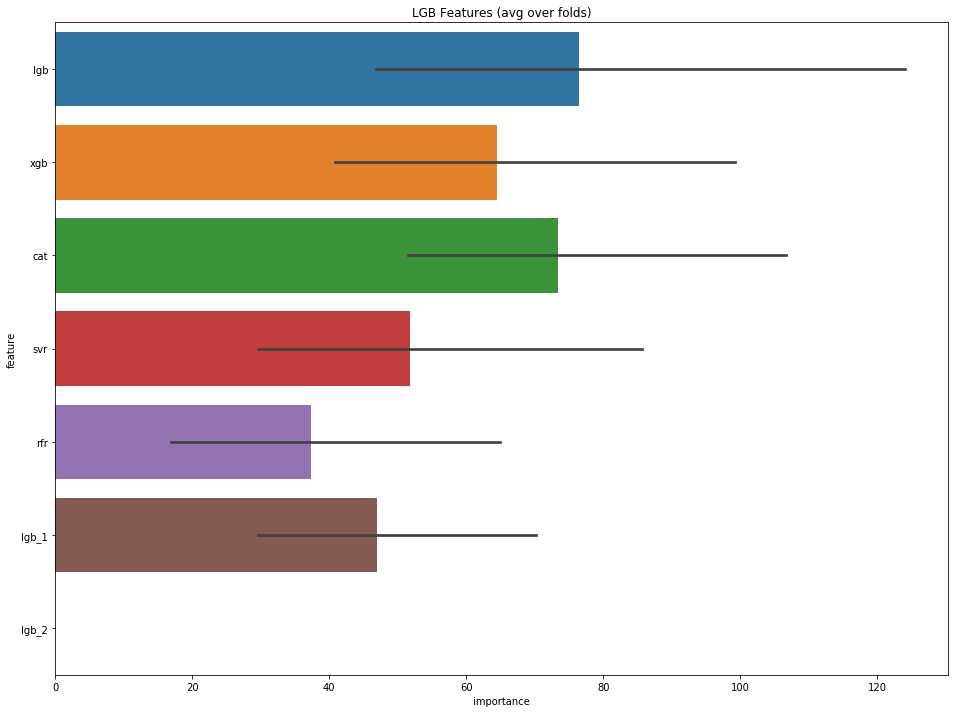

In [15]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [16]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:43:30 2019
Fold 1 started at Tue Dec 17 10:43:38 2019
Fold 2 started at Tue Dec 17 10:43:45 2019
Fold 3 started at Tue Dec 17 10:43:50 2019
Fold 4 started at Tue Dec 17 10:43:56 2019
Fold 5 started at Tue Dec 17 10:44:05 2019
Fold 6 started at Tue Dec 17 10:44:17 2019
Fold 7 started at Tue Dec 17 10:44:37 2019
Fold 8 started at Tue Dec 17 10:44:45 2019
Fold 9 started at Tue Dec 17 10:44:53 2019
CV mean score: 2.6858, std: 0.4865.


##### randomforest作为第二层融合模型

In [17]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:45:02 2019
Fold 1 started at Tue Dec 17 10:45:02 2019
Fold 2 started at Tue Dec 17 10:45:02 2019
Fold 3 started at Tue Dec 17 10:45:03 2019
Fold 4 started at Tue Dec 17 10:45:03 2019
Fold 5 started at Tue Dec 17 10:45:03 2019
Fold 6 started at Tue Dec 17 10:45:03 2019
Fold 7 started at Tue Dec 17 10:45:04 2019
Fold 8 started at Tue Dec 17 10:45:04 2019
Fold 9 started at Tue Dec 17 10:45:04 2019
CV mean score: 2.7807, std: 0.4810.


##### xgboost作为第二层融合模型

In [18]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:45:04 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20299	valid_data-rmse:2.3022
Stopping. Best iteration:
[469]	train-rmse:1.28658	valid_data-rmse:2.28795

Fold 1 started at Tue Dec 17 10:45:05 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.16579	valid_data-rmse:2.62877
Stopping. Best iteration:
[392]	train-rmse:1.53911	valid_data-rmse:2.60626

Fold 2 started at Tue Dec 17 10:45:05 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.867
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [19]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:45:09 2019
Fold 1 started at Tue Dec 17 10:45:09 2019
Fold 2 started at Tue Dec 17 10:45:09 2019
Fold 3 started at Tue Dec 17 10:45:09 2019
Fold 4 started at Tue Dec 17 10:45:09 2019
Fold 5 started at Tue Dec 17 10:45:09 2019
Fold 6 started at Tue Dec 17 10:45:09 2019
Fold 7 started at Tue Dec 17 10:45:09 2019
Fold 8 started at Tue Dec 17 10:45:09 2019
Fold 9 started at Tue Dec 17 10:45:09 2019
CV mean score: 3.7810, std: 0.8912.


##### 岭回归做第二层融合模型

In [20]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:45:09 2019
Fold 1 started at Tue Dec 17 10:45:09 2019
Fold 2 started at Tue Dec 17 10:45:09 2019
Fold 3 started at Tue Dec 17 10:45:09 2019
Fold 4 started at Tue Dec 17 10:45:09 2019
Fold 5 started at Tue Dec 17 10:45:09 2019
Fold 6 started at Tue Dec 17 10:45:09 2019
Fold 7 started at Tue Dec 17 10:45:10 2019
Fold 8 started at Tue Dec 17 10:45:10 2019
Fold 9 started at Tue Dec 17 10:45:10 2019
CV mean score: 2.5999, std: 0.4378.


#### 去掉lgb的结果

In [21]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:45:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[517]	training's rmse: 2.25263	valid_1's rmse: 2.43899
Fold 1 started at Tue Dec 17 10:45:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 2.51201	valid_1's rmse: 2.25564
Fold 2 started at Tue Dec 17 10:45:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[208]	training's rmse: 2.58814	valid_1's rmse: 2.74659
Fold 3 started at Tue Dec 17 10:45:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.34287	valid_1's rmse: 2.66129
Fold 4 started at Tue Dec 17 10:45:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 2.30204	valid_1's rmse: 3.86485
Fold 5 started at Tu

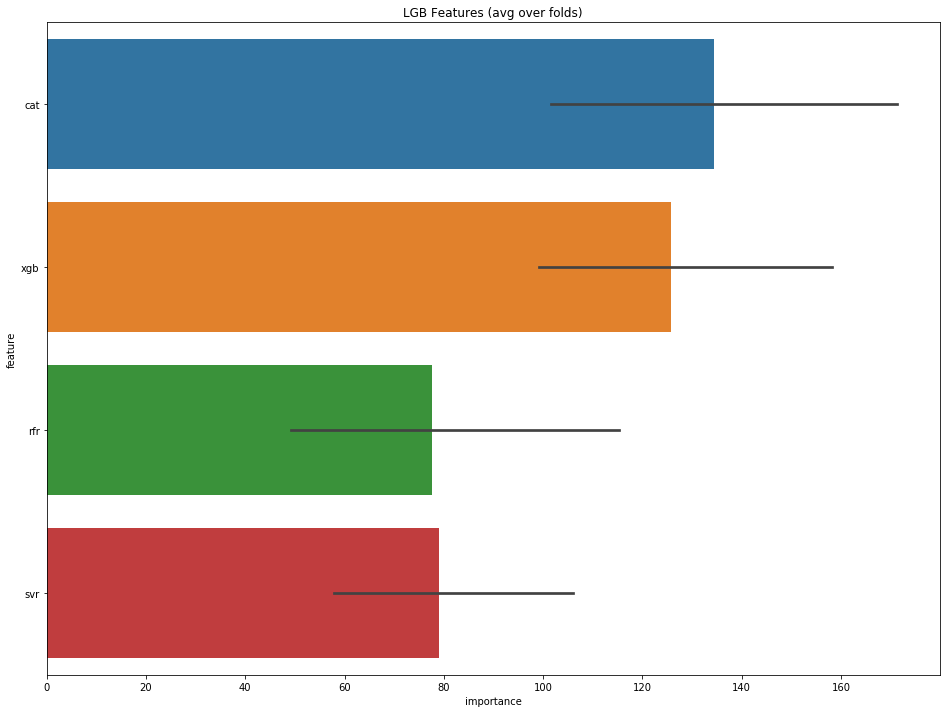

In [22]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:46:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[726]	training's rmse: 2.32804	valid_1's rmse: 2.36726
Fold 1 started at Tue Dec 17 10:46:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 2.5242	valid_1's rmse: 2.25037
Fold 2 started at Tue Dec 17 10:46:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's rmse: 2.61501	valid_1's rmse: 2.72222
Fold 3 started at Tue Dec 17 10:46:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 2.39246	valid_1's rmse: 2.64539
Fold 4 started at Tue Dec 17 10:46:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[279]	training's rmse: 2.3068	valid_1's rmse: 3.90867
Fold 5 started at Tue 

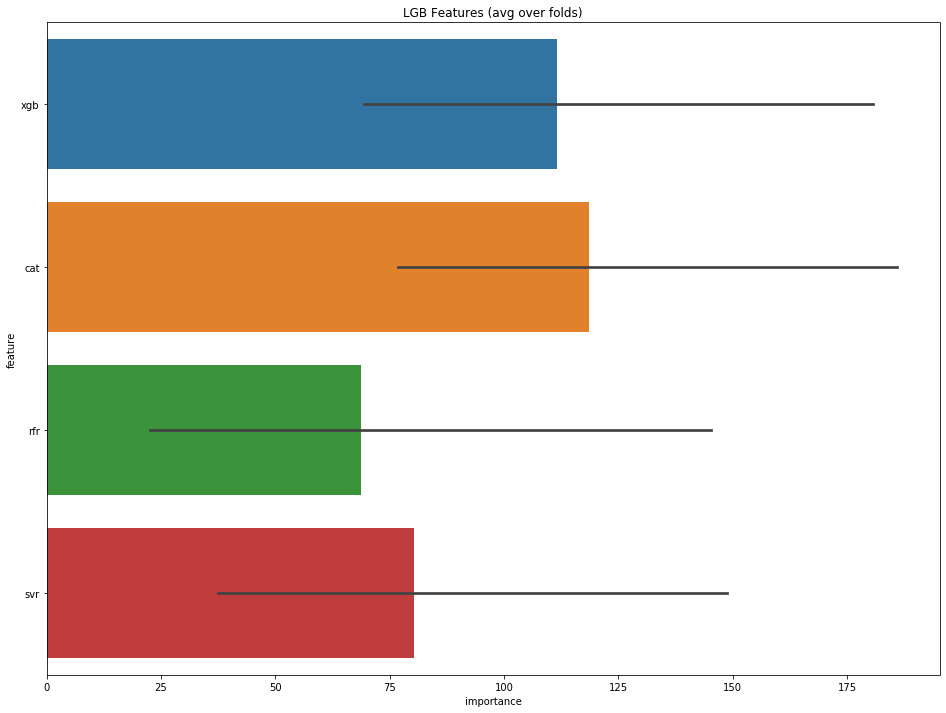

In [23]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [24]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:46:45 2019
Fold 1 started at Tue Dec 17 10:46:53 2019
Fold 2 started at Tue Dec 17 10:47:00 2019
Fold 3 started at Tue Dec 17 10:47:04 2019
Fold 4 started at Tue Dec 17 10:47:22 2019
Fold 5 started at Tue Dec 17 10:47:28 2019
Fold 6 started at Tue Dec 17 10:47:38 2019
Fold 7 started at Tue Dec 17 10:47:58 2019
Fold 8 started at Tue Dec 17 10:48:06 2019
Fold 9 started at Tue Dec 17 10:48:10 2019
CV mean score: 2.7174, std: 0.5078.


##### randomforest作为第二层融合模型

In [25]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:48:25 2019
Fold 1 started at Tue Dec 17 10:48:25 2019
Fold 2 started at Tue Dec 17 10:48:25 2019
Fold 3 started at Tue Dec 17 10:48:26 2019
Fold 4 started at Tue Dec 17 10:48:26 2019
Fold 5 started at Tue Dec 17 10:48:26 2019
Fold 6 started at Tue Dec 17 10:48:26 2019
Fold 7 started at Tue Dec 17 10:48:27 2019
Fold 8 started at Tue Dec 17 10:48:27 2019
Fold 9 started at Tue Dec 17 10:48:27 2019
CV mean score: 2.9841, std: 0.4760.


##### xgboost作为第二层融合模型

In [26]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:48:27 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.30895	valid_data-rmse:2.71473
Stopping. Best iteration:
[369]	train-rmse:1.79197	valid_data-rmse:2.65427

Fold 1 started at Tue Dec 17 10:48:27 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.27913	valid_data-rmse:2.5615
Stopping. Best iteration:
[435]	train-rmse:1.47831	valid_data-rmse:2.54195

Fold 2 started at Tue Dec 17 10:48:28 2019
[0]	train-rmse:24.0122	valid_data-rmse:23.8665
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [27]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:48:30 2019
Fold 1 started at Tue Dec 17 10:48:30 2019
Fold 2 started at Tue Dec 17 10:48:30 2019
Fold 3 started at Tue Dec 17 10:48:30 2019
Fold 4 started at Tue Dec 17 10:48:30 2019
Fold 5 started at Tue Dec 17 10:48:30 2019
Fold 6 started at Tue Dec 17 10:48:30 2019
Fold 7 started at Tue Dec 17 10:48:30 2019
Fold 8 started at Tue Dec 17 10:48:30 2019
Fold 9 started at Tue Dec 17 10:48:30 2019
CV mean score: 3.6494, std: 0.8675.


##### 岭回归做第二层融合模型

In [28]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:48:30 2019
Fold 1 started at Tue Dec 17 10:48:31 2019
Fold 2 started at Tue Dec 17 10:48:31 2019
Fold 3 started at Tue Dec 17 10:48:31 2019
Fold 4 started at Tue Dec 17 10:48:31 2019
Fold 5 started at Tue Dec 17 10:48:31 2019
Fold 6 started at Tue Dec 17 10:48:31 2019
Fold 7 started at Tue Dec 17 10:48:31 2019
Fold 8 started at Tue Dec 17 10:48:31 2019
Fold 9 started at Tue Dec 17 10:48:31 2019
CV mean score: 2.6019, std: 0.4391.


#### 去掉xgboost的结果

In [29]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:48:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 2.29828	valid_1's rmse: 2.30129
Fold 1 started at Tue Dec 17 10:48:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[235]	training's rmse: 2.47804	valid_1's rmse: 2.38082
Fold 2 started at Tue Dec 17 10:48:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.45097	valid_1's rmse: 2.8046
Fold 3 started at Tue Dec 17 10:48:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.18989	valid_1's rmse: 2.63159
Fold 4 started at Tue Dec 17 10:48:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	training's rmse: 2.00893	valid_1's rmse: 3.76561
Fold 5 started at Tue

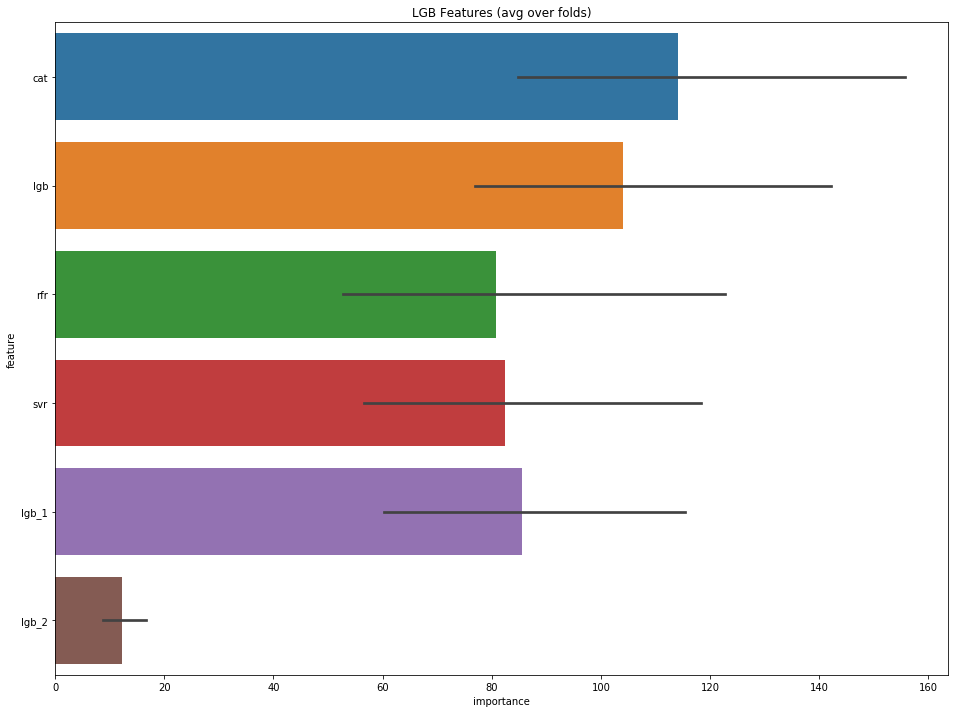

In [30]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:49:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[672]	training's rmse: 2.29224	valid_1's rmse: 2.25589
Fold 1 started at Tue Dec 17 10:49:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.50364	valid_1's rmse: 2.36047
Fold 2 started at Tue Dec 17 10:49:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[206]	training's rmse: 2.57107	valid_1's rmse: 2.8162
Fold 3 started at Tue Dec 17 10:49:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[381]	training's rmse: 2.32001	valid_1's rmse: 2.62135
Fold 4 started at Tue Dec 17 10:49:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.03801	valid_1's rmse: 3.791
Early stopping, best iteration is:
[1185]	training's rmse

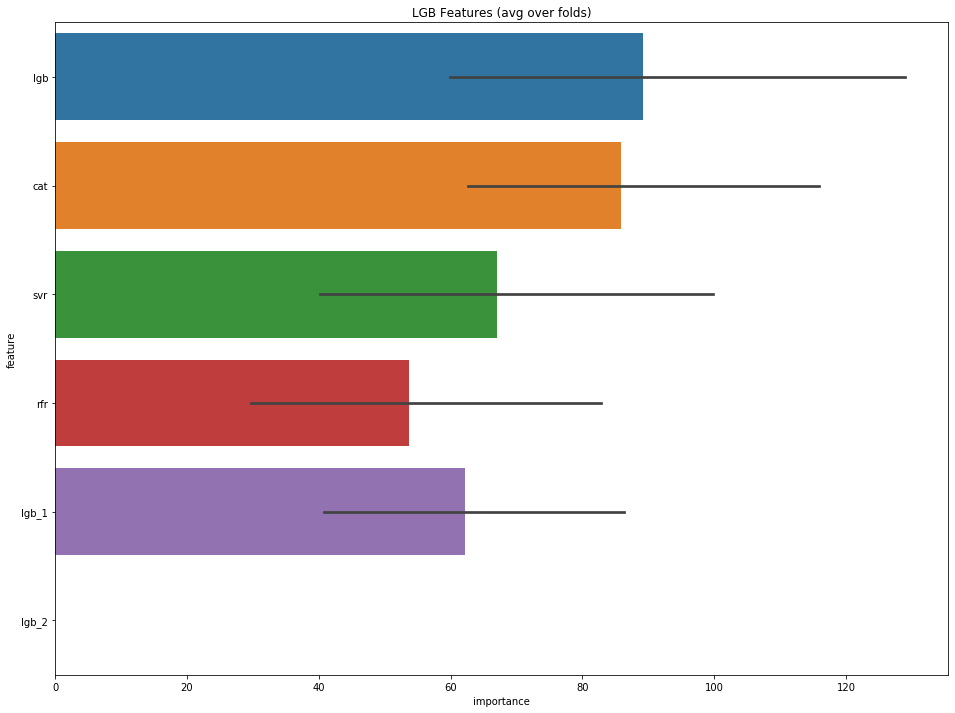

In [31]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [32]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:49:56 2019
Fold 1 started at Tue Dec 17 10:50:10 2019
Fold 2 started at Tue Dec 17 10:50:16 2019
Fold 3 started at Tue Dec 17 10:50:20 2019
Fold 4 started at Tue Dec 17 10:50:25 2019
Fold 5 started at Tue Dec 17 10:50:33 2019
Fold 6 started at Tue Dec 17 10:50:44 2019
Fold 7 started at Tue Dec 17 10:51:01 2019
Fold 8 started at Tue Dec 17 10:51:09 2019
Fold 9 started at Tue Dec 17 10:51:17 2019
CV mean score: 2.6802, std: 0.4889.


##### randomforest作为第二层融合模型

In [33]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:51:30 2019
Fold 1 started at Tue Dec 17 10:51:30 2019
Fold 2 started at Tue Dec 17 10:51:30 2019
Fold 3 started at Tue Dec 17 10:51:31 2019
Fold 4 started at Tue Dec 17 10:51:31 2019
Fold 5 started at Tue Dec 17 10:51:31 2019
Fold 6 started at Tue Dec 17 10:51:31 2019
Fold 7 started at Tue Dec 17 10:51:32 2019
Fold 8 started at Tue Dec 17 10:51:32 2019
Fold 9 started at Tue Dec 17 10:51:32 2019
CV mean score: 2.8960, std: 0.4519.


##### xgboost作为第二层融合模型

In [34]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:51:32 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23489	valid_data-rmse:2.10489
Stopping. Best iteration:
[496]	train-rmse:1.24402	valid_data-rmse:2.10291

Fold 1 started at Tue Dec 17 10:51:33 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20434	valid_data-rmse:2.6282
Stopping. Best iteration:
[435]	train-rmse:1.40667	valid_data-rmse:2.61007

Fold 2 started at Tue Dec 17 10:51:33 2019
[0]	train-rmse:24.0122	valid_data-rmse:23.8665
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [35]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:51:37 2019
Fold 1 started at Tue Dec 17 10:51:37 2019
Fold 2 started at Tue Dec 17 10:51:37 2019
Fold 3 started at Tue Dec 17 10:51:37 2019
Fold 4 started at Tue Dec 17 10:51:37 2019
Fold 5 started at Tue Dec 17 10:51:37 2019
Fold 6 started at Tue Dec 17 10:51:37 2019
Fold 7 started at Tue Dec 17 10:51:37 2019
Fold 8 started at Tue Dec 17 10:51:37 2019
Fold 9 started at Tue Dec 17 10:51:37 2019
CV mean score: 3.7002, std: 0.8521.


##### 岭回归做第二层融合模型

In [36]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:51:37 2019
Fold 1 started at Tue Dec 17 10:51:37 2019
Fold 2 started at Tue Dec 17 10:51:37 2019
Fold 3 started at Tue Dec 17 10:51:38 2019
Fold 4 started at Tue Dec 17 10:51:38 2019
Fold 5 started at Tue Dec 17 10:51:38 2019
Fold 6 started at Tue Dec 17 10:51:38 2019
Fold 7 started at Tue Dec 17 10:51:38 2019
Fold 8 started at Tue Dec 17 10:51:38 2019
Fold 9 started at Tue Dec 17 10:51:38 2019
CV mean score: 2.6209, std: 0.4176.


#### 去掉svr的结果

In [37]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:51:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[533]	training's rmse: 2.20383	valid_1's rmse: 2.21923
Fold 1 started at Tue Dec 17 10:51:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.48957	valid_1's rmse: 2.39161
Fold 2 started at Tue Dec 17 10:51:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 2.43738	valid_1's rmse: 2.72185
Fold 3 started at Tue Dec 17 10:51:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.24101	valid_1's rmse: 2.537
Fold 4 started at Tue Dec 17 10:51:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	training's rmse: 2.13061	valid_1's rmse: 3.87352
Fold 5 started at Tue 

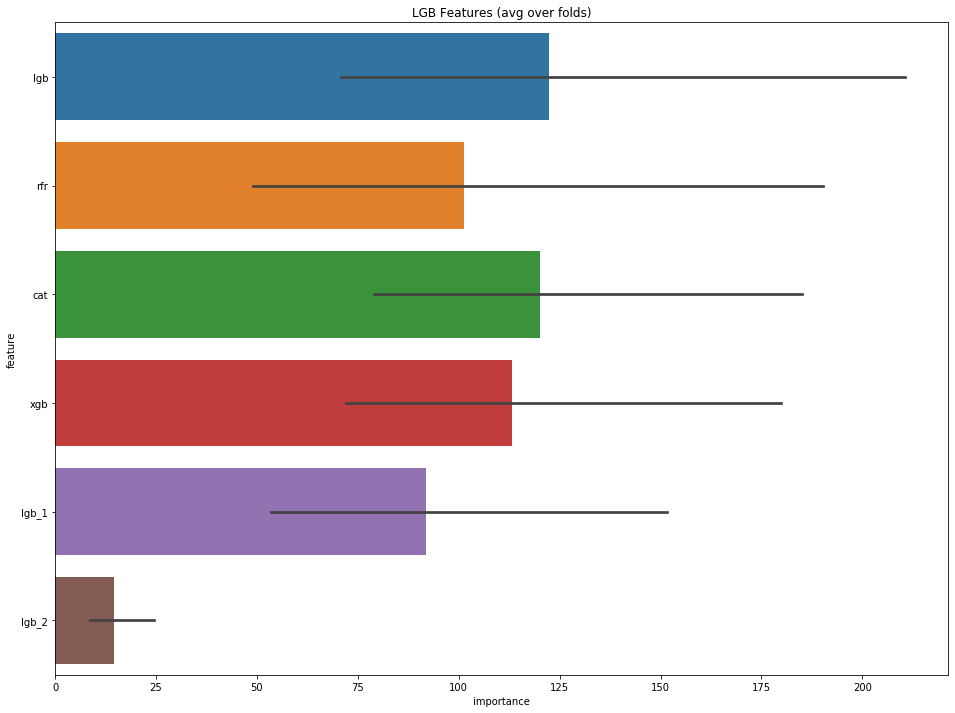

In [38]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:52:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[494]	training's rmse: 2.34469	valid_1's rmse: 2.20511
Fold 1 started at Tue Dec 17 10:52:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.50544	valid_1's rmse: 2.36486
Fold 2 started at Tue Dec 17 10:52:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 2.48127	valid_1's rmse: 2.72733
Fold 3 started at Tue Dec 17 10:52:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[470]	training's rmse: 2.31298	valid_1's rmse: 2.55013
Fold 4 started at Tue Dec 17 10:52:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[431]	training's rmse: 2.16882	valid_1's rmse: 3.9209
Fold 5 started at Tue

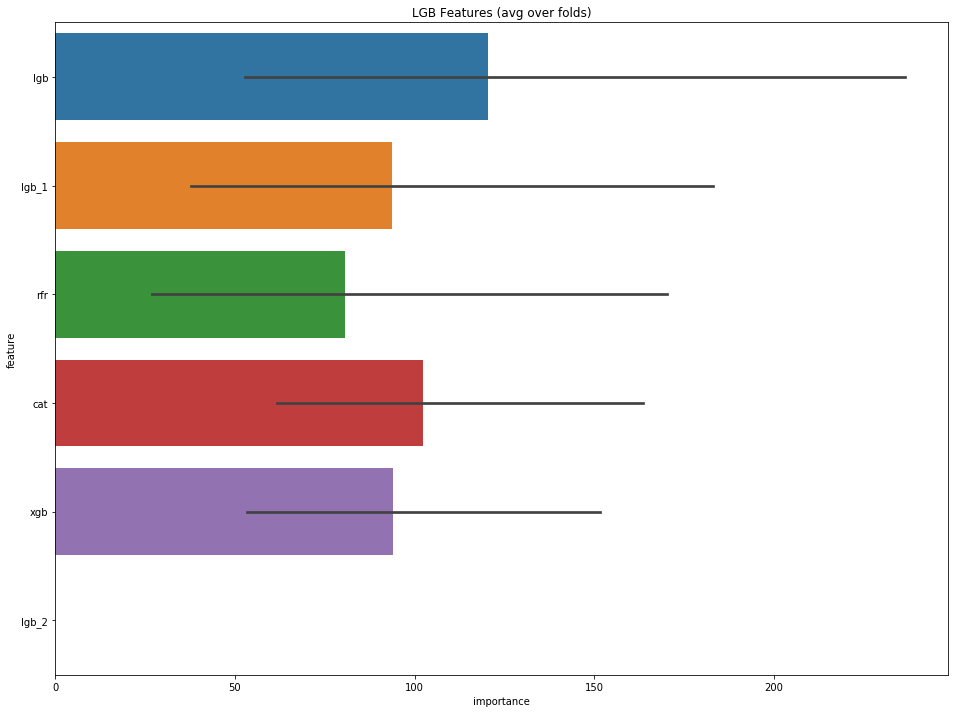

In [39]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [40]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:52:30 2019
Fold 1 started at Tue Dec 17 10:52:38 2019
Fold 2 started at Tue Dec 17 10:52:42 2019
Fold 3 started at Tue Dec 17 10:52:46 2019
Fold 4 started at Tue Dec 17 10:52:50 2019
Fold 5 started at Tue Dec 17 10:52:59 2019
Fold 6 started at Tue Dec 17 10:53:06 2019
Fold 7 started at Tue Dec 17 10:53:19 2019
Fold 8 started at Tue Dec 17 10:53:25 2019
Fold 9 started at Tue Dec 17 10:53:30 2019
CV mean score: 2.6701, std: 0.4895.


##### randomforest作为第二层融合模型

In [41]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:53:37 2019
Fold 1 started at Tue Dec 17 10:53:37 2019
Fold 2 started at Tue Dec 17 10:53:37 2019
Fold 3 started at Tue Dec 17 10:53:38 2019
Fold 4 started at Tue Dec 17 10:53:38 2019
Fold 5 started at Tue Dec 17 10:53:38 2019
Fold 6 started at Tue Dec 17 10:53:38 2019
Fold 7 started at Tue Dec 17 10:53:38 2019
Fold 8 started at Tue Dec 17 10:53:39 2019
Fold 9 started at Tue Dec 17 10:53:39 2019
CV mean score: 2.7460, std: 0.4842.


##### xgboost作为第二层融合模型

In [42]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:53:39 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25532	valid_data-rmse:2.26023
Stopping. Best iteration:
[475]	train-rmse:1.32723	valid_data-rmse:2.24933

Fold 1 started at Tue Dec 17 10:53:40 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24169	valid_data-rmse:2.63318
Stopping. Best iteration:
[382]	train-rmse:1.66923	valid_data-rmse:2.57591

Fold 2 started at Tue Dec 17 10:53:40 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.867
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [43]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:53:44 2019
Fold 1 started at Tue Dec 17 10:53:44 2019
Fold 2 started at Tue Dec 17 10:53:44 2019
Fold 3 started at Tue Dec 17 10:53:44 2019
Fold 4 started at Tue Dec 17 10:53:44 2019
Fold 5 started at Tue Dec 17 10:53:44 2019
Fold 6 started at Tue Dec 17 10:53:44 2019
Fold 7 started at Tue Dec 17 10:53:44 2019
Fold 8 started at Tue Dec 17 10:53:44 2019
Fold 9 started at Tue Dec 17 10:53:44 2019
CV mean score: 3.8783, std: 0.8822.


##### 岭回归做第二层融合模型

In [44]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:53:44 2019
Fold 1 started at Tue Dec 17 10:53:44 2019
Fold 2 started at Tue Dec 17 10:53:44 2019
Fold 3 started at Tue Dec 17 10:53:44 2019
Fold 4 started at Tue Dec 17 10:53:44 2019
Fold 5 started at Tue Dec 17 10:53:44 2019
Fold 6 started at Tue Dec 17 10:53:45 2019
Fold 7 started at Tue Dec 17 10:53:45 2019
Fold 8 started at Tue Dec 17 10:53:45 2019
Fold 9 started at Tue Dec 17 10:53:45 2019
CV mean score: 2.6032, std: 0.4265.


#### 去掉rfr的结果

In [45]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:53:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.27618	valid_1's rmse: 2.33917
Fold 1 started at Tue Dec 17 10:53:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 2.42484	valid_1's rmse: 2.35831
Fold 2 started at Tue Dec 17 10:53:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.43648	valid_1's rmse: 2.76727
Fold 3 started at Tue Dec 17 10:53:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.27839	valid_1's rmse: 2.65877
Fold 4 started at Tue Dec 17 10:53:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 2.15364	valid_1's rmse: 3.89048
Fold 5 started at Tu

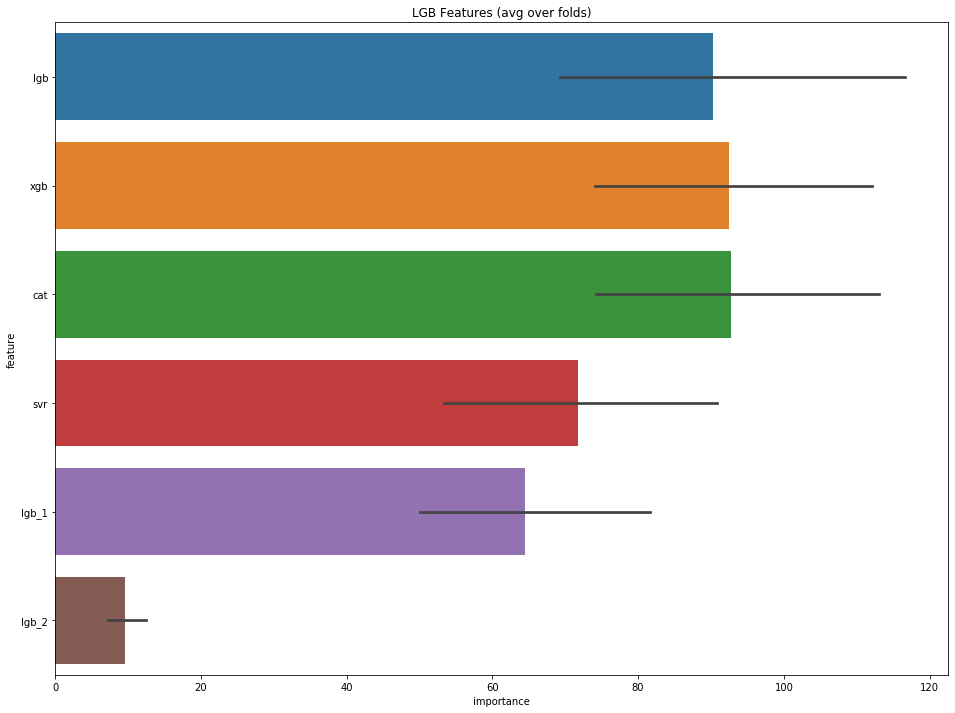

In [46]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:54:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[599]	training's rmse: 2.29601	valid_1's rmse: 2.29754
Fold 1 started at Tue Dec 17 10:54:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 2.52253	valid_1's rmse: 2.35158
Fold 2 started at Tue Dec 17 10:54:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 2.52472	valid_1's rmse: 2.76261
Fold 3 started at Tue Dec 17 10:54:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 2.35106	valid_1's rmse: 2.61214
Fold 4 started at Tue Dec 17 10:54:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 2.21038	valid_1's rmse: 3.9204
Fold 5 started at Tue

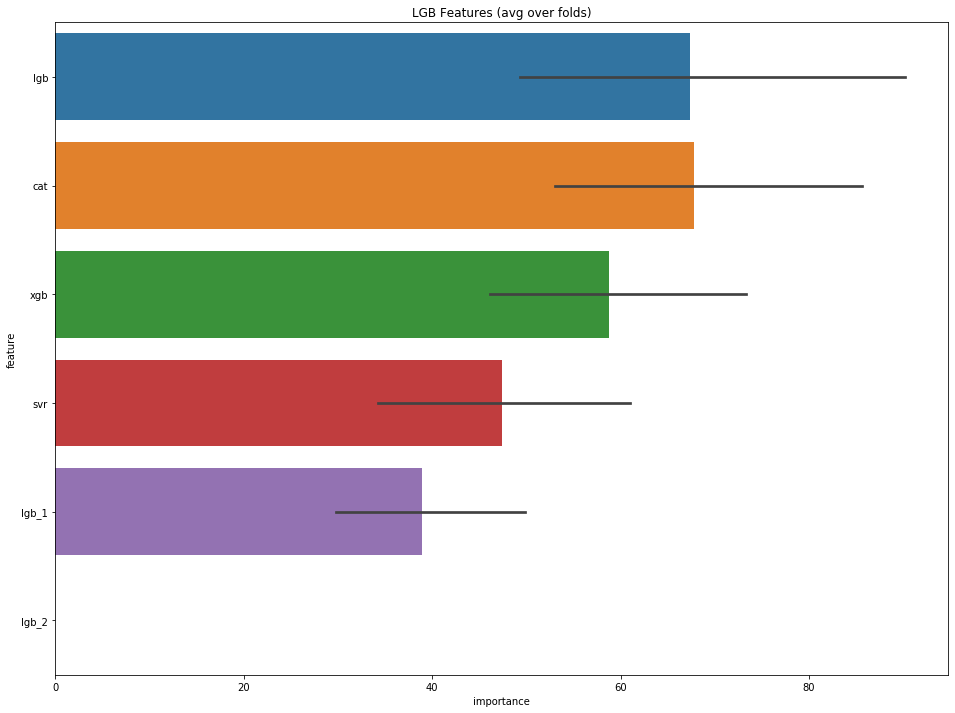

In [47]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [48]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:54:24 2019
Fold 1 started at Tue Dec 17 10:54:32 2019
Fold 2 started at Tue Dec 17 10:54:38 2019
Fold 3 started at Tue Dec 17 10:54:41 2019
Fold 4 started at Tue Dec 17 10:54:45 2019
Fold 5 started at Tue Dec 17 10:54:57 2019
Fold 6 started at Tue Dec 17 10:55:06 2019
Fold 7 started at Tue Dec 17 10:55:16 2019
Fold 8 started at Tue Dec 17 10:55:22 2019
Fold 9 started at Tue Dec 17 10:55:27 2019
CV mean score: 2.6687, std: 0.4635.


##### randomforest作为第二层融合模型

In [49]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:55:32 2019
Fold 1 started at Tue Dec 17 10:55:32 2019
Fold 2 started at Tue Dec 17 10:55:32 2019
Fold 3 started at Tue Dec 17 10:55:32 2019
Fold 4 started at Tue Dec 17 10:55:33 2019
Fold 5 started at Tue Dec 17 10:55:33 2019
Fold 6 started at Tue Dec 17 10:55:33 2019
Fold 7 started at Tue Dec 17 10:55:33 2019
Fold 8 started at Tue Dec 17 10:55:34 2019
Fold 9 started at Tue Dec 17 10:55:34 2019
CV mean score: 2.7695, std: 0.4330.


##### xgboost作为第二层融合模型

In [50]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:55:34 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.2779	valid_data-rmse:2.27751
Stopping. Best iteration:
[457]	train-rmse:1.39647	valid_data-rmse:2.27333

Fold 1 started at Tue Dec 17 10:55:34 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24097	valid_data-rmse:2.5934
Stopping. Best iteration:
[420]	train-rmse:1.48775	valid_data-rmse:2.55755

Fold 2 started at Tue Dec 17 10:55:35 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8629
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [51]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:55:38 2019
Fold 1 started at Tue Dec 17 10:55:38 2019
Fold 2 started at Tue Dec 17 10:55:38 2019
Fold 3 started at Tue Dec 17 10:55:38 2019
Fold 4 started at Tue Dec 17 10:55:38 2019
Fold 5 started at Tue Dec 17 10:55:38 2019
Fold 6 started at Tue Dec 17 10:55:38 2019
Fold 7 started at Tue Dec 17 10:55:38 2019
Fold 8 started at Tue Dec 17 10:55:38 2019
Fold 9 started at Tue Dec 17 10:55:38 2019
CV mean score: 3.6285, std: 0.8807.


##### 岭回归做第二层融合模型

In [52]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:55:38 2019
Fold 1 started at Tue Dec 17 10:55:38 2019
Fold 2 started at Tue Dec 17 10:55:38 2019
Fold 3 started at Tue Dec 17 10:55:38 2019
Fold 4 started at Tue Dec 17 10:55:38 2019
Fold 5 started at Tue Dec 17 10:55:39 2019
Fold 6 started at Tue Dec 17 10:55:39 2019
Fold 7 started at Tue Dec 17 10:55:39 2019
Fold 8 started at Tue Dec 17 10:55:39 2019
Fold 9 started at Tue Dec 17 10:55:39 2019
CV mean score: 2.5953, std: 0.4482.


#### 去掉catboost的结果

In [53]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:55:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[352]	training's rmse: 2.33516	valid_1's rmse: 2.32843
Fold 1 started at Tue Dec 17 10:55:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 2.51678	valid_1's rmse: 2.50022
Fold 2 started at Tue Dec 17 10:55:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[202]	training's rmse: 2.5733	valid_1's rmse: 2.88611
Fold 3 started at Tue Dec 17 10:55:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.31696	valid_1's rmse: 2.71559
Fold 4 started at Tue Dec 17 10:55:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 2.1805	valid_1's rmse: 3.96089
Fold 5 started at Tue 

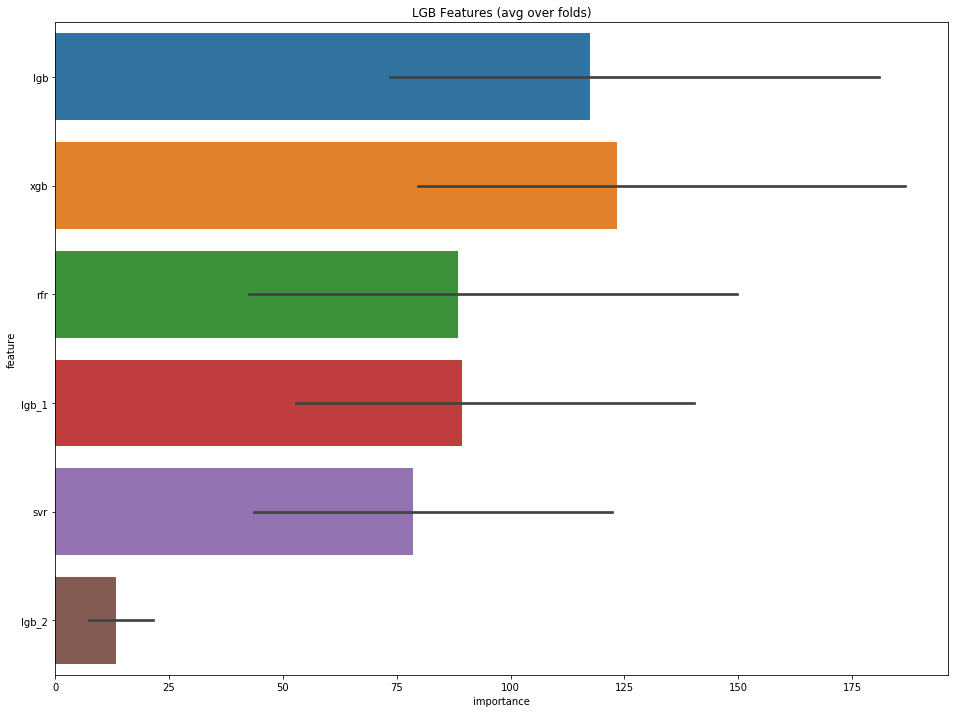

In [54]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:56:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[773]	training's rmse: 2.30127	valid_1's rmse: 2.30511
Fold 1 started at Tue Dec 17 10:56:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[235]	training's rmse: 2.57792	valid_1's rmse: 2.47596
Fold 2 started at Tue Dec 17 10:56:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rmse: 2.63119	valid_1's rmse: 2.89858
Fold 3 started at Tue Dec 17 10:56:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[327]	training's rmse: 2.39493	valid_1's rmse: 2.7421
Fold 4 started at Tue Dec 17 10:56:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 2.27314	valid_1's rmse: 4.02602
Fold 5 started at Tue

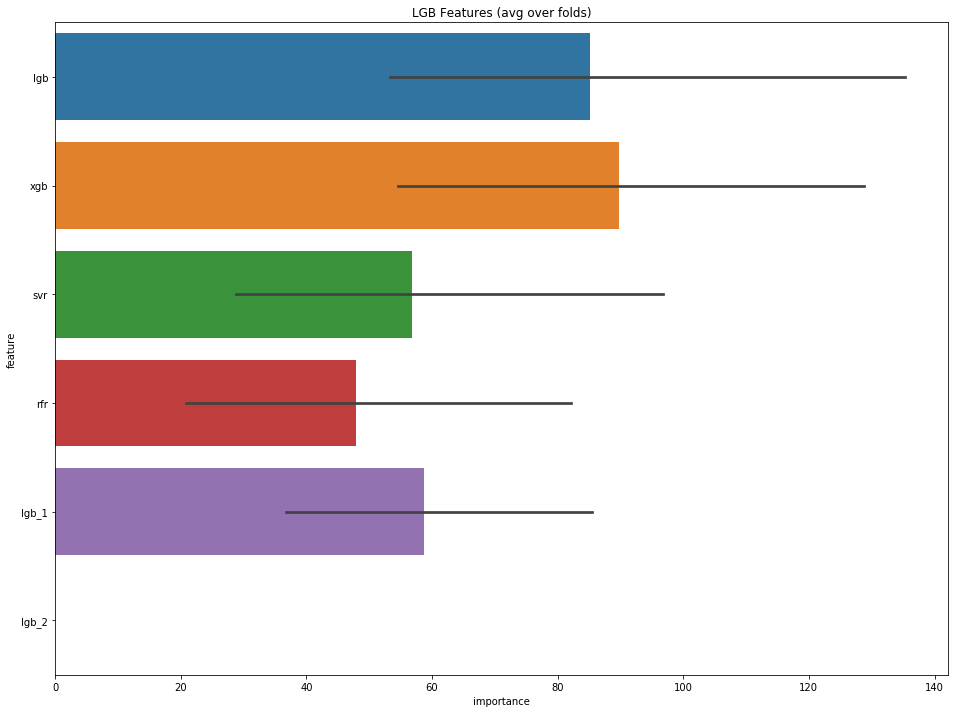

In [55]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [56]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:57:09 2019
Fold 1 started at Tue Dec 17 10:57:21 2019
Fold 2 started at Tue Dec 17 10:57:27 2019
Fold 3 started at Tue Dec 17 10:57:31 2019
Fold 4 started at Tue Dec 17 10:57:36 2019
Fold 5 started at Tue Dec 17 10:57:43 2019
Fold 6 started at Tue Dec 17 10:58:12 2019
Fold 7 started at Tue Dec 17 10:58:44 2019
Fold 8 started at Tue Dec 17 10:58:51 2019
Fold 9 started at Tue Dec 17 10:58:56 2019
CV mean score: 2.6804, std: 0.4790.


##### randomforest作为第二层融合模型

In [57]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:59:03 2019
Fold 1 started at Tue Dec 17 10:59:03 2019
Fold 2 started at Tue Dec 17 10:59:03 2019
Fold 3 started at Tue Dec 17 10:59:03 2019
Fold 4 started at Tue Dec 17 10:59:04 2019
Fold 5 started at Tue Dec 17 10:59:04 2019
Fold 6 started at Tue Dec 17 10:59:04 2019
Fold 7 started at Tue Dec 17 10:59:04 2019
Fold 8 started at Tue Dec 17 10:59:04 2019
Fold 9 started at Tue Dec 17 10:59:05 2019
CV mean score: 2.9059, std: 0.4438.


##### xgboost作为第二层融合模型

In [58]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:59:05 2019
[0]	train-rmse:23.9857	valid_data-rmse:24.1082
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.27652	valid_data-rmse:2.37553
Stopping. Best iteration:
[465]	train-rmse:1.37073	valid_data-rmse:2.37014

Fold 1 started at Tue Dec 17 10:59:05 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24132	valid_data-rmse:2.74145
Stopping. Best iteration:
[400]	train-rmse:1.57655	valid_data-rmse:2.68867

Fold 2 started at Tue Dec 17 10:59:06 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8754
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [59]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:59:09 2019
Fold 1 started at Tue Dec 17 10:59:09 2019
Fold 2 started at Tue Dec 17 10:59:09 2019
Fold 3 started at Tue Dec 17 10:59:09 2019
Fold 4 started at Tue Dec 17 10:59:09 2019
Fold 5 started at Tue Dec 17 10:59:09 2019
Fold 6 started at Tue Dec 17 10:59:09 2019
Fold 7 started at Tue Dec 17 10:59:09 2019
Fold 8 started at Tue Dec 17 10:59:09 2019
Fold 9 started at Tue Dec 17 10:59:09 2019
CV mean score: 3.7697, std: 0.8700.


##### 岭回归做第二层融合模型

In [60]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:59:09 2019
Fold 1 started at Tue Dec 17 10:59:09 2019
Fold 2 started at Tue Dec 17 10:59:10 2019
Fold 3 started at Tue Dec 17 10:59:10 2019
Fold 4 started at Tue Dec 17 10:59:10 2019
Fold 5 started at Tue Dec 17 10:59:10 2019
Fold 6 started at Tue Dec 17 10:59:10 2019
Fold 7 started at Tue Dec 17 10:59:10 2019
Fold 8 started at Tue Dec 17 10:59:10 2019
Fold 9 started at Tue Dec 17 10:59:10 2019
CV mean score: 2.6291, std: 0.4679.


#### 去掉xgb和lgb的结果

In [61]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:59:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[402]	training's rmse: 2.43075	valid_1's rmse: 2.54712
Fold 1 started at Tue Dec 17 10:59:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 2.53993	valid_1's rmse: 2.32747
Fold 2 started at Tue Dec 17 10:59:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[208]	training's rmse: 2.67208	valid_1's rmse: 2.81622
Fold 3 started at Tue Dec 17 10:59:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's rmse: 2.41751	valid_1's rmse: 2.86138
Fold 4 started at Tue Dec 17 10:59:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 2.30007	valid_1's rmse: 3.74263
Fold 5 started at Tu

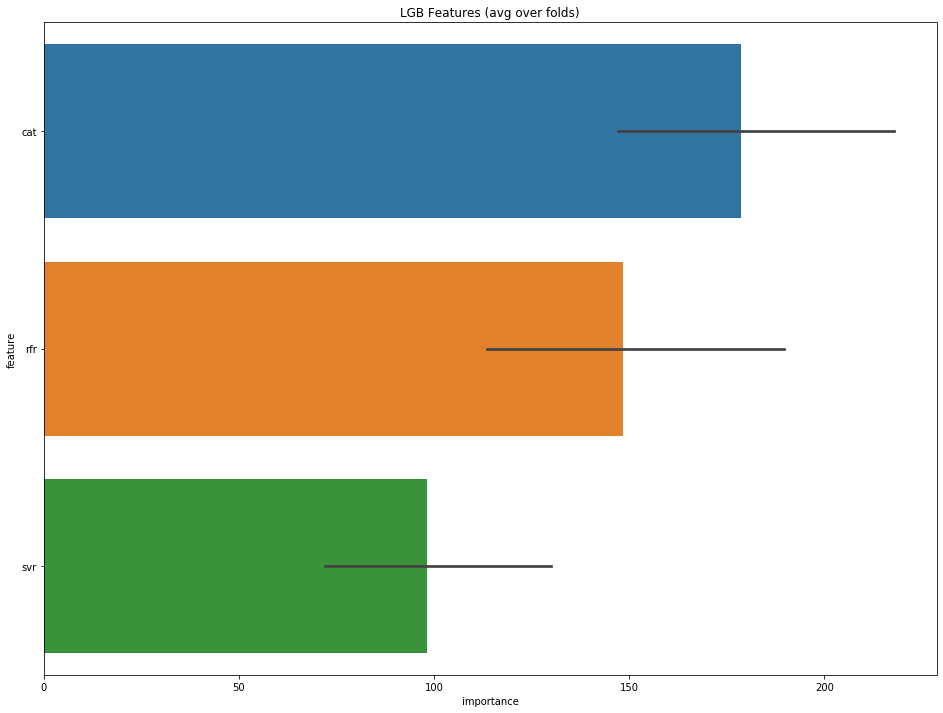

In [62]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:59:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.35616	valid_1's rmse: 2.55523
Early stopping, best iteration is:
[956]	training's rmse: 2.36272	valid_1's rmse: 2.55485
Fold 1 started at Tue Dec 17 10:59:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 2.58741	valid_1's rmse: 2.26718
Fold 2 started at Tue Dec 17 10:59:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's rmse: 2.61279	valid_1's rmse: 2.80507
Fold 3 started at Tue Dec 17 10:59:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[405]	training's rmse: 2.43819	valid_1's rmse: 2.77658
Fold 4 started at Tue Dec 17 10:59:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.1819	valid_1's rmse: 3.74272

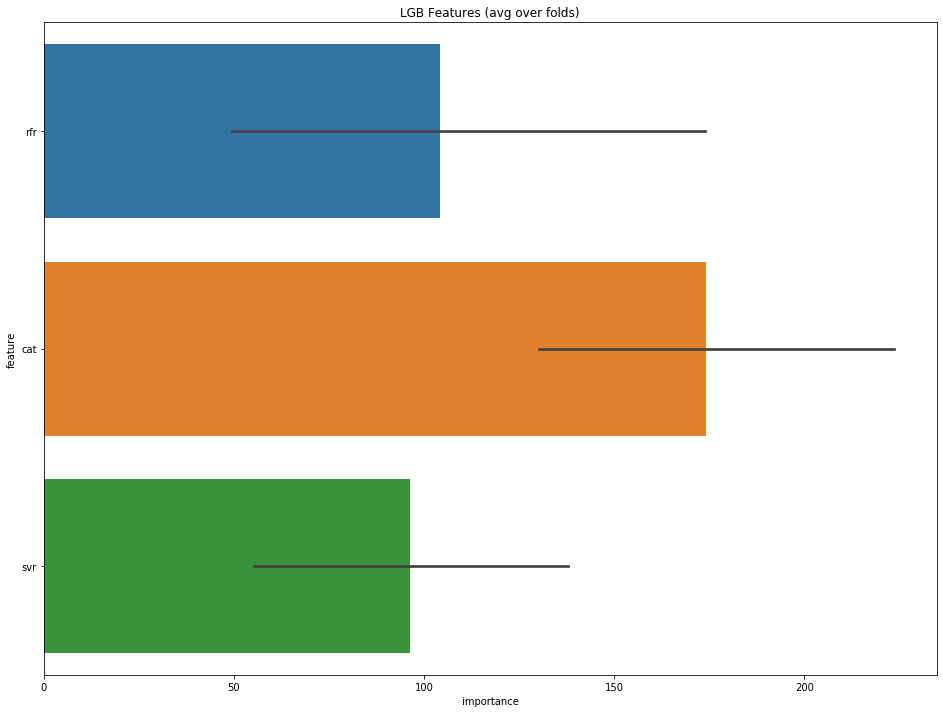

In [63]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [64]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:00:22 2019
Fold 1 started at Tue Dec 17 11:00:33 2019
Fold 2 started at Tue Dec 17 11:00:44 2019
Fold 3 started at Tue Dec 17 11:00:49 2019
Fold 4 started at Tue Dec 17 11:01:30 2019
Fold 5 started at Tue Dec 17 11:01:47 2019
Fold 6 started at Tue Dec 17 11:01:59 2019
Fold 7 started at Tue Dec 17 11:02:26 2019
Fold 8 started at Tue Dec 17 11:02:35 2019
Fold 9 started at Tue Dec 17 11:02:43 2019
CV mean score: 2.7514, std: 0.4790.


##### randomforest作为第二层融合模型

In [65]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:03:00 2019
Fold 1 started at Tue Dec 17 11:03:01 2019
Fold 2 started at Tue Dec 17 11:03:01 2019
Fold 3 started at Tue Dec 17 11:03:01 2019
Fold 4 started at Tue Dec 17 11:03:01 2019
Fold 5 started at Tue Dec 17 11:03:02 2019
Fold 6 started at Tue Dec 17 11:03:02 2019
Fold 7 started at Tue Dec 17 11:03:02 2019
Fold 8 started at Tue Dec 17 11:03:02 2019
Fold 9 started at Tue Dec 17 11:03:02 2019
CV mean score: 3.1538, std: 0.5238.


##### xgboost作为第二层融合模型

In [66]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:03:03 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1062
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.48969	valid_data-rmse:2.72744
Stopping. Best iteration:
[331]	train-rmse:2.18307	valid_data-rmse:2.56056

Fold 1 started at Tue Dec 17 11:03:03 2019
[0]	train-rmse:24.1979	valid_data-rmse:22.177
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.43084	valid_data-rmse:2.46781
Stopping. Best iteration:
[500]	train-rmse:1.43084	valid_data-rmse:2.46781

Fold 2 started at Tue Dec 17 11:03:03 2019
[0]	train-rmse:24.0124	valid_data-rmse:23.8668
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Bes

##### svr 作为第二层融合模型

In [67]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:03:05 2019
Fold 1 started at Tue Dec 17 11:03:05 2019
Fold 2 started at Tue Dec 17 11:03:05 2019
Fold 3 started at Tue Dec 17 11:03:05 2019
Fold 4 started at Tue Dec 17 11:03:06 2019
Fold 5 started at Tue Dec 17 11:03:06 2019
Fold 6 started at Tue Dec 17 11:03:06 2019
Fold 7 started at Tue Dec 17 11:03:06 2019
Fold 8 started at Tue Dec 17 11:03:06 2019
Fold 9 started at Tue Dec 17 11:03:06 2019
CV mean score: 3.4485, std: 0.7903.


##### 岭回归做第二层融合模型

In [68]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:03:06 2019
Fold 1 started at Tue Dec 17 11:03:06 2019
Fold 2 started at Tue Dec 17 11:03:06 2019
Fold 3 started at Tue Dec 17 11:03:06 2019
Fold 4 started at Tue Dec 17 11:03:06 2019
Fold 5 started at Tue Dec 17 11:03:06 2019
Fold 6 started at Tue Dec 17 11:03:06 2019
Fold 7 started at Tue Dec 17 11:03:06 2019
Fold 8 started at Tue Dec 17 11:03:07 2019
Fold 9 started at Tue Dec 17 11:03:07 2019
CV mean score: 2.6678, std: 0.3877.


#### 去掉lgb和svr的结果

In [69]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:03:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.4183	valid_1's rmse: 2.36646
Fold 1 started at Tue Dec 17 11:03:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 2.56295	valid_1's rmse: 2.27883
Fold 2 started at Tue Dec 17 11:03:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's rmse: 2.57769	valid_1's rmse: 2.73594
Fold 3 started at Tue Dec 17 11:03:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 2.42321	valid_1's rmse: 2.52845
Fold 4 started at Tue Dec 17 11:03:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[354]	training's rmse: 2.27124	valid_1's rmse: 3.85334
Fold 5 started at Tue

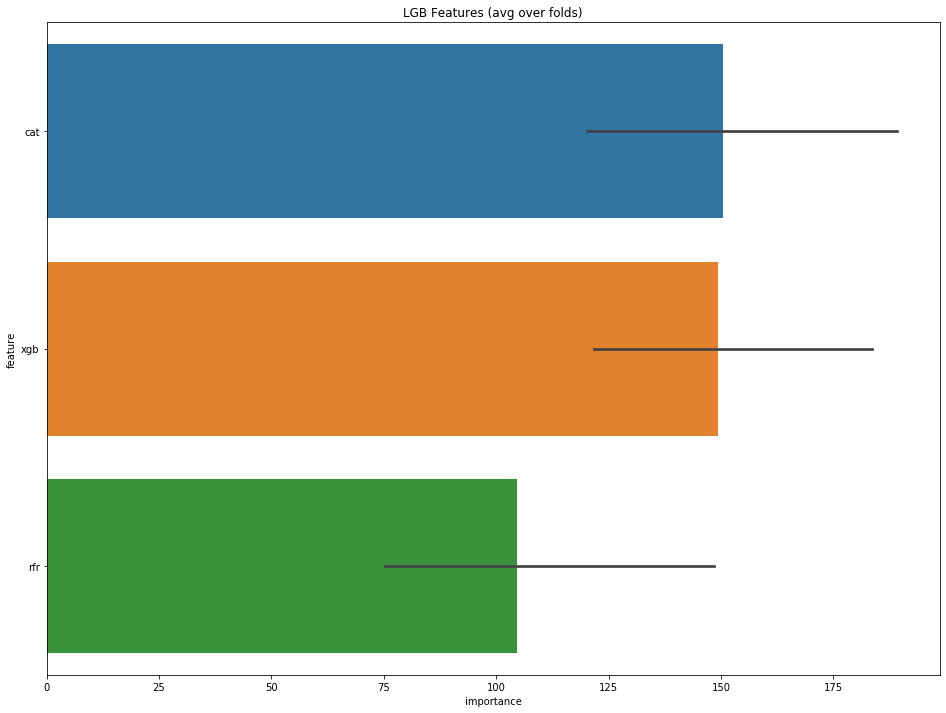

In [70]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:03:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 2.43839	valid_1's rmse: 2.37217
Fold 1 started at Tue Dec 17 11:03:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 2.52668	valid_1's rmse: 2.26619
Fold 2 started at Tue Dec 17 11:03:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[225]	training's rmse: 2.59461	valid_1's rmse: 2.697
Fold 3 started at Tue Dec 17 11:03:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[503]	training's rmse: 2.42483	valid_1's rmse: 2.55803
Fold 4 started at Tue Dec 17 11:03:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.20324	valid_1's rmse: 3.9011
Early stopping, best iteration is:
[1023]	training's rmse

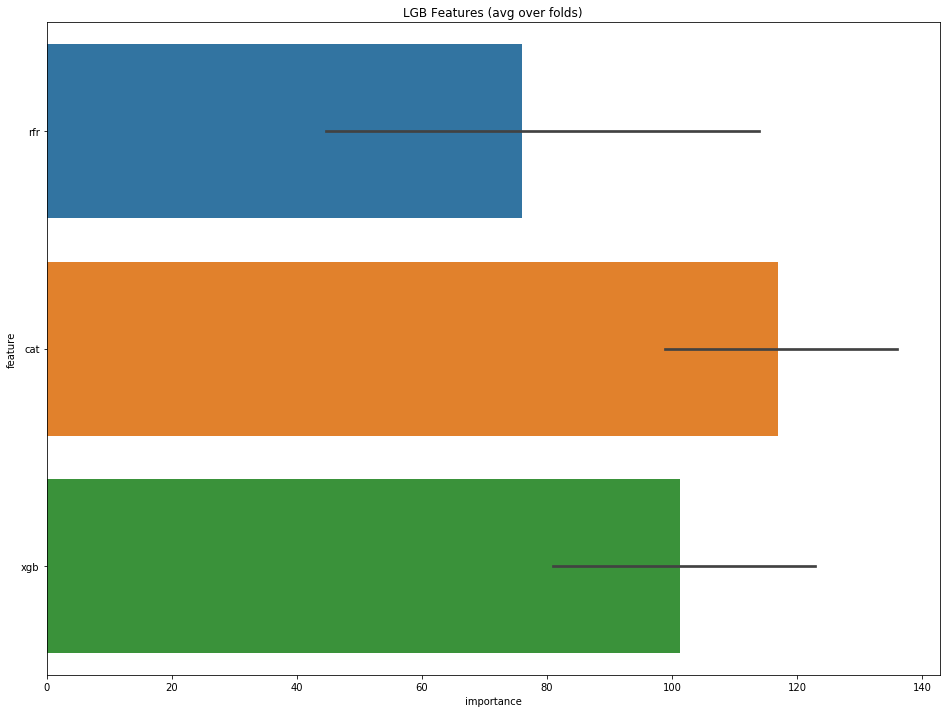

In [71]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [72]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:03:51 2019
Fold 1 started at Tue Dec 17 11:04:00 2019
Fold 2 started at Tue Dec 17 11:04:09 2019
Fold 3 started at Tue Dec 17 11:04:14 2019
Fold 4 started at Tue Dec 17 11:04:37 2019
Fold 5 started at Tue Dec 17 11:04:44 2019
Fold 6 started at Tue Dec 17 11:04:54 2019
Fold 7 started at Tue Dec 17 11:05:16 2019
Fold 8 started at Tue Dec 17 11:05:23 2019
Fold 9 started at Tue Dec 17 11:05:29 2019
CV mean score: 2.6867, std: 0.5343.


##### randomforest作为第二层融合模型

In [73]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:05:39 2019
Fold 1 started at Tue Dec 17 11:05:39 2019
Fold 2 started at Tue Dec 17 11:05:40 2019
Fold 3 started at Tue Dec 17 11:05:40 2019
Fold 4 started at Tue Dec 17 11:05:40 2019
Fold 5 started at Tue Dec 17 11:05:40 2019
Fold 6 started at Tue Dec 17 11:05:40 2019
Fold 7 started at Tue Dec 17 11:05:41 2019
Fold 8 started at Tue Dec 17 11:05:41 2019
Fold 9 started at Tue Dec 17 11:05:41 2019
CV mean score: 2.8734, std: 0.4721.


##### xgboost作为第二层融合模型

In [74]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:05:41 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.42357	valid_data-rmse:2.63939
Stopping. Best iteration:
[358]	train-rmse:1.95614	valid_data-rmse:2.55576

Fold 1 started at Tue Dec 17 11:05:42 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.41033	valid_data-rmse:2.55012
Stopping. Best iteration:
[386]	train-rmse:1.795	valid_data-rmse:2.52144

Fold 2 started at Tue Dec 17 11:05:42 2019
[0]	train-rmse:24.0122	valid_data-rmse:23.8665
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [75]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:05:44 2019
Fold 1 started at Tue Dec 17 11:05:44 2019
Fold 2 started at Tue Dec 17 11:05:44 2019
Fold 3 started at Tue Dec 17 11:05:44 2019
Fold 4 started at Tue Dec 17 11:05:44 2019
Fold 5 started at Tue Dec 17 11:05:44 2019
Fold 6 started at Tue Dec 17 11:05:44 2019
Fold 7 started at Tue Dec 17 11:05:44 2019
Fold 8 started at Tue Dec 17 11:05:44 2019
Fold 9 started at Tue Dec 17 11:05:44 2019
CV mean score: 3.8224, std: 0.8461.


##### 岭回归做第二层融合模型

In [76]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:05:44 2019
Fold 1 started at Tue Dec 17 11:05:44 2019
Fold 2 started at Tue Dec 17 11:05:45 2019
Fold 3 started at Tue Dec 17 11:05:45 2019
Fold 4 started at Tue Dec 17 11:05:45 2019
Fold 5 started at Tue Dec 17 11:05:45 2019
Fold 6 started at Tue Dec 17 11:05:45 2019
Fold 7 started at Tue Dec 17 11:05:45 2019
Fold 8 started at Tue Dec 17 11:05:45 2019
Fold 9 started at Tue Dec 17 11:05:45 2019
CV mean score: 2.6021, std: 0.4309.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:05:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 2.38228	valid_1's rmse: 2.48815
Fold 1 started at Tue Dec 17 11:05:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 2.54904	valid_1's rmse: 2.25108
Fold 2 started at Tue Dec 17 11:05:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[211]	training's rmse: 2.59182	valid_1's rmse: 2.69574
Fold 3 started at Tue Dec 17 11:05:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[374]	training's rmse: 2.37179	valid_1's rmse: 2.60386
Fold 4 started at Tue Dec 17 11:06:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.31757	valid_1's rmse: 3.84438
Fold 5 started at Tu

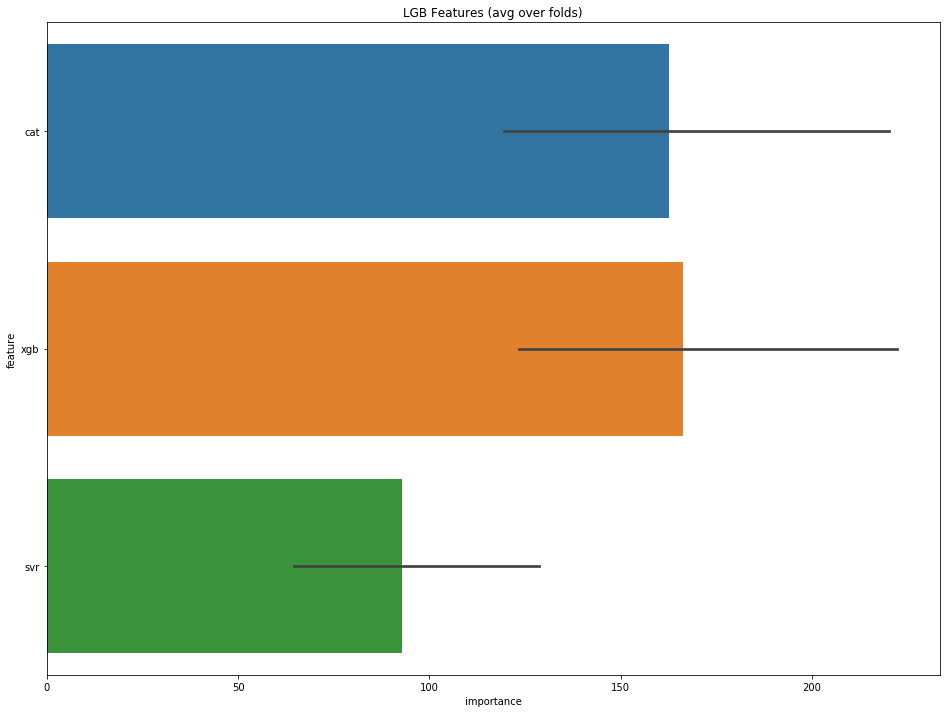

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:06:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[537]	training's rmse: 2.39546	valid_1's rmse: 2.44921
Fold 1 started at Tue Dec 17 11:06:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 2.53254	valid_1's rmse: 2.24626
Fold 2 started at Tue Dec 17 11:06:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[224]	training's rmse: 2.57231	valid_1's rmse: 2.70889
Fold 3 started at Tue Dec 17 11:06:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[393]	training's rmse: 2.40415	valid_1's rmse: 2.64216
Fold 4 started at Tue Dec 17 11:06:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[288]	training's rmse: 2.30195	valid_1's rmse: 3.90316
Fold 5 started at Tu

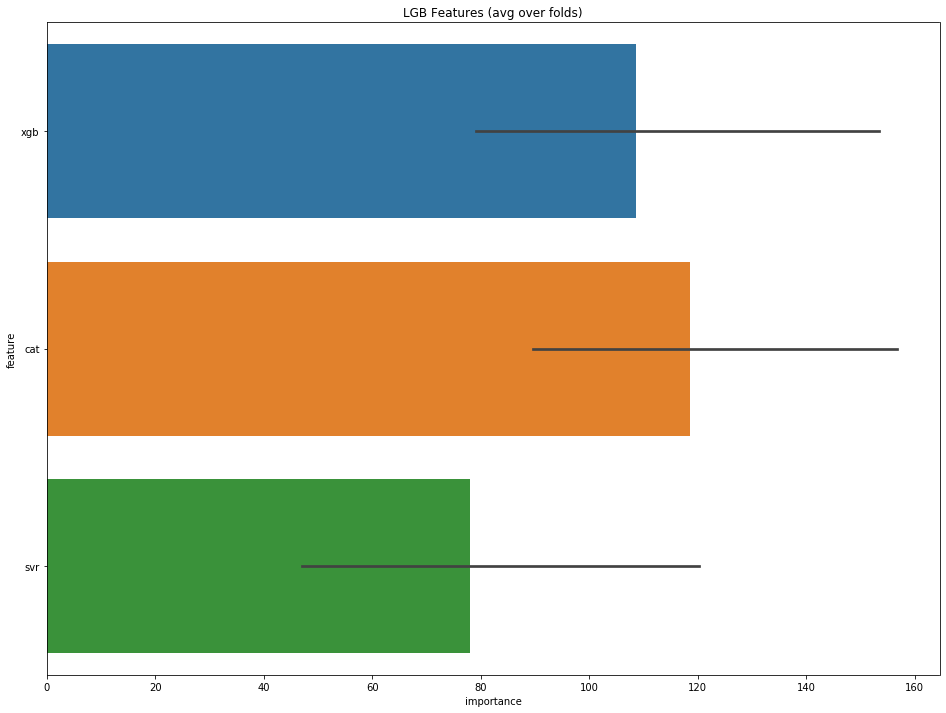

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:06:51 2019
Fold 1 started at Tue Dec 17 11:07:01 2019
Fold 2 started at Tue Dec 17 11:07:11 2019
Fold 3 started at Tue Dec 17 11:07:17 2019
Fold 4 started at Tue Dec 17 11:07:39 2019
Fold 5 started at Tue Dec 17 11:07:48 2019
Fold 6 started at Tue Dec 17 11:07:59 2019
Fold 7 started at Tue Dec 17 11:08:16 2019
Fold 8 started at Tue Dec 17 11:08:27 2019
Fold 9 started at Tue Dec 17 11:08:35 2019
CV mean score: 2.6861, std: 0.4939.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:08:49 2019
Fold 1 started at Tue Dec 17 11:08:49 2019
Fold 2 started at Tue Dec 17 11:08:50 2019
Fold 3 started at Tue Dec 17 11:08:50 2019
Fold 4 started at Tue Dec 17 11:08:50 2019
Fold 5 started at Tue Dec 17 11:08:50 2019
Fold 6 started at Tue Dec 17 11:08:51 2019
Fold 7 started at Tue Dec 17 11:08:51 2019
Fold 8 started at Tue Dec 17 11:08:51 2019
Fold 9 started at Tue Dec 17 11:08:51 2019
CV mean score: 3.0514, std: 0.6598.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:08:52 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.45764	valid_data-rmse:2.7275
Stopping. Best iteration:
[383]	train-rmse:1.83598	valid_data-rmse:2.66485

Fold 1 started at Tue Dec 17 11:08:52 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.40439	valid_data-rmse:2.59765
Stopping. Best iteration:
[397]	train-rmse:1.73679	valid_data-rmse:2.56435

Fold 2 started at Tue Dec 17 11:08:52 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8621
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:08:54 2019
Fold 1 started at Tue Dec 17 11:08:54 2019
Fold 2 started at Tue Dec 17 11:08:54 2019
Fold 3 started at Tue Dec 17 11:08:54 2019
Fold 4 started at Tue Dec 17 11:08:54 2019
Fold 5 started at Tue Dec 17 11:08:54 2019
Fold 6 started at Tue Dec 17 11:08:54 2019
Fold 7 started at Tue Dec 17 11:08:54 2019
Fold 8 started at Tue Dec 17 11:08:54 2019
Fold 9 started at Tue Dec 17 11:08:54 2019
CV mean score: 3.4842, std: 0.8675.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:08:54 2019
Fold 1 started at Tue Dec 17 11:08:54 2019
Fold 2 started at Tue Dec 17 11:08:54 2019
Fold 3 started at Tue Dec 17 11:08:55 2019
Fold 4 started at Tue Dec 17 11:08:55 2019
Fold 5 started at Tue Dec 17 11:08:55 2019
Fold 6 started at Tue Dec 17 11:08:55 2019
Fold 7 started at Tue Dec 17 11:08:55 2019
Fold 8 started at Tue Dec 17 11:08:55 2019
Fold 9 started at Tue Dec 17 11:08:55 2019
CV mean score: 2.5889, std: 0.4460.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:08:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[571]	training's rmse: 2.34358	valid_1's rmse: 2.43523
Fold 1 started at Tue Dec 17 11:09:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 2.53879	valid_1's rmse: 2.35701
Fold 2 started at Tue Dec 17 11:09:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's rmse: 2.67787	valid_1's rmse: 2.81034
Fold 3 started at Tue Dec 17 11:09:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.49487	valid_1's rmse: 2.62022
Fold 4 started at Tue Dec 17 11:09:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.37962	valid_1's rmse: 3.89794
Fold 5 started at Tu

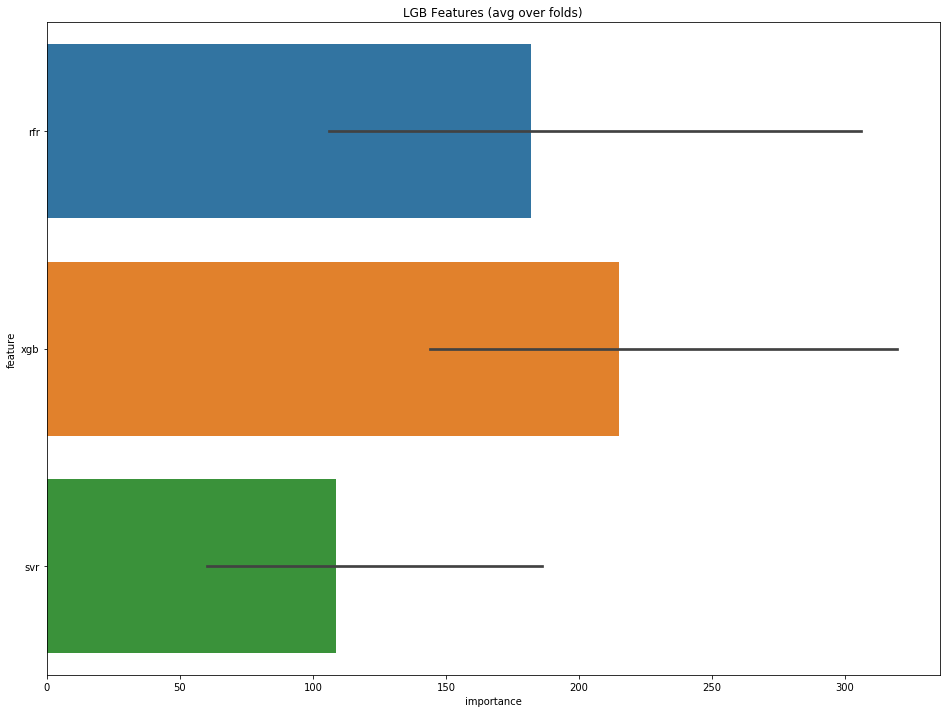

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:10:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.38678	valid_1's rmse: 2.38155
Early stopping, best iteration is:
[918]	training's rmse: 2.4023	valid_1's rmse: 2.36756
Fold 1 started at Tue Dec 17 11:10:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 2.60822	valid_1's rmse: 2.29009
Fold 2 started at Tue Dec 17 11:10:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[205]	training's rmse: 2.68767	valid_1's rmse: 2.83773
Fold 3 started at Tue Dec 17 11:10:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 2.48738	valid_1's rmse: 2.58493
Fold 4 started at Tue Dec 17 11:10:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rms

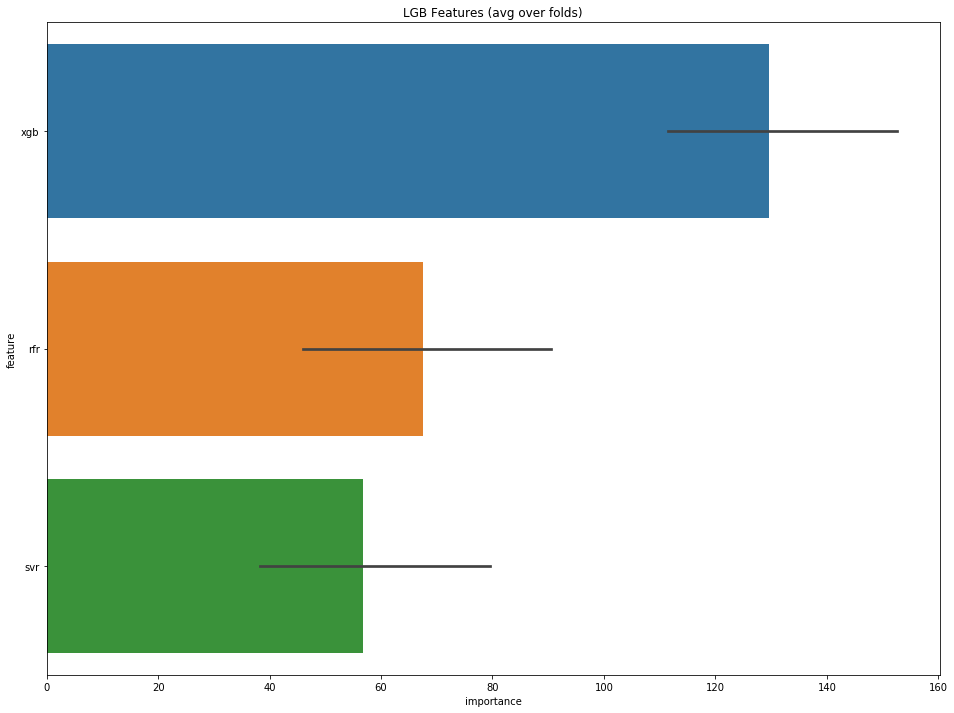

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:10:51 2019
Fold 1 started at Tue Dec 17 11:11:02 2019
Fold 2 started at Tue Dec 17 11:11:13 2019
Fold 3 started at Tue Dec 17 11:11:19 2019
Fold 4 started at Tue Dec 17 11:11:35 2019
Fold 5 started at Tue Dec 17 11:11:42 2019
Fold 6 started at Tue Dec 17 11:11:52 2019
Fold 7 started at Tue Dec 17 11:12:32 2019
Fold 8 started at Tue Dec 17 11:12:43 2019
Fold 9 started at Tue Dec 17 11:12:51 2019
CV mean score: 2.7896, std: 0.5125.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:13:01 2019
Fold 1 started at Tue Dec 17 11:13:01 2019
Fold 2 started at Tue Dec 17 11:13:01 2019
Fold 3 started at Tue Dec 17 11:13:01 2019
Fold 4 started at Tue Dec 17 11:13:02 2019
Fold 5 started at Tue Dec 17 11:13:02 2019
Fold 6 started at Tue Dec 17 11:13:02 2019
Fold 7 started at Tue Dec 17 11:13:02 2019
Fold 8 started at Tue Dec 17 11:13:03 2019
Fold 9 started at Tue Dec 17 11:13:03 2019
CV mean score: 3.1537, std: 0.5428.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:13:03 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1062
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.45098	valid_data-rmse:2.851
Stopping. Best iteration:
[329]	train-rmse:2.17186	valid_data-rmse:2.70678

Fold 1 started at Tue Dec 17 11:13:03 2019
[0]	train-rmse:24.1979	valid_data-rmse:22.177
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.42458	valid_data-rmse:2.57407
Stopping. Best iteration:
[366]	train-rmse:1.92296	valid_data-rmse:2.5289

Fold 2 started at Tue Dec 17 11:13:04 2019
[0]	train-rmse:24.0124	valid_data-rmse:23.8668
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse

##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:13:06 2019
Fold 1 started at Tue Dec 17 11:13:06 2019
Fold 2 started at Tue Dec 17 11:13:06 2019
Fold 3 started at Tue Dec 17 11:13:06 2019
Fold 4 started at Tue Dec 17 11:13:06 2019
Fold 5 started at Tue Dec 17 11:13:06 2019
Fold 6 started at Tue Dec 17 11:13:06 2019
Fold 7 started at Tue Dec 17 11:13:06 2019
Fold 8 started at Tue Dec 17 11:13:06 2019
Fold 9 started at Tue Dec 17 11:13:06 2019
CV mean score: 3.5750, std: 0.8036.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:13:06 2019
Fold 1 started at Tue Dec 17 11:13:06 2019
Fold 2 started at Tue Dec 17 11:13:06 2019
Fold 3 started at Tue Dec 17 11:13:06 2019
Fold 4 started at Tue Dec 17 11:13:06 2019
Fold 5 started at Tue Dec 17 11:13:06 2019
Fold 6 started at Tue Dec 17 11:13:07 2019
Fold 7 started at Tue Dec 17 11:13:07 2019
Fold 8 started at Tue Dec 17 11:13:07 2019
Fold 9 started at Tue Dec 17 11:13:07 2019
CV mean score: 2.6619, std: 0.4982.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:13:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[405]	training's rmse: 2.33155	valid_1's rmse: 2.21597
Fold 1 started at Tue Dec 17 11:13:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[215]	training's rmse: 2.58469	valid_1's rmse: 2.41988
Fold 2 started at Tue Dec 17 11:13:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 2.47815	valid_1's rmse: 2.77058
Fold 3 started at Tue Dec 17 11:13:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[672]	training's rmse: 2.16543	valid_1's rmse: 2.51613
Fold 4 started at Tue Dec 17 11:13:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[408]	training's rmse: 2.12749	valid_1's rmse: 3.77873
Fold 5 started at Tu

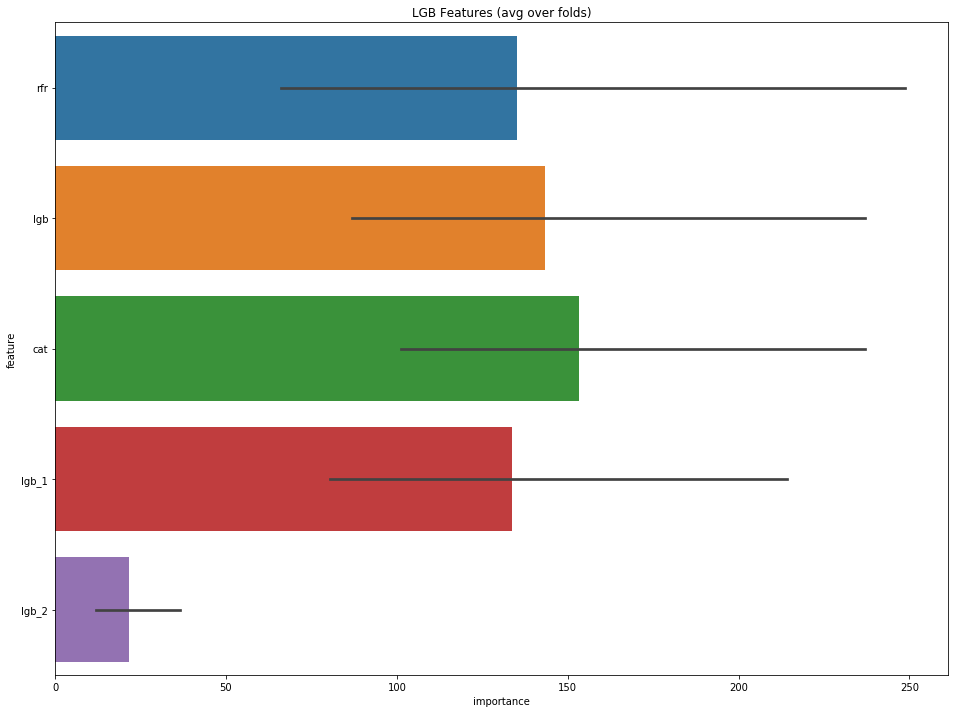

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:14:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[488]	training's rmse: 2.38748	valid_1's rmse: 2.20706
Fold 1 started at Tue Dec 17 11:14:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 2.55849	valid_1's rmse: 2.39902
Fold 2 started at Tue Dec 17 11:14:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.45834	valid_1's rmse: 2.77453
Fold 3 started at Tue Dec 17 11:14:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[682]	training's rmse: 2.28817	valid_1's rmse: 2.53316
Fold 4 started at Tue Dec 17 11:14:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.10357	valid_1's rmse: 3.78871
Early stopping, best iteration is:
[1037]	training's r

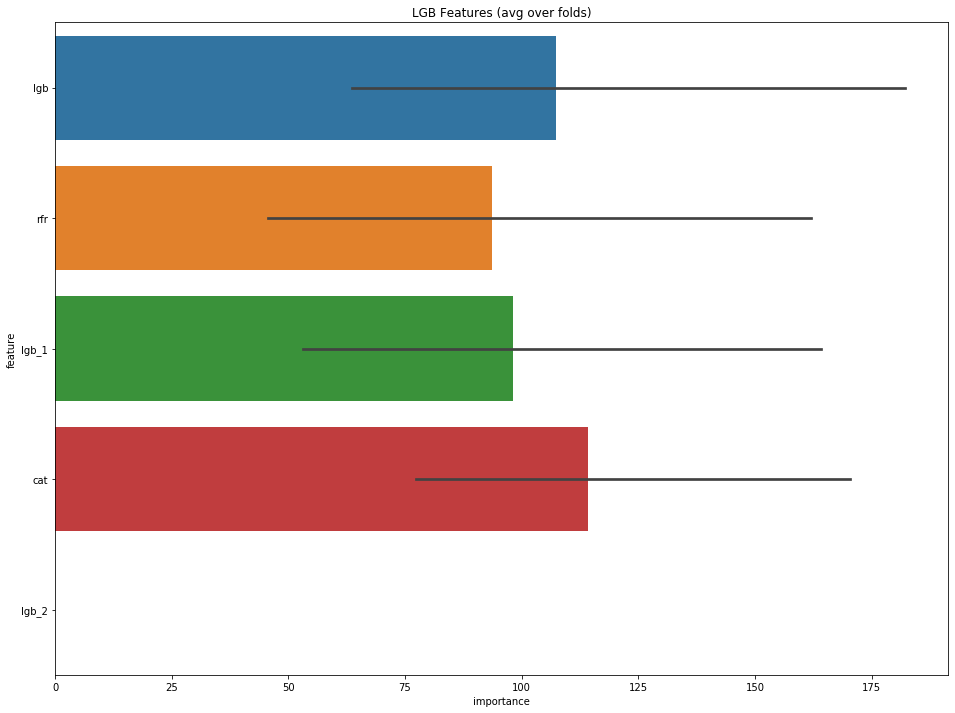

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:15:30 2019
Fold 1 started at Tue Dec 17 11:15:50 2019
Fold 2 started at Tue Dec 17 11:15:58 2019
Fold 3 started at Tue Dec 17 11:16:03 2019
Fold 4 started at Tue Dec 17 11:16:09 2019
Fold 5 started at Tue Dec 17 11:16:42 2019
Fold 6 started at Tue Dec 17 11:16:55 2019
Fold 7 started at Tue Dec 17 11:17:17 2019
Fold 8 started at Tue Dec 17 11:17:24 2019
Fold 9 started at Tue Dec 17 11:17:34 2019
CV mean score: 2.6549, std: 0.4845.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:17:43 2019
Fold 1 started at Tue Dec 17 11:17:44 2019
Fold 2 started at Tue Dec 17 11:17:44 2019
Fold 3 started at Tue Dec 17 11:17:44 2019
Fold 4 started at Tue Dec 17 11:17:44 2019
Fold 5 started at Tue Dec 17 11:17:45 2019
Fold 6 started at Tue Dec 17 11:17:45 2019
Fold 7 started at Tue Dec 17 11:17:45 2019
Fold 8 started at Tue Dec 17 11:17:45 2019
Fold 9 started at Tue Dec 17 11:17:46 2019
CV mean score: 2.7635, std: 0.4448.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:17:46 2019
[0]	train-rmse:23.9861	valid_data-rmse:24.1049
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.28322	valid_data-rmse:2.04769
Stopping. Best iteration:
[521]	train-rmse:1.23126	valid_data-rmse:2.03627

Fold 1 started at Tue Dec 17 11:17:46 2019
[0]	train-rmse:24.1974	valid_data-rmse:22.1776
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.28456	valid_data-rmse:2.70884
Stopping. Best iteration:
[357]	train-rmse:1.83397	valid_data-rmse:2.62725

Fold 2 started at Tue Dec 17 11:17:47 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8622
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:17:50 2019
Fold 1 started at Tue Dec 17 11:17:50 2019
Fold 2 started at Tue Dec 17 11:17:50 2019
Fold 3 started at Tue Dec 17 11:17:50 2019
Fold 4 started at Tue Dec 17 11:17:50 2019
Fold 5 started at Tue Dec 17 11:17:50 2019
Fold 6 started at Tue Dec 17 11:17:50 2019
Fold 7 started at Tue Dec 17 11:17:50 2019
Fold 8 started at Tue Dec 17 11:17:50 2019
Fold 9 started at Tue Dec 17 11:17:50 2019
CV mean score: 3.7970, std: 0.8436.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:17:50 2019
Fold 1 started at Tue Dec 17 11:17:50 2019
Fold 2 started at Tue Dec 17 11:17:50 2019
Fold 3 started at Tue Dec 17 11:17:50 2019
Fold 4 started at Tue Dec 17 11:17:50 2019
Fold 5 started at Tue Dec 17 11:17:51 2019
Fold 6 started at Tue Dec 17 11:17:51 2019
Fold 7 started at Tue Dec 17 11:17:51 2019
Fold 8 started at Tue Dec 17 11:17:51 2019
Fold 9 started at Tue Dec 17 11:17:51 2019
CV mean score: 2.6160, std: 0.4172.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:17:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[359]	training's rmse: 2.32641	valid_1's rmse: 2.3349
Fold 1 started at Tue Dec 17 11:17:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 2.54313	valid_1's rmse: 2.40266
Fold 2 started at Tue Dec 17 11:18:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.46463	valid_1's rmse: 2.81906
Fold 3 started at Tue Dec 17 11:18:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's rmse: 2.2625	valid_1's rmse: 2.64038
Fold 4 started at Tue Dec 17 11:18:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 2.12815	valid_1's rmse: 3.77269
Fold 5 started at Tue 

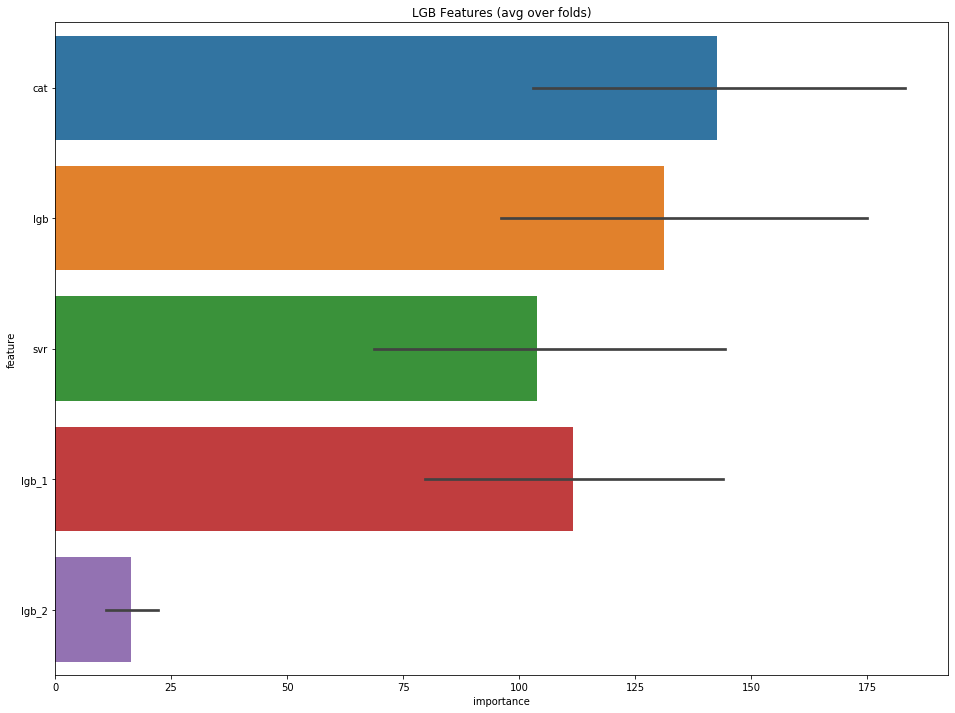

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:19:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[566]	training's rmse: 2.33599	valid_1's rmse: 2.29957
Fold 1 started at Tue Dec 17 11:19:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.53777	valid_1's rmse: 2.36793
Fold 2 started at Tue Dec 17 11:19:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 2.53899	valid_1's rmse: 2.8337
Fold 3 started at Tue Dec 17 11:19:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.36785	valid_1's rmse: 2.62032
Fold 4 started at Tue Dec 17 11:19:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.06638	valid_1's rmse: 3.75648
Early stopping, best iteration is:
[1235]	training's rm

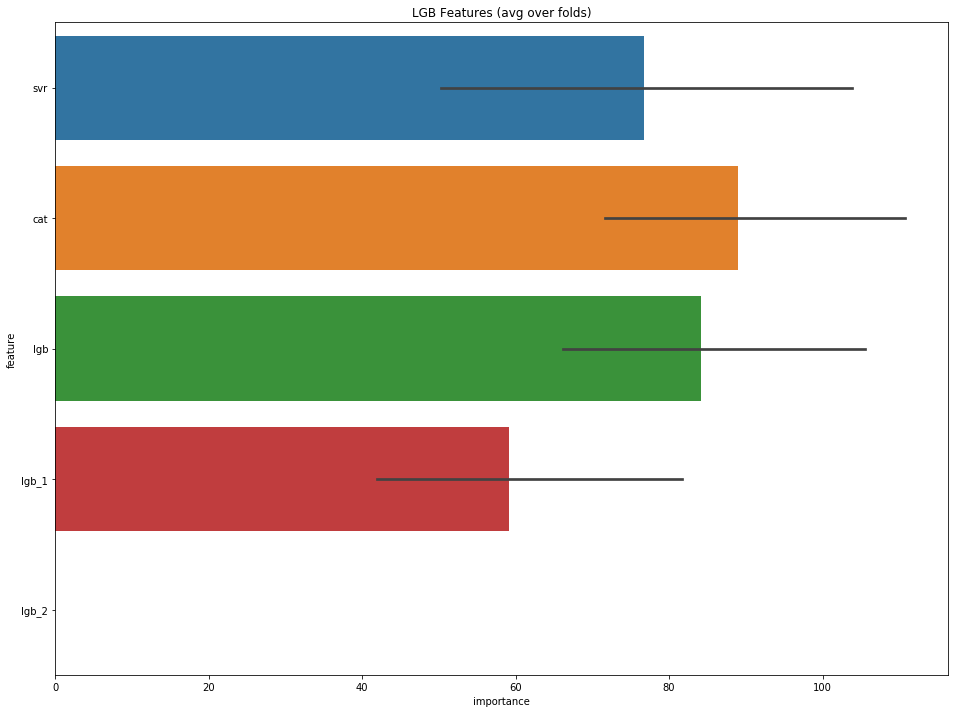

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:19:54 2019
Fold 1 started at Tue Dec 17 11:20:15 2019
Fold 2 started at Tue Dec 17 11:20:21 2019
Fold 3 started at Tue Dec 17 11:20:27 2019
Fold 4 started at Tue Dec 17 11:20:32 2019
Fold 5 started at Tue Dec 17 11:21:09 2019
Fold 6 started at Tue Dec 17 11:21:23 2019
Fold 7 started at Tue Dec 17 11:21:41 2019
Fold 8 started at Tue Dec 17 11:21:50 2019
Fold 9 started at Tue Dec 17 11:22:02 2019
CV mean score: 2.6485, std: 0.4387.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:22:12 2019
Fold 1 started at Tue Dec 17 11:22:13 2019
Fold 2 started at Tue Dec 17 11:22:13 2019
Fold 3 started at Tue Dec 17 11:22:13 2019
Fold 4 started at Tue Dec 17 11:22:13 2019
Fold 5 started at Tue Dec 17 11:22:14 2019
Fold 6 started at Tue Dec 17 11:22:14 2019
Fold 7 started at Tue Dec 17 11:22:14 2019
Fold 8 started at Tue Dec 17 11:22:14 2019
Fold 9 started at Tue Dec 17 11:22:14 2019
CV mean score: 2.8084, std: 0.4475.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:22:15 2019
[0]	train-rmse:23.9861	valid_data-rmse:24.1049
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.31174	valid_data-rmse:2.02409
Stopping. Best iteration:
[521]	train-rmse:1.2618	valid_data-rmse:2.01619

Fold 1 started at Tue Dec 17 11:22:15 2019
[0]	train-rmse:24.1974	valid_data-rmse:22.1776
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.26039	valid_data-rmse:2.55875
Stopping. Best iteration:
[434]	train-rmse:1.45928	valid_data-rmse:2.54436

Fold 2 started at Tue Dec 17 11:22:15 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8622
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:22:19 2019
Fold 1 started at Tue Dec 17 11:22:19 2019
Fold 2 started at Tue Dec 17 11:22:19 2019
Fold 3 started at Tue Dec 17 11:22:19 2019
Fold 4 started at Tue Dec 17 11:22:19 2019
Fold 5 started at Tue Dec 17 11:22:19 2019
Fold 6 started at Tue Dec 17 11:22:19 2019
Fold 7 started at Tue Dec 17 11:22:19 2019
Fold 8 started at Tue Dec 17 11:22:19 2019
Fold 9 started at Tue Dec 17 11:22:19 2019
CV mean score: 3.5126, std: 0.8204.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:22:19 2019
Fold 1 started at Tue Dec 17 11:22:19 2019
Fold 2 started at Tue Dec 17 11:22:19 2019
Fold 3 started at Tue Dec 17 11:22:19 2019
Fold 4 started at Tue Dec 17 11:22:20 2019
Fold 5 started at Tue Dec 17 11:22:20 2019
Fold 6 started at Tue Dec 17 11:22:20 2019
Fold 7 started at Tue Dec 17 11:22:20 2019
Fold 8 started at Tue Dec 17 11:22:20 2019
Fold 9 started at Tue Dec 17 11:22:20 2019
CV mean score: 2.6101, std: 0.4406.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:22:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[338]	training's rmse: 2.40456	valid_1's rmse: 2.33105
Fold 1 started at Tue Dec 17 11:22:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.55329	valid_1's rmse: 2.58516
Fold 2 started at Tue Dec 17 11:22:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[202]	training's rmse: 2.61251	valid_1's rmse: 2.96617
Fold 3 started at Tue Dec 17 11:22:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 2.35036	valid_1's rmse: 2.82482
Fold 4 started at Tue Dec 17 11:22:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 2.21777	valid_1's rmse: 3.87264
Fold 5 started at Tu

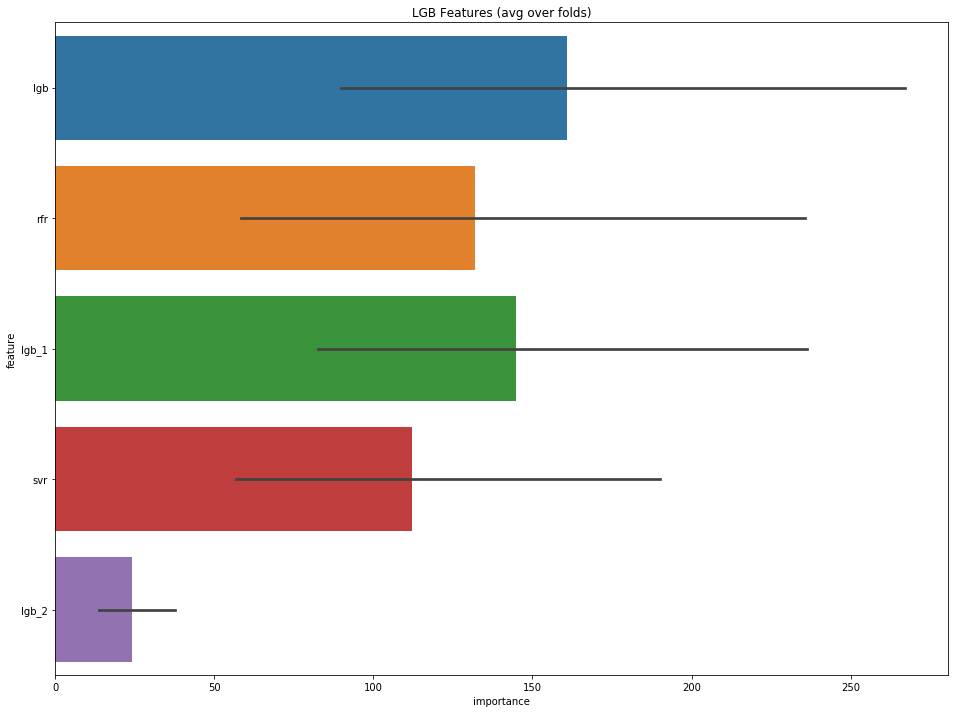

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:23:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[604]	training's rmse: 2.38659	valid_1's rmse: 2.28959
Fold 1 started at Tue Dec 17 11:23:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 2.59364	valid_1's rmse: 2.57902
Fold 2 started at Tue Dec 17 11:23:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's rmse: 2.67978	valid_1's rmse: 2.96807
Fold 3 started at Tue Dec 17 11:23:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[327]	training's rmse: 2.41826	valid_1's rmse: 2.86217
Fold 4 started at Tue Dec 17 11:23:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 2.19427	valid_1's rmse: 3.89809
Fold 5 started at Tu

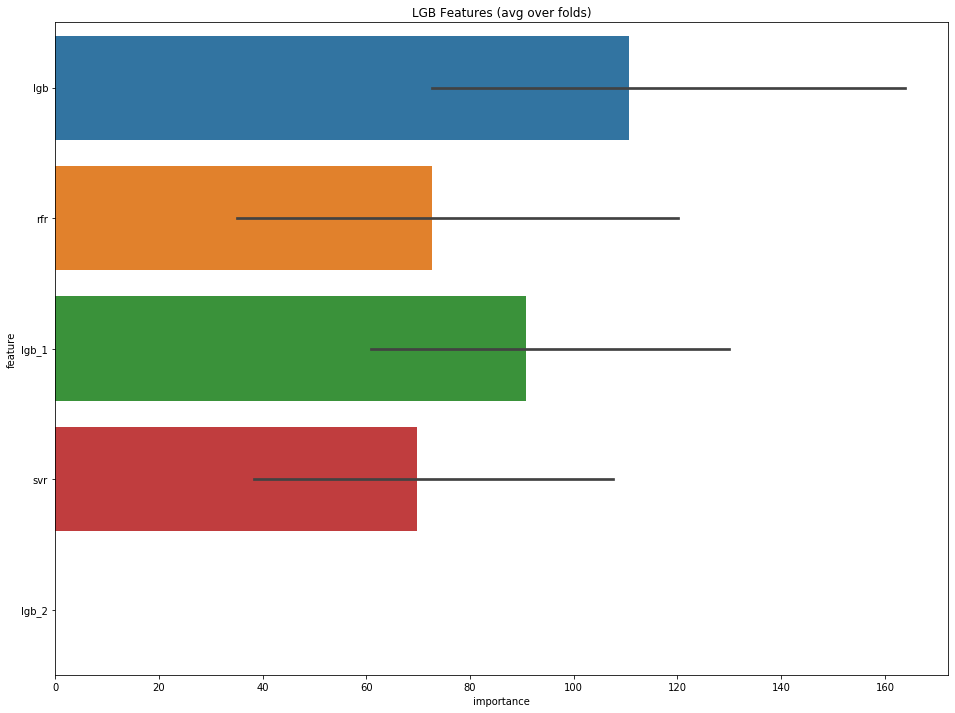

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:24:20 2019
Fold 1 started at Tue Dec 17 11:24:39 2019
Fold 2 started at Tue Dec 17 11:24:45 2019
Fold 3 started at Tue Dec 17 11:24:51 2019
Fold 4 started at Tue Dec 17 11:24:57 2019
Fold 5 started at Tue Dec 17 11:25:06 2019
Fold 6 started at Tue Dec 17 11:25:55 2019
Fold 7 started at Tue Dec 17 11:26:52 2019
Fold 8 started at Tue Dec 17 11:27:00 2019
Fold 9 started at Tue Dec 17 11:27:14 2019
CV mean score: 2.6666, std: 0.4772.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:27:22 2019
Fold 1 started at Tue Dec 17 11:27:23 2019
Fold 2 started at Tue Dec 17 11:27:23 2019
Fold 3 started at Tue Dec 17 11:27:23 2019
Fold 4 started at Tue Dec 17 11:27:23 2019
Fold 5 started at Tue Dec 17 11:27:24 2019
Fold 6 started at Tue Dec 17 11:27:24 2019
Fold 7 started at Tue Dec 17 11:27:24 2019
Fold 8 started at Tue Dec 17 11:27:24 2019
Fold 9 started at Tue Dec 17 11:27:25 2019
CV mean score: 2.8664, std: 0.4587.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:27:25 2019
[0]	train-rmse:23.9868	valid_data-rmse:24.112
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.31274	valid_data-rmse:2.32413
Stopping. Best iteration:
[460]	train-rmse:1.42313	valid_data-rmse:2.30724

Fold 1 started at Tue Dec 17 11:27:25 2019
[0]	train-rmse:24.1977	valid_data-rmse:22.1729
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.29562	valid_data-rmse:2.85623
Stopping. Best iteration:
[357]	train-rmse:1.8572	valid_data-rmse:2.81341

Fold 2 started at Tue Dec 17 11:27:25 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8669
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best 

##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:27:29 2019
Fold 1 started at Tue Dec 17 11:27:29 2019
Fold 2 started at Tue Dec 17 11:27:29 2019
Fold 3 started at Tue Dec 17 11:27:29 2019
Fold 4 started at Tue Dec 17 11:27:29 2019
Fold 5 started at Tue Dec 17 11:27:29 2019
Fold 6 started at Tue Dec 17 11:27:29 2019
Fold 7 started at Tue Dec 17 11:27:29 2019
Fold 8 started at Tue Dec 17 11:27:29 2019
Fold 9 started at Tue Dec 17 11:27:29 2019
CV mean score: 3.6701, std: 0.8051.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:27:29 2019
Fold 1 started at Tue Dec 17 11:27:29 2019
Fold 2 started at Tue Dec 17 11:27:29 2019
Fold 3 started at Tue Dec 17 11:27:29 2019
Fold 4 started at Tue Dec 17 11:27:29 2019
Fold 5 started at Tue Dec 17 11:27:29 2019
Fold 6 started at Tue Dec 17 11:27:30 2019
Fold 7 started at Tue Dec 17 11:27:30 2019
Fold 8 started at Tue Dec 17 11:27:30 2019
Fold 9 started at Tue Dec 17 11:27:30 2019
CV mean score: 2.6669, std: 0.4791.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:27:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 2.31628	valid_1's rmse: 2.28222
Fold 1 started at Tue Dec 17 11:27:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.44626	valid_1's rmse: 2.37965
Fold 2 started at Tue Dec 17 11:27:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 2.42877	valid_1's rmse: 2.73356
Fold 3 started at Tue Dec 17 11:27:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[373]	training's rmse: 2.30194	valid_1's rmse: 2.57282
Fold 4 started at Tue Dec 17 11:27:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 2.18456	valid_1's rmse: 3.90498
Fold 5 started at Tu

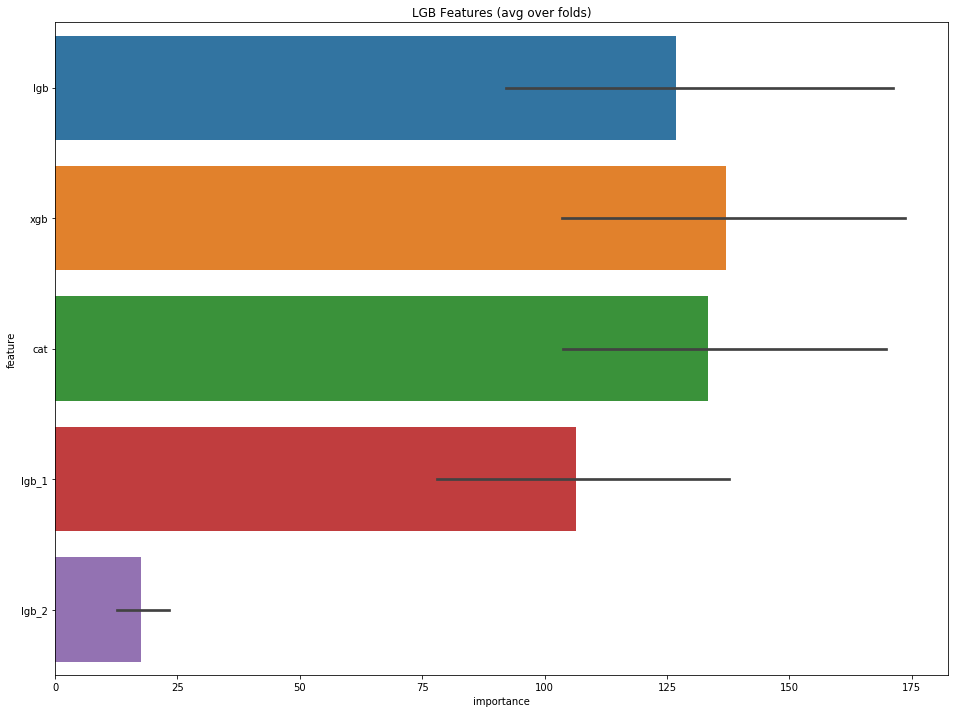

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:28:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[366]	training's rmse: 2.41178	valid_1's rmse: 2.25673
Fold 1 started at Tue Dec 17 11:28:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[285]	training's rmse: 2.48217	valid_1's rmse: 2.3391
Fold 2 started at Tue Dec 17 11:28:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 2.48684	valid_1's rmse: 2.7226
Fold 3 started at Tue Dec 17 11:28:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 2.33814	valid_1's rmse: 2.54704
Fold 4 started at Tue Dec 17 11:28:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.19649	valid_1's rmse: 3.92663
Fold 5 started at Tue 

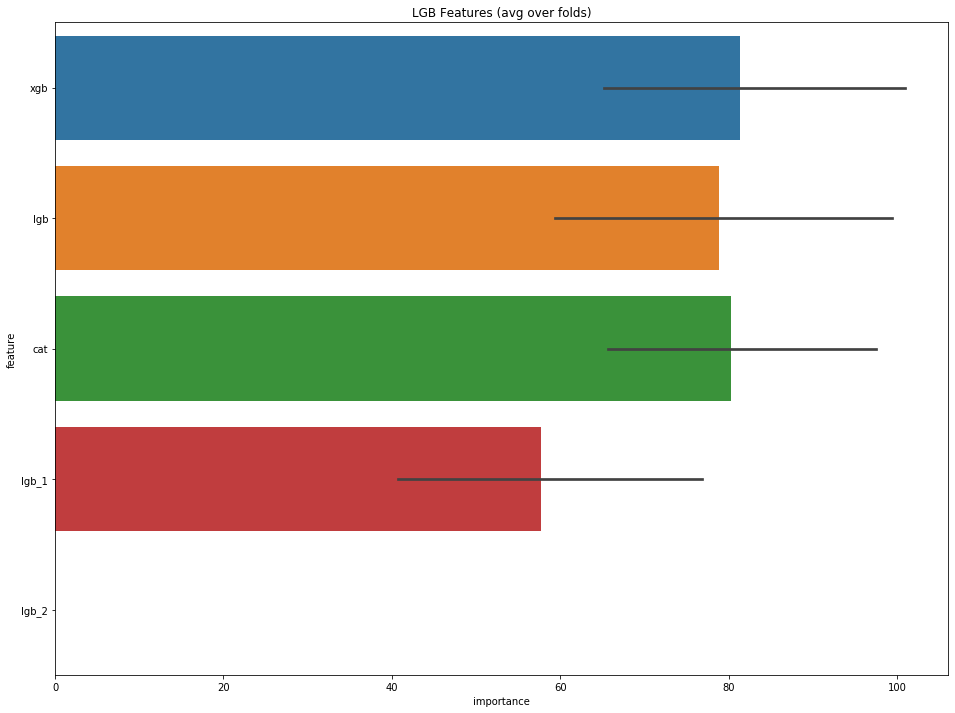

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:28:58 2019
Fold 1 started at Tue Dec 17 11:29:08 2019
Fold 2 started at Tue Dec 17 11:29:15 2019
Fold 3 started at Tue Dec 17 11:29:20 2019
Fold 4 started at Tue Dec 17 11:29:26 2019
Fold 5 started at Tue Dec 17 11:29:42 2019
Fold 6 started at Tue Dec 17 11:29:56 2019
Fold 7 started at Tue Dec 17 11:30:13 2019
Fold 8 started at Tue Dec 17 11:30:20 2019
Fold 9 started at Tue Dec 17 11:30:27 2019
CV mean score: 2.6551, std: 0.4669.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:30:36 2019
Fold 1 started at Tue Dec 17 11:30:36 2019
Fold 2 started at Tue Dec 17 11:30:36 2019
Fold 3 started at Tue Dec 17 11:30:37 2019
Fold 4 started at Tue Dec 17 11:30:37 2019
Fold 5 started at Tue Dec 17 11:30:37 2019
Fold 6 started at Tue Dec 17 11:30:37 2019
Fold 7 started at Tue Dec 17 11:30:38 2019
Fold 8 started at Tue Dec 17 11:30:38 2019
Fold 9 started at Tue Dec 17 11:30:38 2019
CV mean score: 2.6840, std: 0.4963.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:30:38 2019
[0]	train-rmse:23.9861	valid_data-rmse:24.1049
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.33191	valid_data-rmse:2.22533
Stopping. Best iteration:
[516]	train-rmse:1.29365	valid_data-rmse:2.21824

Fold 1 started at Tue Dec 17 11:30:39 2019
[0]	train-rmse:24.1967	valid_data-rmse:22.1748
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.30905	valid_data-rmse:2.53836
Stopping. Best iteration:
[387]	train-rmse:1.68844	valid_data-rmse:2.49611

Fold 2 started at Tue Dec 17 11:30:39 2019
[0]	train-rmse:24.0119	valid_data-rmse:23.8631
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:30:42 2019
Fold 1 started at Tue Dec 17 11:30:42 2019
Fold 2 started at Tue Dec 17 11:30:42 2019
Fold 3 started at Tue Dec 17 11:30:42 2019
Fold 4 started at Tue Dec 17 11:30:42 2019
Fold 5 started at Tue Dec 17 11:30:42 2019
Fold 6 started at Tue Dec 17 11:30:42 2019
Fold 7 started at Tue Dec 17 11:30:42 2019
Fold 8 started at Tue Dec 17 11:30:42 2019
Fold 9 started at Tue Dec 17 11:30:42 2019
CV mean score: 3.7461, std: 0.9002.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:30:42 2019
Fold 1 started at Tue Dec 17 11:30:42 2019
Fold 2 started at Tue Dec 17 11:30:42 2019
Fold 3 started at Tue Dec 17 11:30:42 2019
Fold 4 started at Tue Dec 17 11:30:42 2019
Fold 5 started at Tue Dec 17 11:30:43 2019
Fold 6 started at Tue Dec 17 11:30:43 2019
Fold 7 started at Tue Dec 17 11:30:43 2019
Fold 8 started at Tue Dec 17 11:30:43 2019
Fold 9 started at Tue Dec 17 11:30:43 2019
CV mean score: 2.5936, std: 0.4475.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:30:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.35947	valid_1's rmse: 2.26222
Fold 1 started at Tue Dec 17 11:30:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 2.60913	valid_1's rmse: 2.52905
Fold 2 started at Tue Dec 17 11:30:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 2.49881	valid_1's rmse: 2.84212
Fold 3 started at Tue Dec 17 11:30:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[625]	training's rmse: 2.21261	valid_1's rmse: 2.63071
Fold 4 started at Tue Dec 17 11:31:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 2.27052	valid_1's rmse: 3.99291
Fold 5 started at Tu

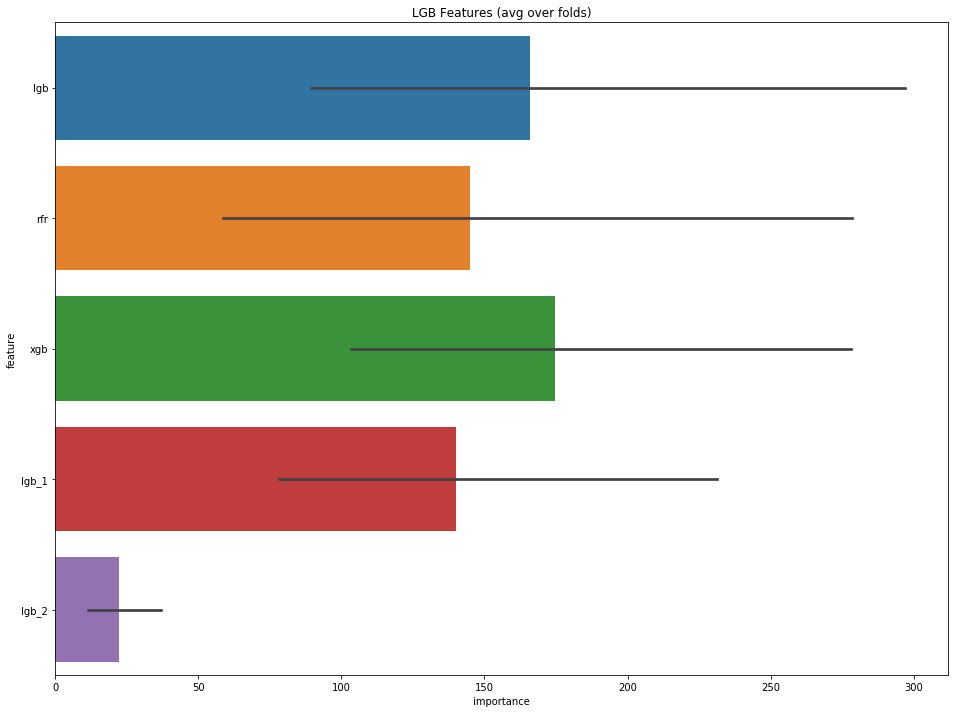

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:32:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 2.41513	valid_1's rmse: 2.25904
Fold 1 started at Tue Dec 17 11:32:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[244]	training's rmse: 2.58716	valid_1's rmse: 2.50553
Fold 2 started at Tue Dec 17 11:32:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 2.52884	valid_1's rmse: 2.8471
Fold 3 started at Tue Dec 17 11:32:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[459]	training's rmse: 2.37619	valid_1's rmse: 2.66114
Fold 4 started at Tue Dec 17 11:32:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 2.26186	valid_1's rmse: 4.00289
Fold 5 started at Tue

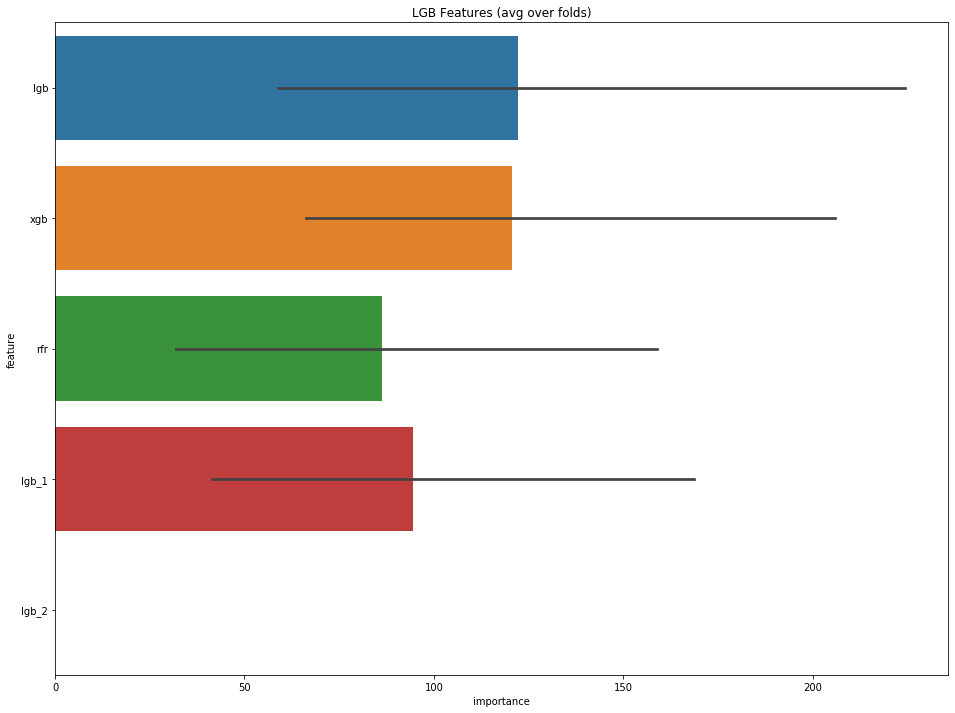

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:33:00 2019
Fold 1 started at Tue Dec 17 11:33:16 2019
Fold 2 started at Tue Dec 17 11:33:23 2019
Fold 3 started at Tue Dec 17 11:33:29 2019
Fold 4 started at Tue Dec 17 11:33:34 2019
Fold 5 started at Tue Dec 17 11:33:50 2019
Fold 6 started at Tue Dec 17 11:34:22 2019
Fold 7 started at Tue Dec 17 11:35:05 2019
Fold 8 started at Tue Dec 17 11:35:11 2019
Fold 9 started at Tue Dec 17 11:35:19 2019
CV mean score: 2.6656, std: 0.4761.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:35:27 2019
Fold 1 started at Tue Dec 17 11:35:27 2019
Fold 2 started at Tue Dec 17 11:35:27 2019
Fold 3 started at Tue Dec 17 11:35:27 2019
Fold 4 started at Tue Dec 17 11:35:28 2019
Fold 5 started at Tue Dec 17 11:35:28 2019
Fold 6 started at Tue Dec 17 11:35:28 2019
Fold 7 started at Tue Dec 17 11:35:28 2019
Fold 8 started at Tue Dec 17 11:35:29 2019
Fold 9 started at Tue Dec 17 11:35:29 2019
CV mean score: 2.7750, std: 0.4828.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:35:29 2019
[0]	train-rmse:23.9861	valid_data-rmse:24.1089
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.32567	valid_data-rmse:2.41579
Stopping. Best iteration:
[471]	train-rmse:1.40286	valid_data-rmse:2.40315

Fold 1 started at Tue Dec 17 11:35:30 2019
[0]	train-rmse:24.1973	valid_data-rmse:22.1716
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.33113	valid_data-rmse:2.69083
Stopping. Best iteration:
[358]	train-rmse:1.87124	valid_data-rmse:2.61415

Fold 2 started at Tue Dec 17 11:35:30 2019
[0]	train-rmse:24.0118	valid_data-rmse:23.866
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:35:33 2019
Fold 1 started at Tue Dec 17 11:35:33 2019
Fold 2 started at Tue Dec 17 11:35:33 2019
Fold 3 started at Tue Dec 17 11:35:33 2019
Fold 4 started at Tue Dec 17 11:35:34 2019
Fold 5 started at Tue Dec 17 11:35:34 2019
Fold 6 started at Tue Dec 17 11:35:34 2019
Fold 7 started at Tue Dec 17 11:35:34 2019
Fold 8 started at Tue Dec 17 11:35:34 2019
Fold 9 started at Tue Dec 17 11:35:34 2019
CV mean score: 3.8600, std: 0.8744.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:35:34 2019
Fold 1 started at Tue Dec 17 11:35:34 2019
Fold 2 started at Tue Dec 17 11:35:34 2019
Fold 3 started at Tue Dec 17 11:35:34 2019
Fold 4 started at Tue Dec 17 11:35:34 2019
Fold 5 started at Tue Dec 17 11:35:34 2019
Fold 6 started at Tue Dec 17 11:35:34 2019
Fold 7 started at Tue Dec 17 11:35:34 2019
Fold 8 started at Tue Dec 17 11:35:35 2019
Fold 9 started at Tue Dec 17 11:35:35 2019
CV mean score: 2.6315, std: 0.4677.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:35:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.37758	valid_1's rmse: 2.37578
Fold 1 started at Tue Dec 17 11:35:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	training's rmse: 2.54746	valid_1's rmse: 2.47567
Fold 2 started at Tue Dec 17 11:35:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.5124	valid_1's rmse: 2.8734
Fold 3 started at Tue Dec 17 11:35:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 2.32772	valid_1's rmse: 2.69528
Fold 4 started at Tue Dec 17 11:35:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 2.22355	valid_1's rmse: 3.97718
Fold 5 started at Tue 

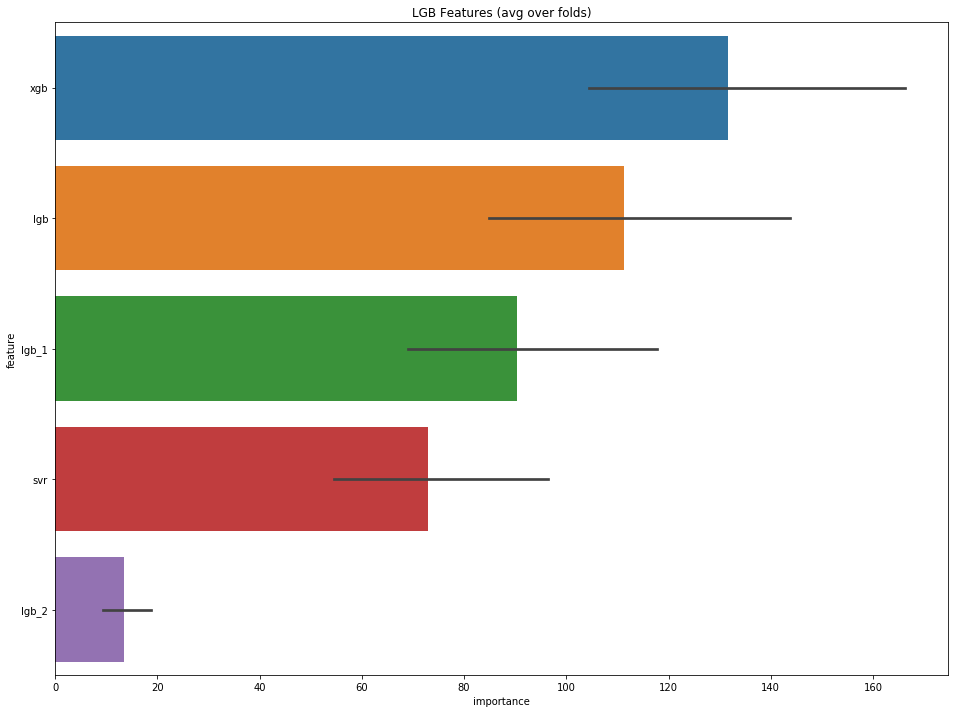

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:36:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[412]	training's rmse: 2.40204	valid_1's rmse: 2.35387
Fold 1 started at Tue Dec 17 11:36:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[274]	training's rmse: 2.51893	valid_1's rmse: 2.43871
Fold 2 started at Tue Dec 17 11:36:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[210]	training's rmse: 2.59301	valid_1's rmse: 2.88632
Fold 3 started at Tue Dec 17 11:36:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[318]	training's rmse: 2.41396	valid_1's rmse: 2.71172
Fold 4 started at Tue Dec 17 11:36:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 2.27412	valid_1's rmse: 4.03485
Fold 5 started at Tu

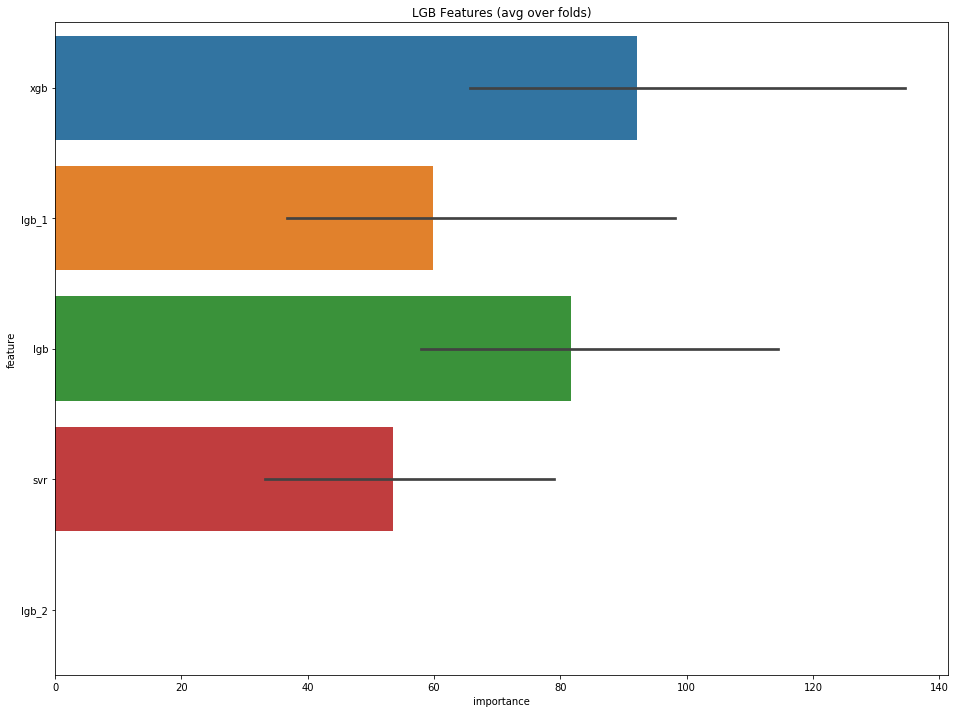

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:37:27 2019
Fold 1 started at Tue Dec 17 11:37:48 2019
Fold 2 started at Tue Dec 17 11:37:55 2019
Fold 3 started at Tue Dec 17 11:38:01 2019
Fold 4 started at Tue Dec 17 11:38:07 2019
Fold 5 started at Tue Dec 17 11:38:24 2019
Fold 6 started at Tue Dec 17 11:39:18 2019
Fold 7 started at Tue Dec 17 11:39:31 2019
Fold 8 started at Tue Dec 17 11:39:40 2019
Fold 9 started at Tue Dec 17 11:39:48 2019
CV mean score: 2.6600, std: 0.4517.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:39:57 2019
Fold 1 started at Tue Dec 17 11:39:57 2019
Fold 2 started at Tue Dec 17 11:39:57 2019
Fold 3 started at Tue Dec 17 11:39:57 2019
Fold 4 started at Tue Dec 17 11:39:58 2019
Fold 5 started at Tue Dec 17 11:39:58 2019
Fold 6 started at Tue Dec 17 11:39:58 2019
Fold 7 started at Tue Dec 17 11:39:58 2019
Fold 8 started at Tue Dec 17 11:39:59 2019
Fold 9 started at Tue Dec 17 11:39:59 2019
CV mean score: 2.7764, std: 0.4479.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:39:59 2019
[0]	train-rmse:23.9861	valid_data-rmse:24.1089
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.32827	valid_data-rmse:2.45726
Stopping. Best iteration:
[426]	train-rmse:1.55539	valid_data-rmse:2.43797

Fold 1 started at Tue Dec 17 11:39:59 2019
[0]	train-rmse:24.1973	valid_data-rmse:22.1716
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.30889	valid_data-rmse:2.73875
Stopping. Best iteration:
[387]	train-rmse:1.6931	valid_data-rmse:2.6744

Fold 2 started at Tue Dec 17 11:40:00 2019
[0]	train-rmse:24.0118	valid_data-rmse:23.866
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:40:03 2019
Fold 1 started at Tue Dec 17 11:40:03 2019
Fold 2 started at Tue Dec 17 11:40:03 2019
Fold 3 started at Tue Dec 17 11:40:03 2019
Fold 4 started at Tue Dec 17 11:40:03 2019
Fold 5 started at Tue Dec 17 11:40:03 2019
Fold 6 started at Tue Dec 17 11:40:03 2019
Fold 7 started at Tue Dec 17 11:40:03 2019
Fold 8 started at Tue Dec 17 11:40:03 2019
Fold 9 started at Tue Dec 17 11:40:03 2019
CV mean score: 3.5769, std: 0.8537.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:40:03 2019
Fold 1 started at Tue Dec 17 11:40:03 2019
Fold 2 started at Tue Dec 17 11:40:03 2019
Fold 3 started at Tue Dec 17 11:40:03 2019
Fold 4 started at Tue Dec 17 11:40:03 2019
Fold 5 started at Tue Dec 17 11:40:04 2019
Fold 6 started at Tue Dec 17 11:40:04 2019
Fold 7 started at Tue Dec 17 11:40:04 2019
Fold 8 started at Tue Dec 17 11:40:04 2019
Fold 9 started at Tue Dec 17 11:40:04 2019
CV mean score: 2.6198, std: 0.4684.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:40:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[568]	training's rmse: 2.54847	valid_1's rmse: 2.4471
Fold 1 started at Tue Dec 17 11:40:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 2.66925	valid_1's rmse: 2.33225
Fold 2 started at Tue Dec 17 11:40:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.69789	valid_1's rmse: 2.78152
Fold 3 started at Tue Dec 17 11:40:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[684]	training's rmse: 2.4919	valid_1's rmse: 2.74203
Fold 4 started at Tue Dec 17 11:40:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.50609	valid_1's rmse: 3.79286
Fold 5 started at Tue 

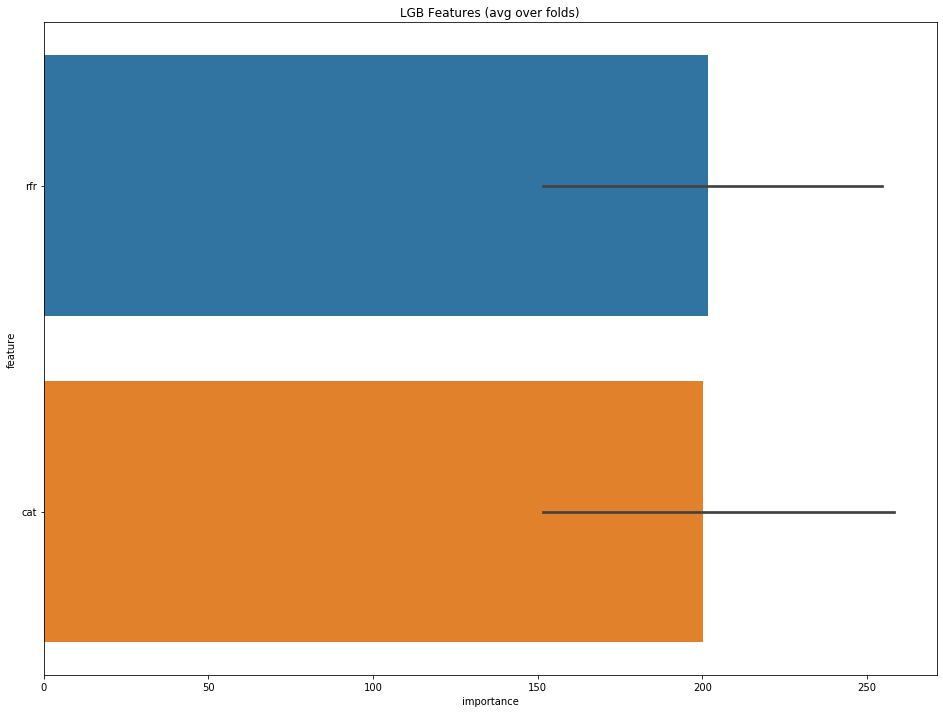

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:41:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[513]	training's rmse: 2.52417	valid_1's rmse: 2.51279
Fold 1 started at Tue Dec 17 11:41:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 2.6721	valid_1's rmse: 2.25066
Fold 2 started at Tue Dec 17 11:41:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 2.61609	valid_1's rmse: 2.75173
Fold 3 started at Tue Dec 17 11:41:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 2.48698	valid_1's rmse: 2.64442
Fold 4 started at Tue Dec 17 11:41:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.31001	valid_1's rmse: 3.76112
Early stopping, best iteration is:
[812]	training's rms

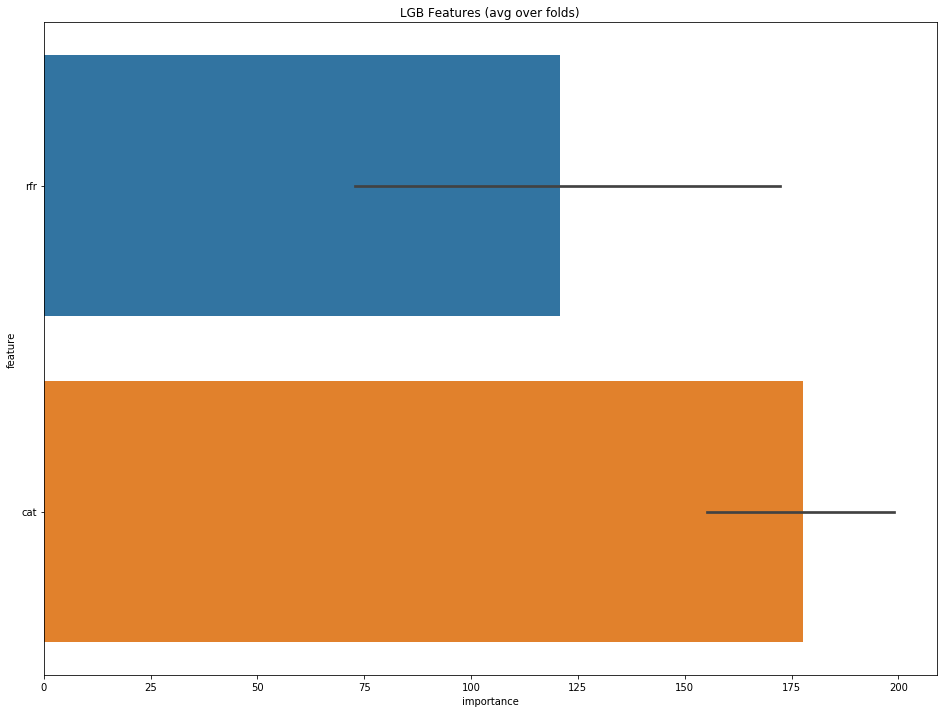

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:41:37 2019
Fold 1 started at Tue Dec 17 11:41:47 2019
Fold 2 started at Tue Dec 17 11:41:56 2019
Fold 3 started at Tue Dec 17 11:42:01 2019
Fold 4 started at Tue Dec 17 11:42:54 2019
Fold 5 started at Tue Dec 17 11:43:19 2019
Fold 6 started at Tue Dec 17 11:43:30 2019
Fold 7 started at Tue Dec 17 11:43:55 2019
Fold 8 started at Tue Dec 17 11:44:02 2019
Fold 9 started at Tue Dec 17 11:44:08 2019
CV mean score: 2.7013, std: 0.5006.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:44:17 2019
Fold 1 started at Tue Dec 17 11:44:17 2019
Fold 2 started at Tue Dec 17 11:44:17 2019
Fold 3 started at Tue Dec 17 11:44:18 2019
Fold 4 started at Tue Dec 17 11:44:18 2019
Fold 5 started at Tue Dec 17 11:44:18 2019
Fold 6 started at Tue Dec 17 11:44:18 2019
Fold 7 started at Tue Dec 17 11:44:19 2019
Fold 8 started at Tue Dec 17 11:44:19 2019
Fold 9 started at Tue Dec 17 11:44:19 2019
CV mean score: 2.9101, std: 0.4848.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:44:19 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.67147	valid_data-rmse:2.74411
Stopping. Best iteration:
[348]	train-rmse:2.20943	valid_data-rmse:2.62634

Fold 1 started at Tue Dec 17 11:44:19 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68234	valid_data-rmse:2.31751
Stopping. Best iteration:
[646]	train-rmse:1.43981	valid_data-rmse:2.29571

Fold 2 started at Tue Dec 17 11:44:20 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8621
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:44:21 2019
Fold 1 started at Tue Dec 17 11:44:21 2019
Fold 2 started at Tue Dec 17 11:44:21 2019
Fold 3 started at Tue Dec 17 11:44:21 2019
Fold 4 started at Tue Dec 17 11:44:21 2019
Fold 5 started at Tue Dec 17 11:44:21 2019
Fold 6 started at Tue Dec 17 11:44:22 2019
Fold 7 started at Tue Dec 17 11:44:22 2019
Fold 8 started at Tue Dec 17 11:44:22 2019
Fold 9 started at Tue Dec 17 11:44:22 2019
CV mean score: 3.6209, std: 0.7224.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:44:22 2019
Fold 1 started at Tue Dec 17 11:44:22 2019
Fold 2 started at Tue Dec 17 11:44:22 2019
Fold 3 started at Tue Dec 17 11:44:22 2019
Fold 4 started at Tue Dec 17 11:44:22 2019
Fold 5 started at Tue Dec 17 11:44:22 2019
Fold 6 started at Tue Dec 17 11:44:22 2019
Fold 7 started at Tue Dec 17 11:44:22 2019
Fold 8 started at Tue Dec 17 11:44:22 2019
Fold 9 started at Tue Dec 17 11:44:22 2019
CV mean score: 2.6457, std: 0.3752.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:44:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.5047	valid_1's rmse: 2.639
[2000]	training's rmse: 2.39601	valid_1's rmse: 2.57855
Early stopping, best iteration is:
[2098]	training's rmse: 2.38835	valid_1's rmse: 2.57259
Fold 1 started at Tue Dec 17 11:44:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[520]	training's rmse: 2.6494	valid_1's rmse: 2.55158
Fold 2 started at Tue Dec 17 11:44:58 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.48236	valid_1's rmse: 3.12094
Early stopping, best iteration is:
[1756]	training's rmse: 2.3938	valid_1's rmse: 3.02736
Fold 3 started at Tue Dec 17 11:45:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.49287	valid_1's rmse: 2.80707
Early stopping, best iteration is:
[1225]	training's rmse: 2.46162	valid_1's rmse: 2.

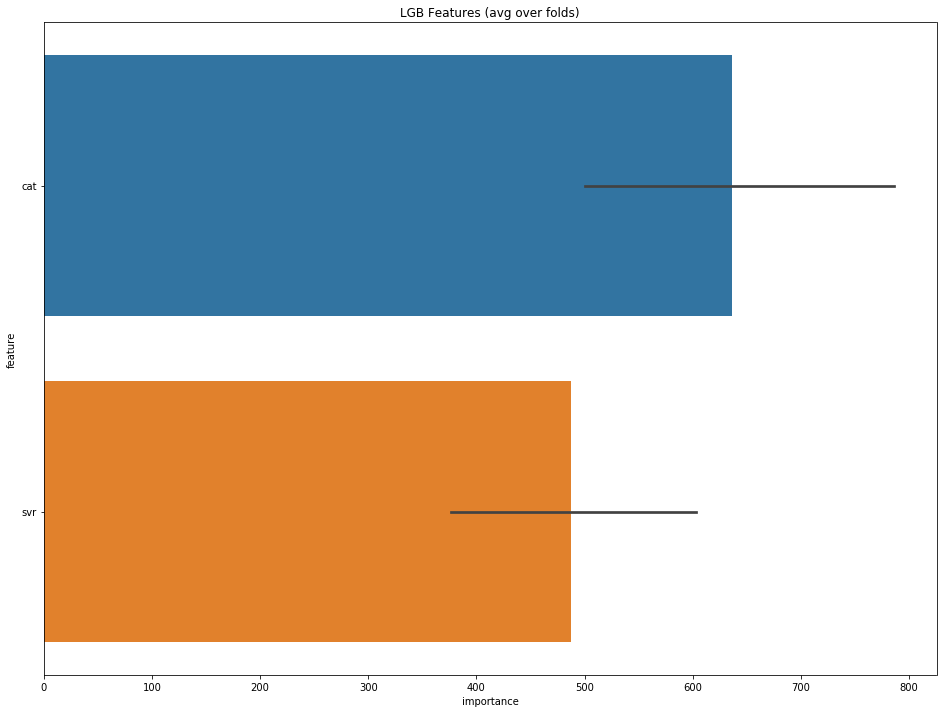

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:46:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[695]	training's rmse: 2.44276	valid_1's rmse: 2.57151
Fold 1 started at Tue Dec 17 11:46:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 2.65628	valid_1's rmse: 2.32007
Fold 2 started at Tue Dec 17 11:46:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.61159	valid_1's rmse: 2.85168
Fold 3 started at Tue Dec 17 11:46:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's rmse: 2.4682	valid_1's rmse: 2.73733
Fold 4 started at Tue Dec 17 11:46:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[495]	training's rmse: 2.31969	valid_1's rmse: 3.68647
Fold 5 started at Tue

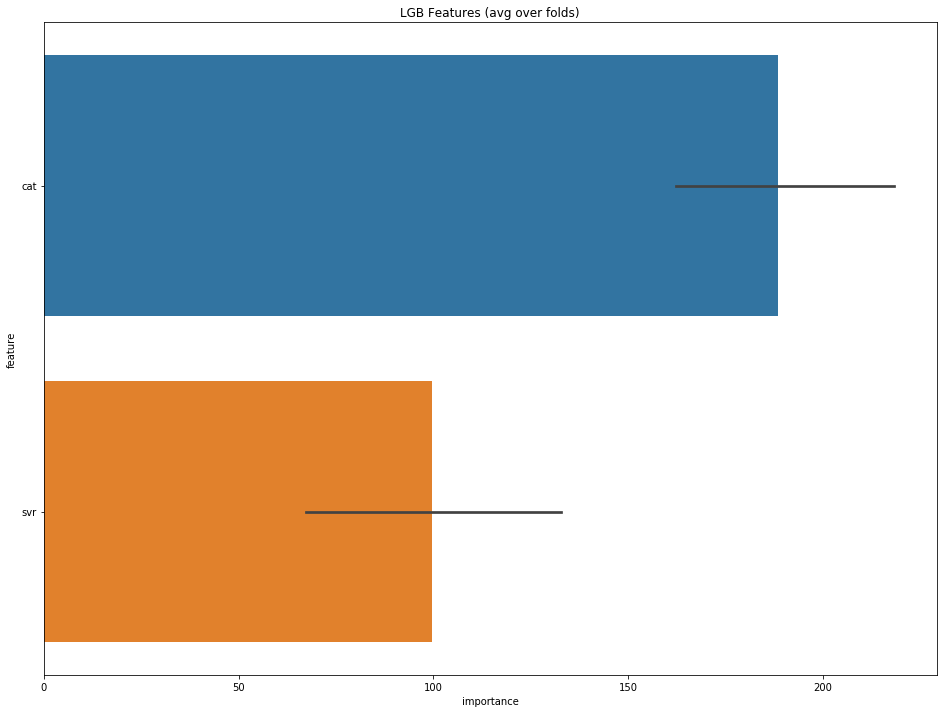

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:47:04 2019
Fold 1 started at Tue Dec 17 11:47:14 2019
Fold 2 started at Tue Dec 17 11:47:25 2019
Fold 3 started at Tue Dec 17 11:47:32 2019
Fold 4 started at Tue Dec 17 11:48:00 2019
Fold 5 started at Tue Dec 17 11:48:24 2019
Fold 6 started at Tue Dec 17 11:48:37 2019
Fold 7 started at Tue Dec 17 11:49:00 2019
Fold 8 started at Tue Dec 17 11:49:37 2019
Fold 9 started at Tue Dec 17 11:49:45 2019
CV mean score: 2.7217, std: 0.3835.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:50:02 2019
Fold 1 started at Tue Dec 17 11:50:02 2019
Fold 2 started at Tue Dec 17 11:50:02 2019
Fold 3 started at Tue Dec 17 11:50:03 2019
Fold 4 started at Tue Dec 17 11:50:03 2019
Fold 5 started at Tue Dec 17 11:50:03 2019
Fold 6 started at Tue Dec 17 11:50:03 2019
Fold 7 started at Tue Dec 17 11:50:03 2019
Fold 8 started at Tue Dec 17 11:50:04 2019
Fold 9 started at Tue Dec 17 11:50:04 2019
CV mean score: 3.2260, std: 0.6181.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:50:04 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.04331	valid_data-rmse:3.10008
Stopping. Best iteration:
[445]	train-rmse:2.19444	valid_data-rmse:3.08694

Fold 1 started at Tue Dec 17 11:50:04 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.05782	valid_data-rmse:2.76006
Stopping. Best iteration:
[674]	train-rmse:1.73966	valid_data-rmse:2.72973

Fold 2 started at Tue Dec 17 11:50:05 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8621
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:50:07 2019
Fold 1 started at Tue Dec 17 11:50:07 2019
Fold 2 started at Tue Dec 17 11:50:07 2019
Fold 3 started at Tue Dec 17 11:50:07 2019
Fold 4 started at Tue Dec 17 11:50:07 2019
Fold 5 started at Tue Dec 17 11:50:07 2019
Fold 6 started at Tue Dec 17 11:50:07 2019
Fold 7 started at Tue Dec 17 11:50:07 2019
Fold 8 started at Tue Dec 17 11:50:07 2019
Fold 9 started at Tue Dec 17 11:50:07 2019
CV mean score: 3.2284, std: 0.7406.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:50:07 2019
Fold 1 started at Tue Dec 17 11:50:07 2019
Fold 2 started at Tue Dec 17 11:50:07 2019
Fold 3 started at Tue Dec 17 11:50:07 2019
Fold 4 started at Tue Dec 17 11:50:07 2019
Fold 5 started at Tue Dec 17 11:50:07 2019
Fold 6 started at Tue Dec 17 11:50:07 2019
Fold 7 started at Tue Dec 17 11:50:07 2019
Fold 8 started at Tue Dec 17 11:50:08 2019
Fold 9 started at Tue Dec 17 11:50:08 2019
CV mean score: 2.6377, std: 0.3947.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:50:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.75304	valid_1's rmse: 2.69013
[2000]	training's rmse: 2.61792	valid_1's rmse: 2.52686
Early stopping, best iteration is:
[2643]	training's rmse: 2.56334	valid_1's rmse: 2.4814
Fold 1 started at Tue Dec 17 11:50:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 2.96543	valid_1's rmse: 3.08538
Fold 2 started at Tue Dec 17 11:50:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.70744	valid_1's rmse: 3.35828
Early stopping, best iteration is:
[876]	training's rmse: 2.73309	valid_1's rmse: 3.35115
Fold 3 started at Tue Dec 17 11:50:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[683]	training's rmse: 2.7704	valid_1's rmse: 3.11812
Fold 4 started at Tue Dec 17 11:50:44 2019
Traini

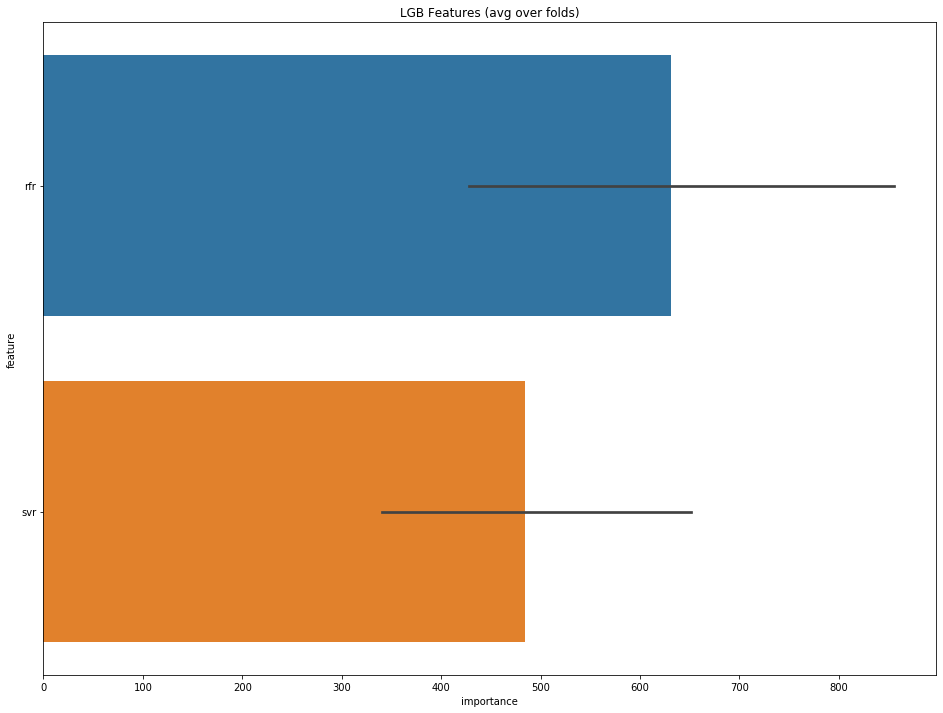

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:52:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.65137	valid_1's rmse: 2.60663
Early stopping, best iteration is:
[961]	training's rmse: 2.65774	valid_1's rmse: 2.59975
Fold 1 started at Tue Dec 17 11:52:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 2.84481	valid_1's rmse: 2.6038
Fold 2 started at Tue Dec 17 11:52:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[182]	training's rmse: 3.03584	valid_1's rmse: 2.95164
Fold 3 started at Tue Dec 17 11:52:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[329]	training's rmse: 2.72725	valid_1's rmse: 3.1837
Fold 4 started at Tue Dec 17 11:52:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse

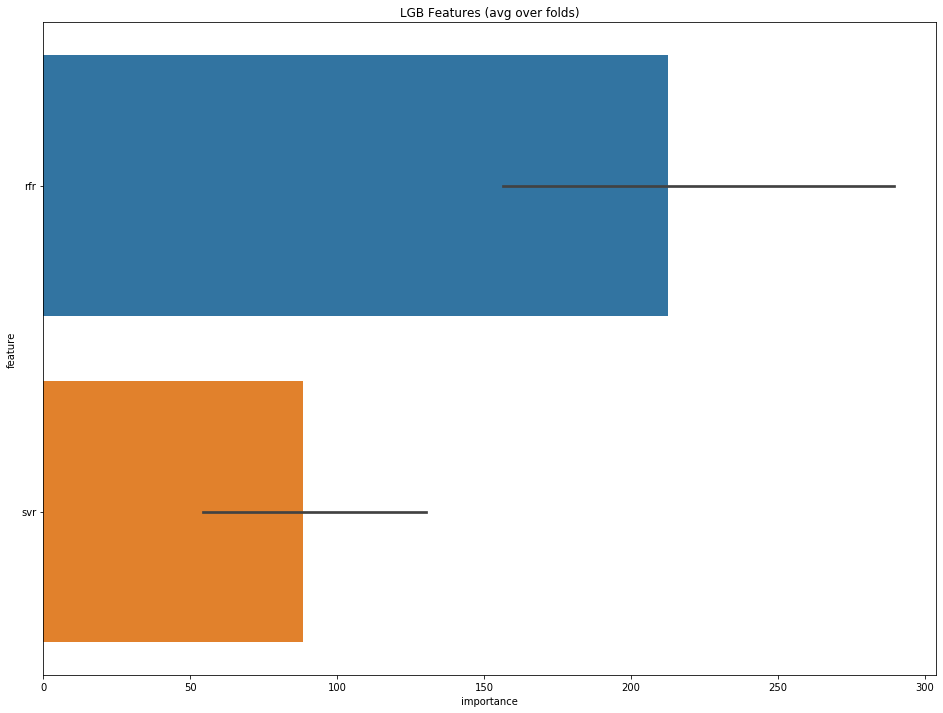

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:52:57 2019
Fold 1 started at Tue Dec 17 11:53:14 2019
Fold 2 started at Tue Dec 17 11:53:22 2019
Fold 3 started at Tue Dec 17 11:53:27 2019
Fold 4 started at Tue Dec 17 11:53:35 2019
Fold 5 started at Tue Dec 17 11:53:42 2019
Fold 6 started at Tue Dec 17 11:53:55 2019
Fold 7 started at Tue Dec 17 11:54:13 2019
Fold 8 started at Tue Dec 17 11:54:48 2019
Fold 9 started at Tue Dec 17 11:54:57 2019
CV mean score: 3.0640, std: 0.4662.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:55:07 2019
Fold 1 started at Tue Dec 17 11:55:08 2019
Fold 2 started at Tue Dec 17 11:55:08 2019
Fold 3 started at Tue Dec 17 11:55:08 2019
Fold 4 started at Tue Dec 17 11:55:08 2019
Fold 5 started at Tue Dec 17 11:55:09 2019
Fold 6 started at Tue Dec 17 11:55:09 2019
Fold 7 started at Tue Dec 17 11:55:09 2019
Fold 8 started at Tue Dec 17 11:55:09 2019
Fold 9 started at Tue Dec 17 11:55:10 2019
CV mean score: 3.6610, std: 1.0430.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:55:10 2019
[0]	train-rmse:24.0026	valid_data-rmse:24.1378
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.22501	valid_data-rmse:3.22023
Stopping. Best iteration:
[402]	train-rmse:2.53603	valid_data-rmse:3.09547

Fold 1 started at Tue Dec 17 11:55:10 2019
[0]	train-rmse:24.215	valid_data-rmse:22.172
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.20154	valid_data-rmse:3.00625
Stopping. Best iteration:
[644]	train-rmse:1.9027	valid_data-rmse:2.97738

Fold 2 started at Tue Dec 17 11:55:10 2019
[0]	train-rmse:24.0281	valid_data-rmse:23.8856
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:55:13 2019
Fold 1 started at Tue Dec 17 11:55:13 2019
Fold 2 started at Tue Dec 17 11:55:13 2019
Fold 3 started at Tue Dec 17 11:55:13 2019
Fold 4 started at Tue Dec 17 11:55:13 2019
Fold 5 started at Tue Dec 17 11:55:13 2019
Fold 6 started at Tue Dec 17 11:55:13 2019
Fold 7 started at Tue Dec 17 11:55:13 2019
Fold 8 started at Tue Dec 17 11:55:13 2019
Fold 9 started at Tue Dec 17 11:55:13 2019
CV mean score: 3.4029, std: 0.7311.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:55:13 2019
Fold 1 started at Tue Dec 17 11:55:13 2019
Fold 2 started at Tue Dec 17 11:55:14 2019
Fold 3 started at Tue Dec 17 11:55:14 2019
Fold 4 started at Tue Dec 17 11:55:14 2019
Fold 5 started at Tue Dec 17 11:55:14 2019
Fold 6 started at Tue Dec 17 11:55:14 2019
Fold 7 started at Tue Dec 17 11:55:14 2019
Fold 8 started at Tue Dec 17 11:55:14 2019
Fold 9 started at Tue Dec 17 11:55:14 2019
CV mean score: 2.9512, std: 0.5507.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:55:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 2.50882	valid_1's rmse: 2.41111
Fold 1 started at Tue Dec 17 11:55:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 2.5703	valid_1's rmse: 2.24368
Fold 2 started at Tue Dec 17 11:55:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.55325	valid_1's rmse: 2.71264
Fold 3 started at Tue Dec 17 11:55:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[543]	training's rmse: 2.45087	valid_1's rmse: 2.42197
Fold 4 started at Tue Dec 17 11:55:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 2.38127	valid_1's rmse: 3.82535
Fold 5 started at Tue

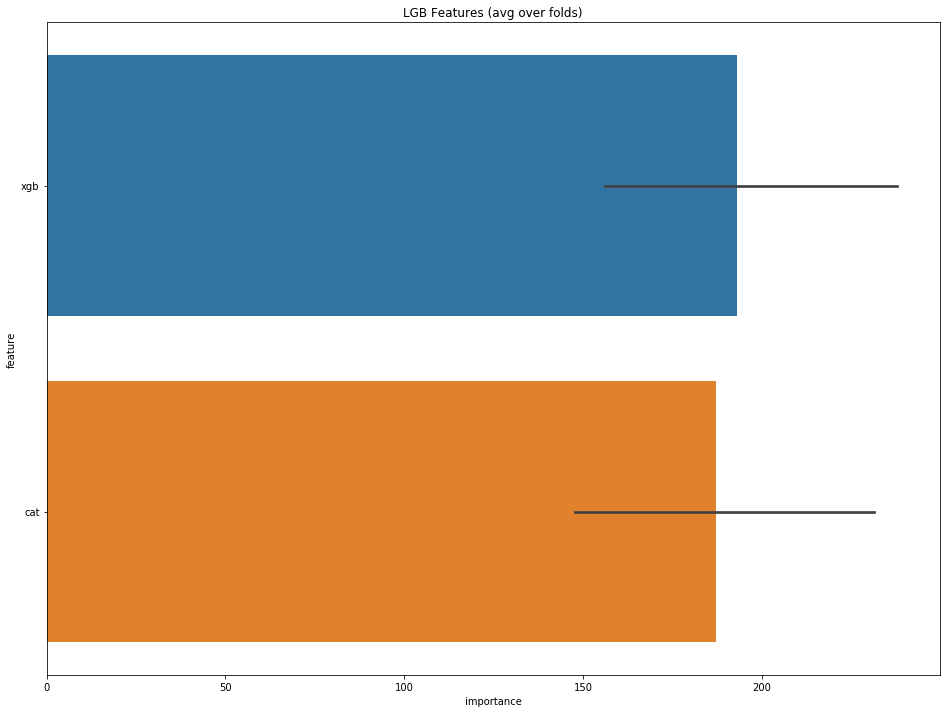

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:56:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 2.53382	valid_1's rmse: 2.39794
Fold 1 started at Tue Dec 17 11:56:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 2.58002	valid_1's rmse: 2.26777
Fold 2 started at Tue Dec 17 11:56:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 2.57907	valid_1's rmse: 2.66534
Fold 3 started at Tue Dec 17 11:56:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 2.46828	valid_1's rmse: 2.56509
Fold 4 started at Tue Dec 17 11:56:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[298]	training's rmse: 2.34835	valid_1's rmse: 3.90362
Fold 5 started at Tu

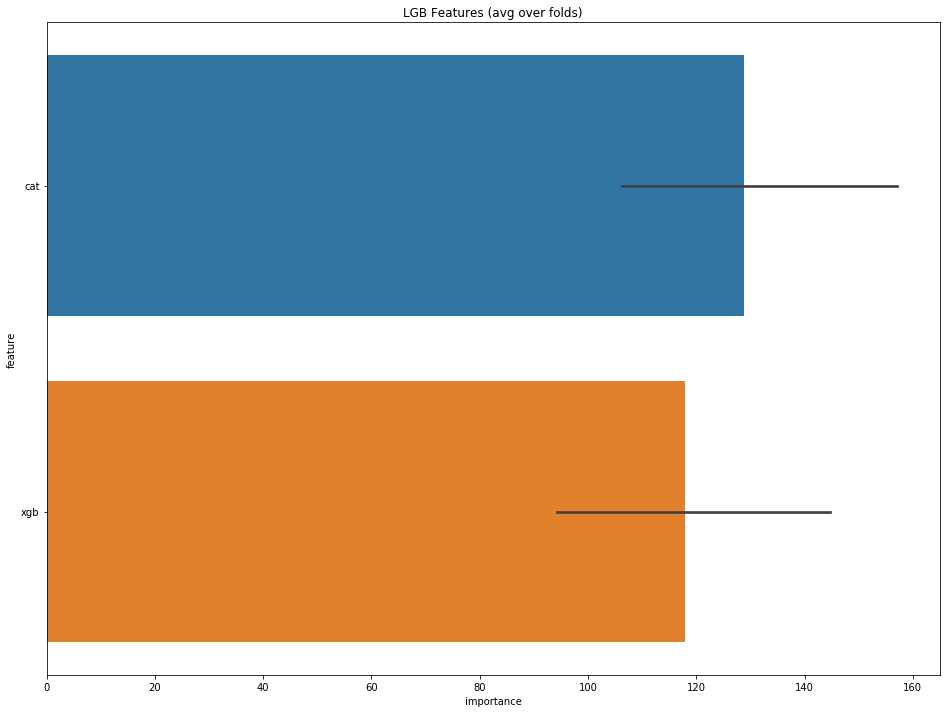

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:56:58 2019
Fold 1 started at Tue Dec 17 11:57:07 2019
Fold 2 started at Tue Dec 17 11:57:16 2019
Fold 3 started at Tue Dec 17 11:57:21 2019
Fold 4 started at Tue Dec 17 11:57:41 2019
Fold 5 started at Tue Dec 17 11:57:51 2019
Fold 6 started at Tue Dec 17 11:58:00 2019
Fold 7 started at Tue Dec 17 11:58:22 2019
Fold 8 started at Tue Dec 17 11:58:29 2019
Fold 9 started at Tue Dec 17 11:58:34 2019
CV mean score: 2.6465, std: 0.5174.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:58:44 2019
Fold 1 started at Tue Dec 17 11:58:45 2019
Fold 2 started at Tue Dec 17 11:58:45 2019
Fold 3 started at Tue Dec 17 11:58:45 2019
Fold 4 started at Tue Dec 17 11:58:45 2019
Fold 5 started at Tue Dec 17 11:58:46 2019
Fold 6 started at Tue Dec 17 11:58:46 2019
Fold 7 started at Tue Dec 17 11:58:46 2019
Fold 8 started at Tue Dec 17 11:58:46 2019
Fold 9 started at Tue Dec 17 11:58:46 2019
CV mean score: 2.7812, std: 0.4868.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:58:47 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1083
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.64786	valid_data-rmse:2.79315
Stopping. Best iteration:
[338]	train-rmse:2.21878	valid_data-rmse:2.67394

Fold 1 started at Tue Dec 17 11:58:47 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61645	valid_data-rmse:2.46324
Stopping. Best iteration:
[416]	train-rmse:1.83897	valid_data-rmse:2.43879

Fold 2 started at Tue Dec 17 11:58:47 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:58:49 2019
Fold 1 started at Tue Dec 17 11:58:49 2019
Fold 2 started at Tue Dec 17 11:58:49 2019
Fold 3 started at Tue Dec 17 11:58:49 2019
Fold 4 started at Tue Dec 17 11:58:49 2019
Fold 5 started at Tue Dec 17 11:58:49 2019
Fold 6 started at Tue Dec 17 11:58:49 2019
Fold 7 started at Tue Dec 17 11:58:49 2019
Fold 8 started at Tue Dec 17 11:58:49 2019
Fold 9 started at Tue Dec 17 11:58:49 2019
CV mean score: 3.6432, std: 0.8357.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:58:49 2019
Fold 1 started at Tue Dec 17 11:58:49 2019
Fold 2 started at Tue Dec 17 11:58:49 2019
Fold 3 started at Tue Dec 17 11:58:50 2019
Fold 4 started at Tue Dec 17 11:58:50 2019
Fold 5 started at Tue Dec 17 11:58:50 2019
Fold 6 started at Tue Dec 17 11:58:50 2019
Fold 7 started at Tue Dec 17 11:58:50 2019
Fold 8 started at Tue Dec 17 11:58:50 2019
Fold 9 started at Tue Dec 17 11:58:50 2019
CV mean score: 2.5875, std: 0.4454.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:58:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 2.60315	valid_1's rmse: 2.36109
Fold 1 started at Tue Dec 17 11:58:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 2.66185	valid_1's rmse: 2.39234
Fold 2 started at Tue Dec 17 11:59:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[211]	training's rmse: 2.75221	valid_1's rmse: 2.74943
Fold 3 started at Tue Dec 17 11:59:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.44223	valid_1's rmse: 2.55494
Early stopping, best iteration is:
[875]	training's rmse: 2.46499	valid_1's rmse: 2.54863
Fold 4 started at Tue Dec 17 11:59:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[281]	training's rm

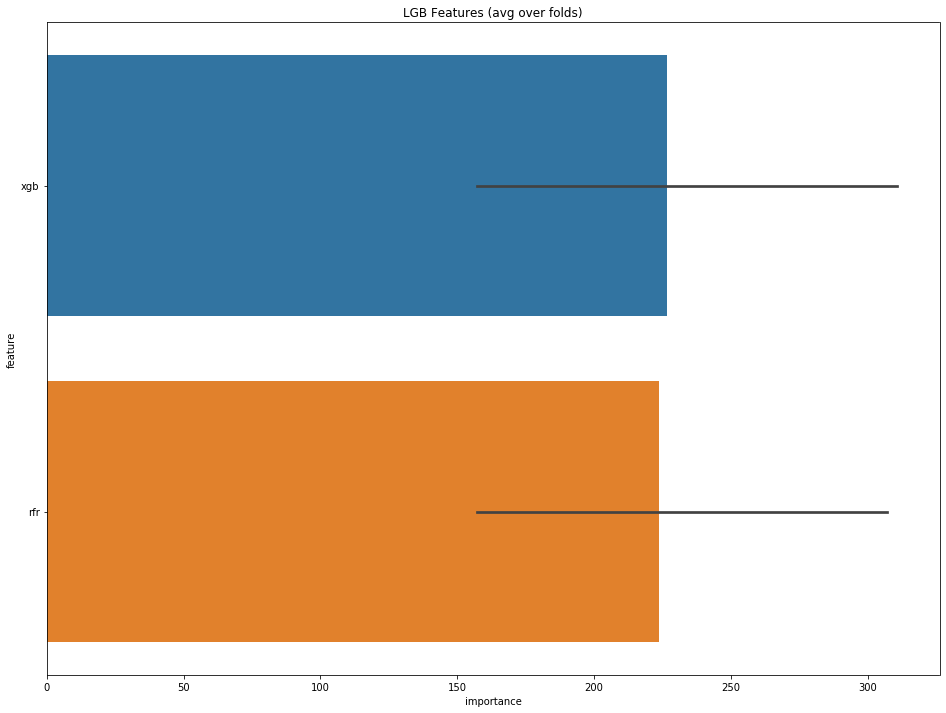

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:59:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 2.55371	valid_1's rmse: 2.28263
Fold 1 started at Tue Dec 17 12:00:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 2.64082	valid_1's rmse: 2.31969
Fold 2 started at Tue Dec 17 12:00:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[221]	training's rmse: 2.6812	valid_1's rmse: 2.84937
Fold 3 started at Tue Dec 17 12:00:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[591]	training's rmse: 2.52802	valid_1's rmse: 2.4703
Fold 4 started at Tue Dec 17 12:00:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.42991	valid_1's rmse: 3.98424
Fold 5 started at Tue 

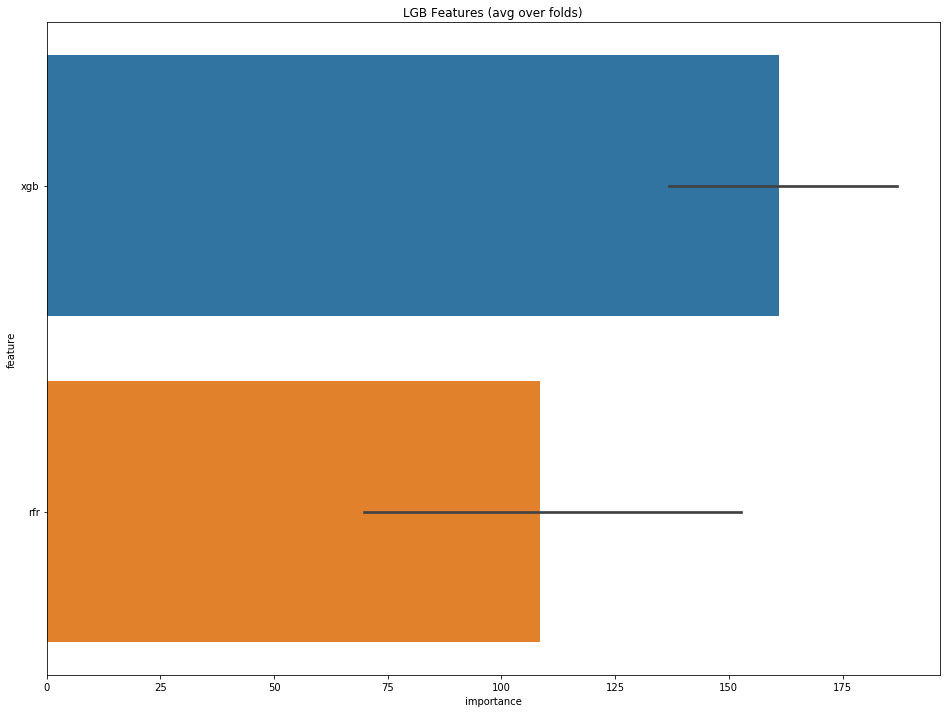

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:00:41 2019
Fold 1 started at Tue Dec 17 12:00:53 2019
Fold 2 started at Tue Dec 17 12:01:01 2019
Fold 3 started at Tue Dec 17 12:01:07 2019
Fold 4 started at Tue Dec 17 12:01:29 2019
Fold 5 started at Tue Dec 17 12:01:36 2019
Fold 6 started at Tue Dec 17 12:01:48 2019
Fold 7 started at Tue Dec 17 12:02:37 2019
Fold 8 started at Tue Dec 17 12:02:45 2019
Fold 9 started at Tue Dec 17 12:02:53 2019
CV mean score: 2.7390, std: 0.5465.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:03:01 2019
Fold 1 started at Tue Dec 17 12:03:01 2019
Fold 2 started at Tue Dec 17 12:03:01 2019
Fold 3 started at Tue Dec 17 12:03:02 2019
Fold 4 started at Tue Dec 17 12:03:02 2019
Fold 5 started at Tue Dec 17 12:03:02 2019
Fold 6 started at Tue Dec 17 12:03:02 2019
Fold 7 started at Tue Dec 17 12:03:02 2019
Fold 8 started at Tue Dec 17 12:03:03 2019
Fold 9 started at Tue Dec 17 12:03:03 2019
CV mean score: 2.9056, std: 0.5301.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:03:03 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1083
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68444	valid_data-rmse:2.69489
Stopping. Best iteration:
[379]	train-rmse:2.05388	valid_data-rmse:2.59223

Fold 1 started at Tue Dec 17 12:03:03 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.65123	valid_data-rmse:2.50248
Stopping. Best iteration:
[412]	train-rmse:1.90333	valid_data-rmse:2.47979

Fold 2 started at Tue Dec 17 12:03:04 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:03:06 2019
Fold 1 started at Tue Dec 17 12:03:06 2019
Fold 2 started at Tue Dec 17 12:03:06 2019
Fold 3 started at Tue Dec 17 12:03:06 2019
Fold 4 started at Tue Dec 17 12:03:06 2019
Fold 5 started at Tue Dec 17 12:03:06 2019
Fold 6 started at Tue Dec 17 12:03:06 2019
Fold 7 started at Tue Dec 17 12:03:06 2019
Fold 8 started at Tue Dec 17 12:03:06 2019
Fold 9 started at Tue Dec 17 12:03:06 2019
CV mean score: 3.7352, std: 0.8008.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:03:06 2019
Fold 1 started at Tue Dec 17 12:03:06 2019
Fold 2 started at Tue Dec 17 12:03:06 2019
Fold 3 started at Tue Dec 17 12:03:06 2019
Fold 4 started at Tue Dec 17 12:03:06 2019
Fold 5 started at Tue Dec 17 12:03:07 2019
Fold 6 started at Tue Dec 17 12:03:07 2019
Fold 7 started at Tue Dec 17 12:03:07 2019
Fold 8 started at Tue Dec 17 12:03:07 2019
Fold 9 started at Tue Dec 17 12:03:07 2019
CV mean score: 2.6615, std: 0.5011.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:03:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.51949	valid_1's rmse: 2.34135
Early stopping, best iteration is:
[1273]	training's rmse: 2.47155	valid_1's rmse: 2.33159
Fold 1 started at Tue Dec 17 12:03:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[400]	training's rmse: 2.83462	valid_1's rmse: 3.04791
Fold 2 started at Tue Dec 17 12:03:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.47601	valid_1's rmse: 3.01079
Early stopping, best iteration is:
[913]	training's rmse: 2.49269	valid_1's rmse: 3.00446
Fold 3 started at Tue Dec 17 12:03:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[780]	training's rmse: 2.58967	valid_1's rmse: 2.46167
Fold 4 started at Tue Dec 17 12:03:45 2019
Training until validation scores don't improve for 200 round

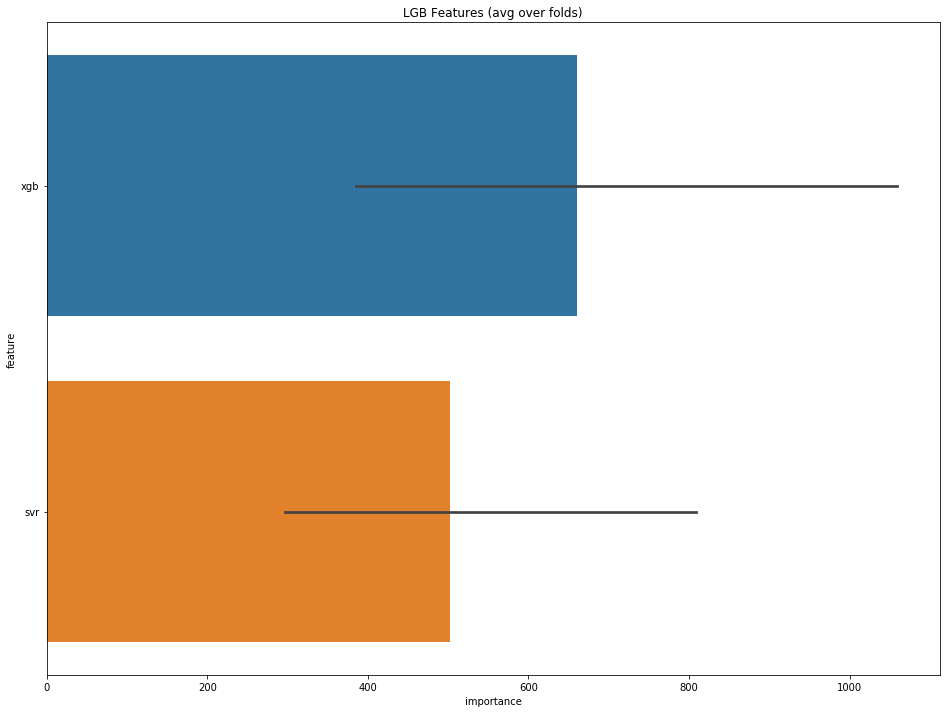

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:05:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[608]	training's rmse: 2.4908	valid_1's rmse: 2.39758
Fold 1 started at Tue Dec 17 12:05:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.66782	valid_1's rmse: 2.2354
Fold 2 started at Tue Dec 17 12:05:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[211]	training's rmse: 2.69973	valid_1's rmse: 2.79972
Fold 3 started at Tue Dec 17 12:05:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[496]	training's rmse: 2.51281	valid_1's rmse: 2.40267
Fold 4 started at Tue Dec 17 12:05:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[282]	training's rmse: 2.41283	valid_1's rmse: 4.00637
Fold 5 started at Tue 

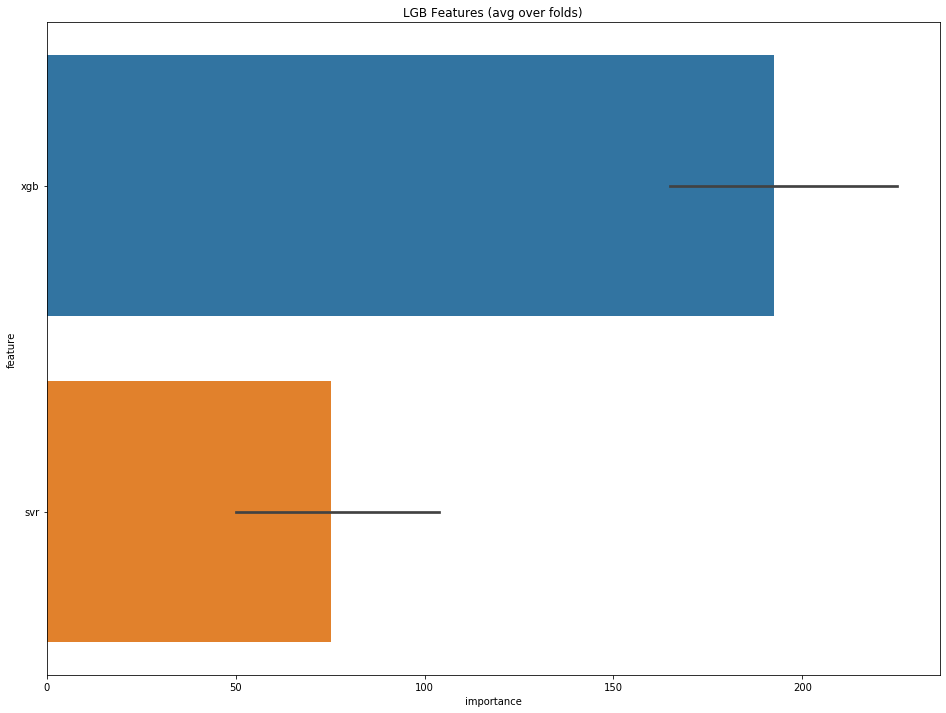

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:06:00 2019
Fold 1 started at Tue Dec 17 12:06:11 2019
Fold 2 started at Tue Dec 17 12:06:23 2019
Fold 3 started at Tue Dec 17 12:06:30 2019
Fold 4 started at Tue Dec 17 12:06:43 2019
Fold 5 started at Tue Dec 17 12:06:52 2019
Fold 6 started at Tue Dec 17 12:07:04 2019
Fold 7 started at Tue Dec 17 12:07:38 2019
Fold 8 started at Tue Dec 17 12:08:00 2019
Fold 9 started at Tue Dec 17 12:08:08 2019
CV mean score: 2.7937, std: 0.4865.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:08:19 2019
Fold 1 started at Tue Dec 17 12:08:20 2019
Fold 2 started at Tue Dec 17 12:08:20 2019
Fold 3 started at Tue Dec 17 12:08:20 2019
Fold 4 started at Tue Dec 17 12:08:20 2019
Fold 5 started at Tue Dec 17 12:08:21 2019
Fold 6 started at Tue Dec 17 12:08:21 2019
Fold 7 started at Tue Dec 17 12:08:21 2019
Fold 8 started at Tue Dec 17 12:08:21 2019
Fold 9 started at Tue Dec 17 12:08:22 2019
CV mean score: 3.2123, std: 0.7649.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:08:22 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1083
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.07669	valid_data-rmse:3.04205
Stopping. Best iteration:
[445]	train-rmse:2.23069	valid_data-rmse:3.01682

Fold 1 started at Tue Dec 17 12:08:22 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.04501	valid_data-rmse:2.50632
Stopping. Best iteration:
[469]	train-rmse:2.12946	valid_data-rmse:2.50246

Fold 2 started at Tue Dec 17 12:08:22 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:08:25 2019
Fold 1 started at Tue Dec 17 12:08:25 2019
Fold 2 started at Tue Dec 17 12:08:25 2019
Fold 3 started at Tue Dec 17 12:08:25 2019
Fold 4 started at Tue Dec 17 12:08:25 2019
Fold 5 started at Tue Dec 17 12:08:25 2019
Fold 6 started at Tue Dec 17 12:08:25 2019
Fold 7 started at Tue Dec 17 12:08:25 2019
Fold 8 started at Tue Dec 17 12:08:25 2019
Fold 9 started at Tue Dec 17 12:08:25 2019
CV mean score: 3.2900, std: 0.8411.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:08:25 2019
Fold 1 started at Tue Dec 17 12:08:25 2019
Fold 2 started at Tue Dec 17 12:08:25 2019
Fold 3 started at Tue Dec 17 12:08:25 2019
Fold 4 started at Tue Dec 17 12:08:25 2019
Fold 5 started at Tue Dec 17 12:08:25 2019
Fold 6 started at Tue Dec 17 12:08:26 2019
Fold 7 started at Tue Dec 17 12:08:26 2019
Fold 8 started at Tue Dec 17 12:08:26 2019
Fold 9 started at Tue Dec 17 12:08:26 2019
CV mean score: 2.6483, std: 0.4965.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:08:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[405]	training's rmse: 2.3793	valid_1's rmse: 2.25739
Fold 1 started at Tue Dec 17 12:08:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 2.60076	valid_1's rmse: 2.40818
Fold 2 started at Tue Dec 17 12:08:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.49309	valid_1's rmse: 2.80266
Fold 3 started at Tue Dec 17 12:08:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[687]	training's rmse: 2.25173	valid_1's rmse: 2.55033
Fold 4 started at Tue Dec 17 12:08:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 2.19717	valid_1's rmse: 3.79209
Fold 5 started at Tue

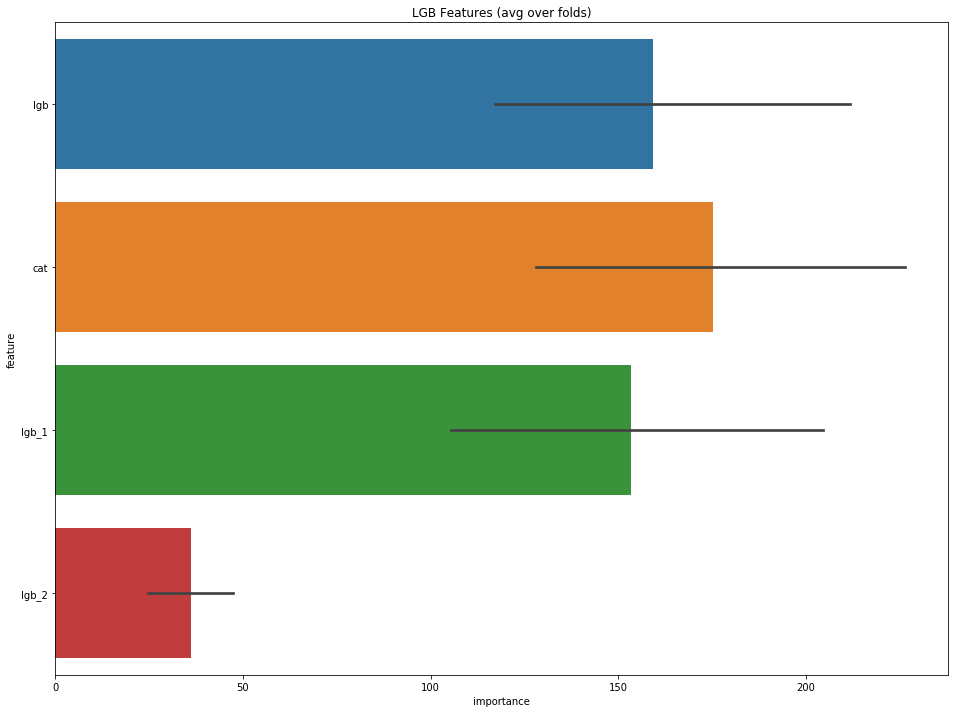

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:09:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[480]	training's rmse: 2.42271	valid_1's rmse: 2.22018
Fold 1 started at Tue Dec 17 12:09:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.5226	valid_1's rmse: 2.38579
Fold 2 started at Tue Dec 17 12:10:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 2.47571	valid_1's rmse: 2.79255
Fold 3 started at Tue Dec 17 12:10:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[509]	training's rmse: 2.37238	valid_1's rmse: 2.52195
Fold 4 started at Tue Dec 17 12:10:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[686]	training's rmse: 2.16907	valid_1's rmse: 3.79941
Fold 5 started at Tue

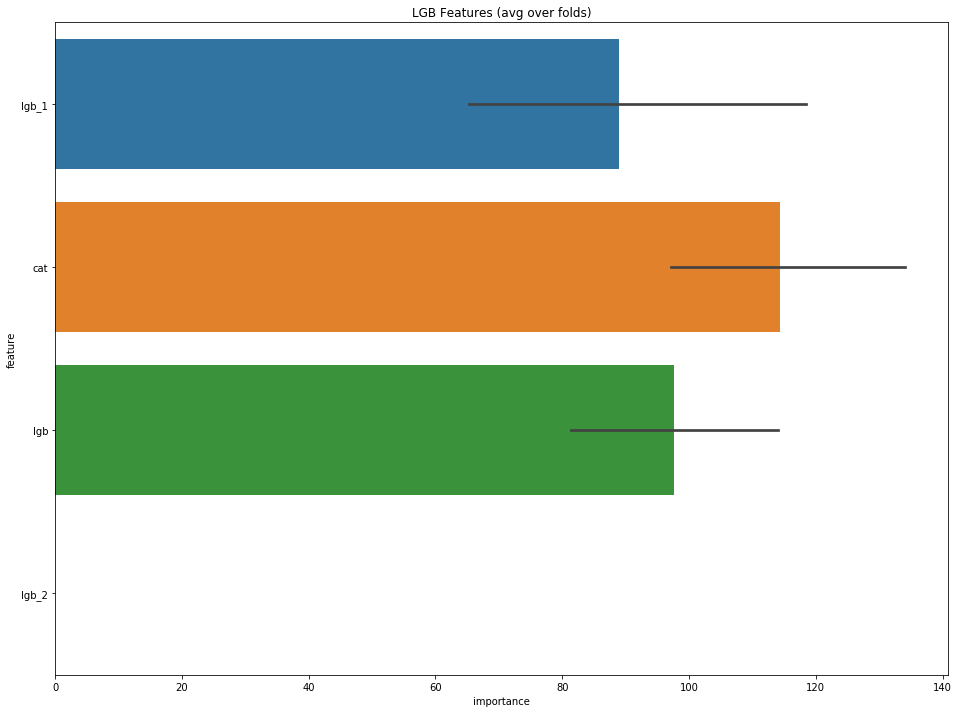

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:10:50 2019
Fold 1 started at Tue Dec 17 12:11:25 2019
Fold 2 started at Tue Dec 17 12:11:32 2019
Fold 3 started at Tue Dec 17 12:11:38 2019
Fold 4 started at Tue Dec 17 12:11:44 2019
Fold 5 started at Tue Dec 17 12:12:23 2019
Fold 6 started at Tue Dec 17 12:12:37 2019
Fold 7 started at Tue Dec 17 12:12:58 2019
Fold 8 started at Tue Dec 17 12:13:06 2019
Fold 9 started at Tue Dec 17 12:13:22 2019
CV mean score: 2.6150, std: 0.4737.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:13:32 2019
Fold 1 started at Tue Dec 17 12:13:33 2019
Fold 2 started at Tue Dec 17 12:13:33 2019
Fold 3 started at Tue Dec 17 12:13:33 2019
Fold 4 started at Tue Dec 17 12:13:33 2019
Fold 5 started at Tue Dec 17 12:13:33 2019
Fold 6 started at Tue Dec 17 12:13:34 2019
Fold 7 started at Tue Dec 17 12:13:34 2019
Fold 8 started at Tue Dec 17 12:13:34 2019
Fold 9 started at Tue Dec 17 12:13:34 2019
CV mean score: 2.7379, std: 0.4653.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:13:35 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.41303	valid_data-rmse:1.97582
Stopping. Best iteration:
[529]	train-rmse:1.34873	valid_data-rmse:1.96771

Fold 1 started at Tue Dec 17 12:13:35 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.40418	valid_data-rmse:2.52753
Stopping. Best iteration:
[394]	train-rmse:1.72819	valid_data-rmse:2.48198

Fold 2 started at Tue Dec 17 12:13:35 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8622
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:13:38 2019
Fold 1 started at Tue Dec 17 12:13:38 2019
Fold 2 started at Tue Dec 17 12:13:38 2019
Fold 3 started at Tue Dec 17 12:13:38 2019
Fold 4 started at Tue Dec 17 12:13:38 2019
Fold 5 started at Tue Dec 17 12:13:38 2019
Fold 6 started at Tue Dec 17 12:13:38 2019
Fold 7 started at Tue Dec 17 12:13:38 2019
Fold 8 started at Tue Dec 17 12:13:38 2019
Fold 9 started at Tue Dec 17 12:13:38 2019
CV mean score: 3.6014, std: 0.8276.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:13:38 2019
Fold 1 started at Tue Dec 17 12:13:38 2019
Fold 2 started at Tue Dec 17 12:13:38 2019
Fold 3 started at Tue Dec 17 12:13:39 2019
Fold 4 started at Tue Dec 17 12:13:39 2019
Fold 5 started at Tue Dec 17 12:13:39 2019
Fold 6 started at Tue Dec 17 12:13:39 2019
Fold 7 started at Tue Dec 17 12:13:39 2019
Fold 8 started at Tue Dec 17 12:13:39 2019
Fold 9 started at Tue Dec 17 12:13:39 2019
CV mean score: 2.6117, std: 0.4292.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:13:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[402]	training's rmse: 2.45328	valid_1's rmse: 2.20839
Fold 1 started at Tue Dec 17 12:13:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's rmse: 2.67959	valid_1's rmse: 2.60732
Fold 2 started at Tue Dec 17 12:13:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.56605	valid_1's rmse: 2.90371
Fold 3 started at Tue Dec 17 12:13:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 2.33412	valid_1's rmse: 2.75113
Fold 4 started at Tue Dec 17 12:13:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's rmse: 2.23528	valid_1's rmse: 3.89239
Fold 5 started at Tu

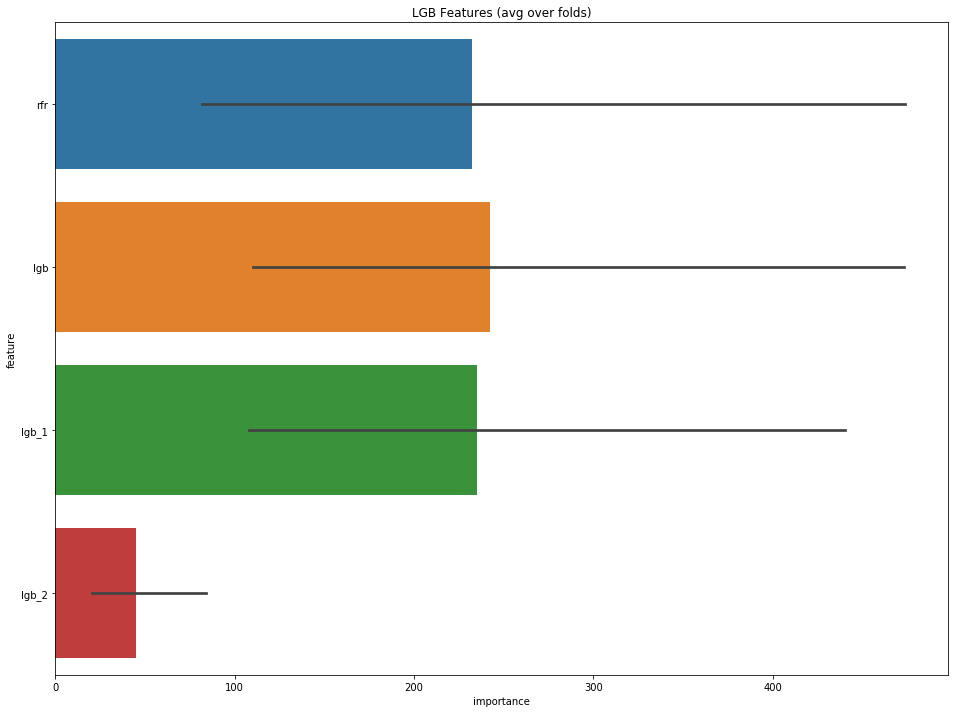

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:14:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 2.50182	valid_1's rmse: 2.22802
Fold 1 started at Tue Dec 17 12:14:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 2.62165	valid_1's rmse: 2.60629
Fold 2 started at Tue Dec 17 12:14:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 2.57044	valid_1's rmse: 2.89395
Fold 3 started at Tue Dec 17 12:14:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[596]	training's rmse: 2.39471	valid_1's rmse: 2.76662
Fold 4 started at Tue Dec 17 12:14:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 2.28354	valid_1's rmse: 3.89086
Fold 5 started at Tu

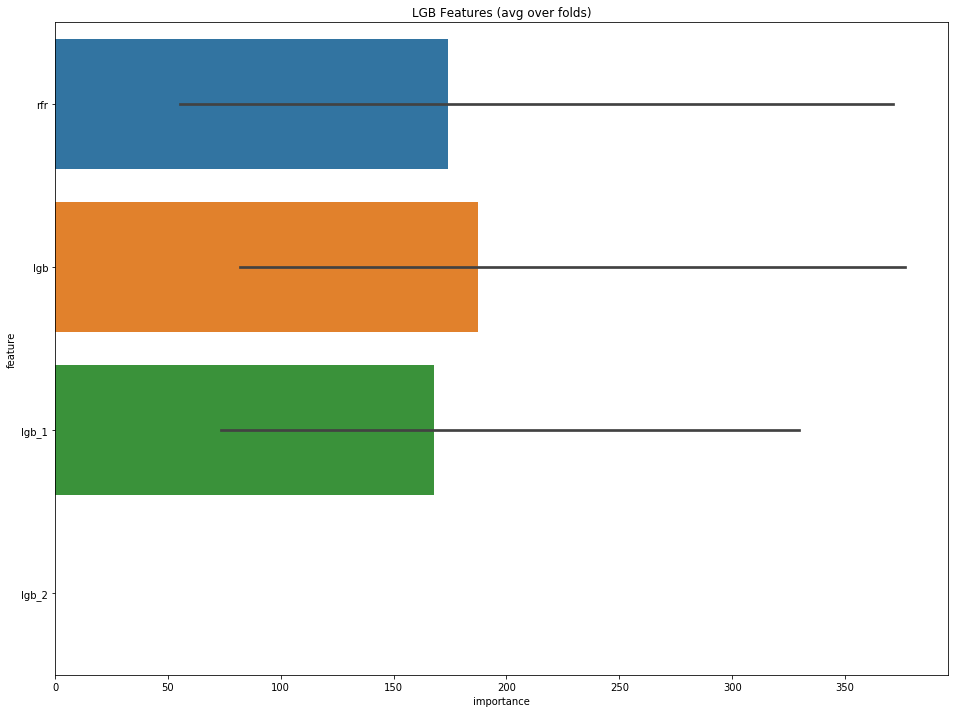

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:16:08 2019
Fold 1 started at Tue Dec 17 12:16:25 2019
Fold 2 started at Tue Dec 17 12:16:33 2019
Fold 3 started at Tue Dec 17 12:16:39 2019
Fold 4 started at Tue Dec 17 12:16:46 2019
Fold 5 started at Tue Dec 17 12:17:13 2019
Fold 6 started at Tue Dec 17 12:18:39 2019
Fold 7 started at Tue Dec 17 12:19:19 2019
Fold 8 started at Tue Dec 17 12:19:27 2019
Fold 9 started at Tue Dec 17 12:19:42 2019
CV mean score: 2.6507, std: 0.4717.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:19:51 2019
Fold 1 started at Tue Dec 17 12:19:51 2019
Fold 2 started at Tue Dec 17 12:19:51 2019
Fold 3 started at Tue Dec 17 12:19:51 2019
Fold 4 started at Tue Dec 17 12:19:52 2019
Fold 5 started at Tue Dec 17 12:19:52 2019
Fold 6 started at Tue Dec 17 12:19:52 2019
Fold 7 started at Tue Dec 17 12:19:52 2019
Fold 8 started at Tue Dec 17 12:19:52 2019
Fold 9 started at Tue Dec 17 12:19:53 2019
CV mean score: 2.8371, std: 0.5031.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:19:53 2019
[0]	train-rmse:23.9868	valid_data-rmse:24.1107
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.44488	valid_data-rmse:2.21947
Stopping. Best iteration:
[488]	train-rmse:1.4703	valid_data-rmse:2.21501

Fold 1 started at Tue Dec 17 12:19:53 2019
[0]	train-rmse:24.1981	valid_data-rmse:22.1723
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.42993	valid_data-rmse:2.8978
Stopping. Best iteration:
[337]	train-rmse:2.08118	valid_data-rmse:2.74748

Fold 2 started at Tue Dec 17 12:19:54 2019
[0]	train-rmse:24.0122	valid_data-rmse:23.8703
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:19:56 2019
Fold 1 started at Tue Dec 17 12:19:56 2019
Fold 2 started at Tue Dec 17 12:19:57 2019
Fold 3 started at Tue Dec 17 12:19:57 2019
Fold 4 started at Tue Dec 17 12:19:57 2019
Fold 5 started at Tue Dec 17 12:19:57 2019
Fold 6 started at Tue Dec 17 12:19:57 2019
Fold 7 started at Tue Dec 17 12:19:57 2019
Fold 8 started at Tue Dec 17 12:19:57 2019
Fold 9 started at Tue Dec 17 12:19:57 2019
CV mean score: 3.7356, std: 0.8153.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:19:57 2019
Fold 1 started at Tue Dec 17 12:19:57 2019
Fold 2 started at Tue Dec 17 12:19:57 2019
Fold 3 started at Tue Dec 17 12:19:57 2019
Fold 4 started at Tue Dec 17 12:19:57 2019
Fold 5 started at Tue Dec 17 12:19:57 2019
Fold 6 started at Tue Dec 17 12:19:57 2019
Fold 7 started at Tue Dec 17 12:19:57 2019
Fold 8 started at Tue Dec 17 12:19:57 2019
Fold 9 started at Tue Dec 17 12:19:58 2019
CV mean score: 2.6692, std: 0.4765.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:19:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 2.46713	valid_1's rmse: 2.3493
Fold 1 started at Tue Dec 17 12:20:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[210]	training's rmse: 2.65922	valid_1's rmse: 2.57655
Fold 2 started at Tue Dec 17 12:20:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.53947	valid_1's rmse: 2.94683
Fold 3 started at Tue Dec 17 12:20:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 2.41613	valid_1's rmse: 2.80797
Fold 4 started at Tue Dec 17 12:20:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 2.20369	valid_1's rmse: 3.87893
Fold 5 started at Tue

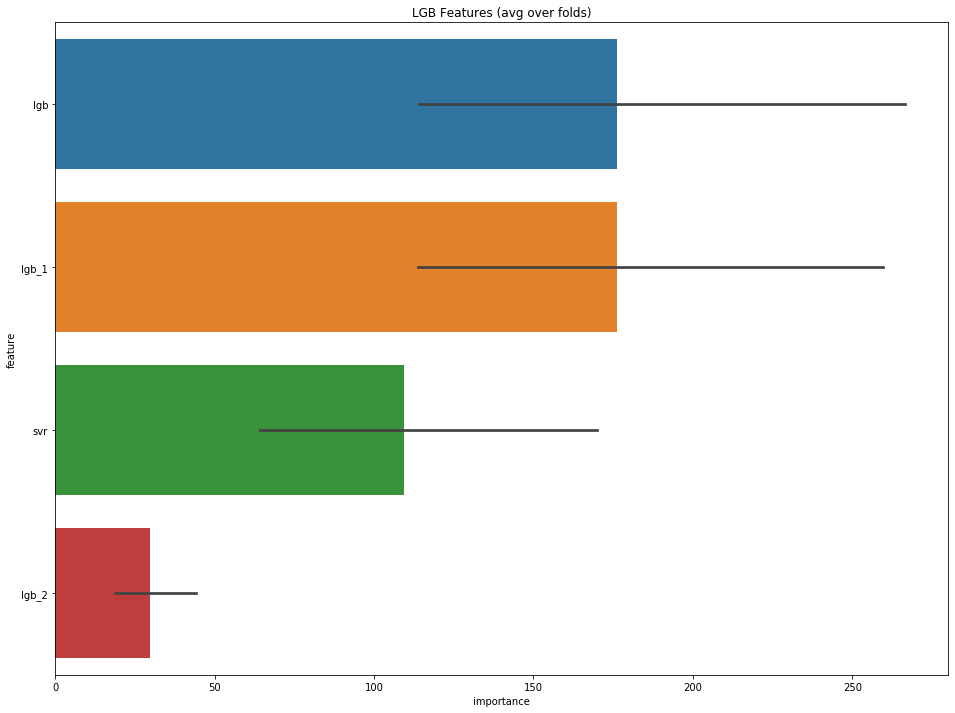

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:21:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[611]	training's rmse: 2.42726	valid_1's rmse: 2.31212
Fold 1 started at Tue Dec 17 12:21:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.61523	valid_1's rmse: 2.58094
Fold 2 started at Tue Dec 17 12:21:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[206]	training's rmse: 2.65963	valid_1's rmse: 2.96237
Fold 3 started at Tue Dec 17 12:21:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 2.47134	valid_1's rmse: 2.83658
Fold 4 started at Tue Dec 17 12:21:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[540]	training's rmse: 2.21602	valid_1's rmse: 3.8777
Fold 5 started at Tue

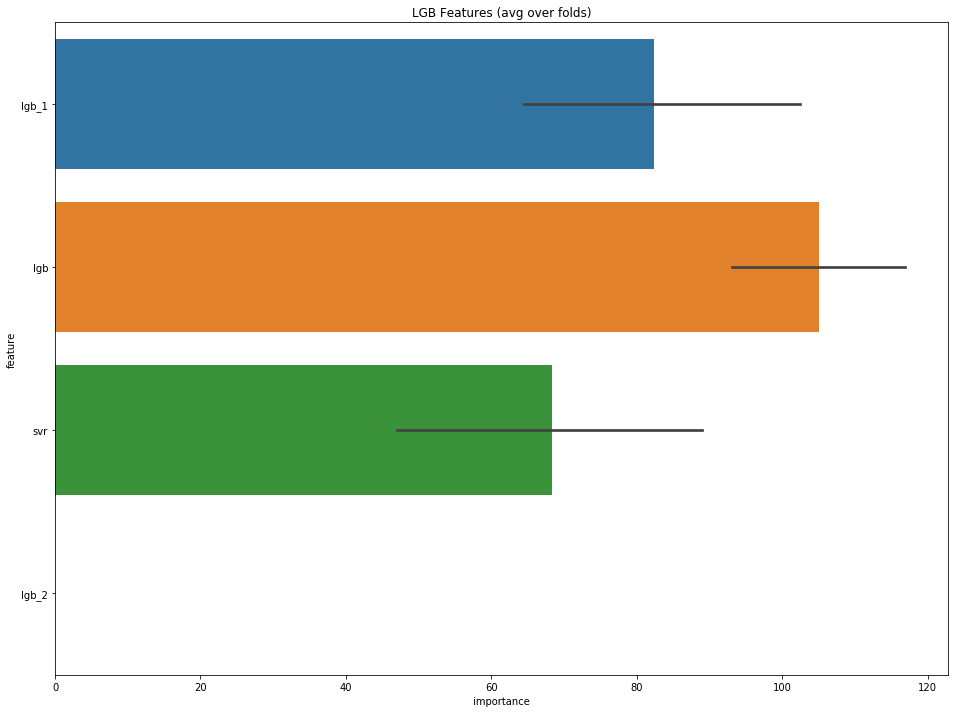

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:21:31 2019
Fold 1 started at Tue Dec 17 12:21:52 2019
Fold 2 started at Tue Dec 17 12:21:58 2019
Fold 3 started at Tue Dec 17 12:22:03 2019
Fold 4 started at Tue Dec 17 12:22:09 2019
Fold 5 started at Tue Dec 17 12:22:29 2019
Fold 6 started at Tue Dec 17 12:23:43 2019
Fold 7 started at Tue Dec 17 12:23:53 2019
Fold 8 started at Tue Dec 17 12:24:03 2019
Fold 9 started at Tue Dec 17 12:24:19 2019
CV mean score: 2.6404, std: 0.4523.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:24:28 2019
Fold 1 started at Tue Dec 17 12:24:28 2019
Fold 2 started at Tue Dec 17 12:24:28 2019
Fold 3 started at Tue Dec 17 12:24:29 2019
Fold 4 started at Tue Dec 17 12:24:29 2019
Fold 5 started at Tue Dec 17 12:24:29 2019
Fold 6 started at Tue Dec 17 12:24:29 2019
Fold 7 started at Tue Dec 17 12:24:29 2019
Fold 8 started at Tue Dec 17 12:24:30 2019
Fold 9 started at Tue Dec 17 12:24:30 2019
CV mean score: 2.9449, std: 0.4367.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:24:30 2019
[0]	train-rmse:23.9863	valid_data-rmse:24.1108
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.44259	valid_data-rmse:2.17825
Stopping. Best iteration:
[463]	train-rmse:1.53787	valid_data-rmse:2.16877

Fold 1 started at Tue Dec 17 12:24:31 2019
[0]	train-rmse:24.1981	valid_data-rmse:22.1723
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.40941	valid_data-rmse:2.80423
Stopping. Best iteration:
[382]	train-rmse:1.79632	valid_data-rmse:2.74589

Fold 2 started at Tue Dec 17 12:24:31 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Be

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:24:34 2019
Fold 1 started at Tue Dec 17 12:24:34 2019
Fold 2 started at Tue Dec 17 12:24:34 2019
Fold 3 started at Tue Dec 17 12:24:34 2019
Fold 4 started at Tue Dec 17 12:24:34 2019
Fold 5 started at Tue Dec 17 12:24:34 2019
Fold 6 started at Tue Dec 17 12:24:34 2019
Fold 7 started at Tue Dec 17 12:24:34 2019
Fold 8 started at Tue Dec 17 12:24:34 2019
Fold 9 started at Tue Dec 17 12:24:34 2019
CV mean score: 3.4009, std: 0.7112.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:24:34 2019
Fold 1 started at Tue Dec 17 12:24:34 2019
Fold 2 started at Tue Dec 17 12:24:34 2019
Fold 3 started at Tue Dec 17 12:24:34 2019
Fold 4 started at Tue Dec 17 12:24:34 2019
Fold 5 started at Tue Dec 17 12:24:34 2019
Fold 6 started at Tue Dec 17 12:24:34 2019
Fold 7 started at Tue Dec 17 12:24:35 2019
Fold 8 started at Tue Dec 17 12:24:35 2019
Fold 9 started at Tue Dec 17 12:24:35 2019
CV mean score: 2.6580, std: 0.4737.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:24:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.40433	valid_1's rmse: 2.32064
Fold 1 started at Tue Dec 17 12:24:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's rmse: 2.55011	valid_1's rmse: 2.48856
Fold 2 started at Tue Dec 17 12:24:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.5154	valid_1's rmse: 2.85018
Fold 3 started at Tue Dec 17 12:24:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[492]	training's rmse: 2.33155	valid_1's rmse: 2.62069
Fold 4 started at Tue Dec 17 12:25:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.29821	valid_1's rmse: 4.01753
Fold 5 started at Tue

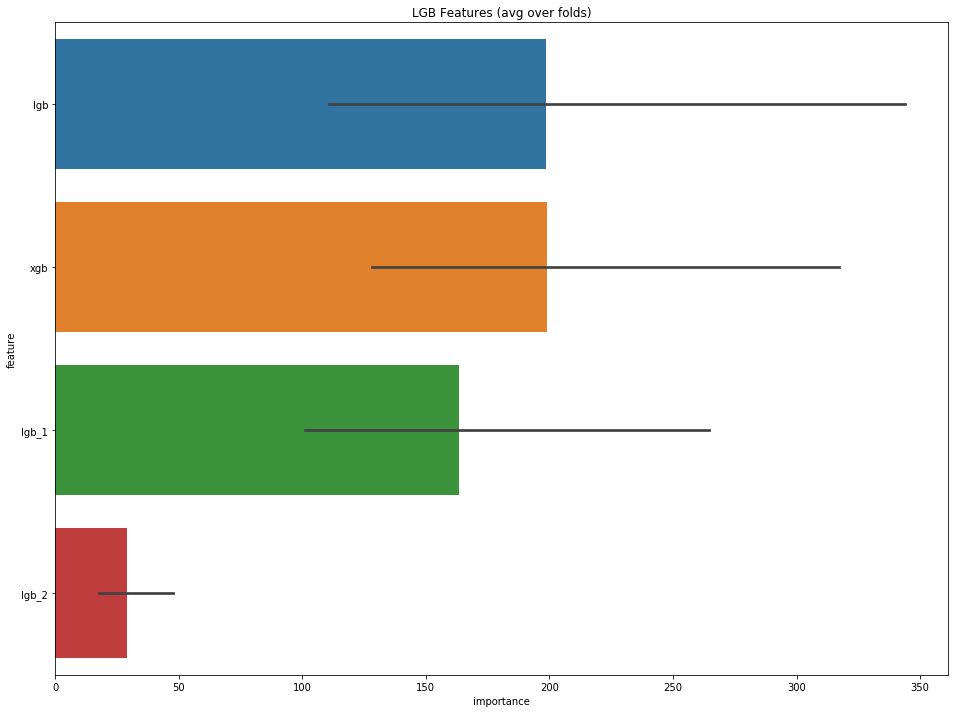

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:26:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 2.48613	valid_1's rmse: 2.31972
Fold 1 started at Tue Dec 17 12:26:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 2.54191	valid_1's rmse: 2.46843
Fold 2 started at Tue Dec 17 12:26:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.54726	valid_1's rmse: 2.84768
Fold 3 started at Tue Dec 17 12:26:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[473]	training's rmse: 2.39803	valid_1's rmse: 2.62826
Fold 4 started at Tue Dec 17 12:26:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[401]	training's rmse: 2.24146	valid_1's rmse: 4.02732
Fold 5 started at Tu

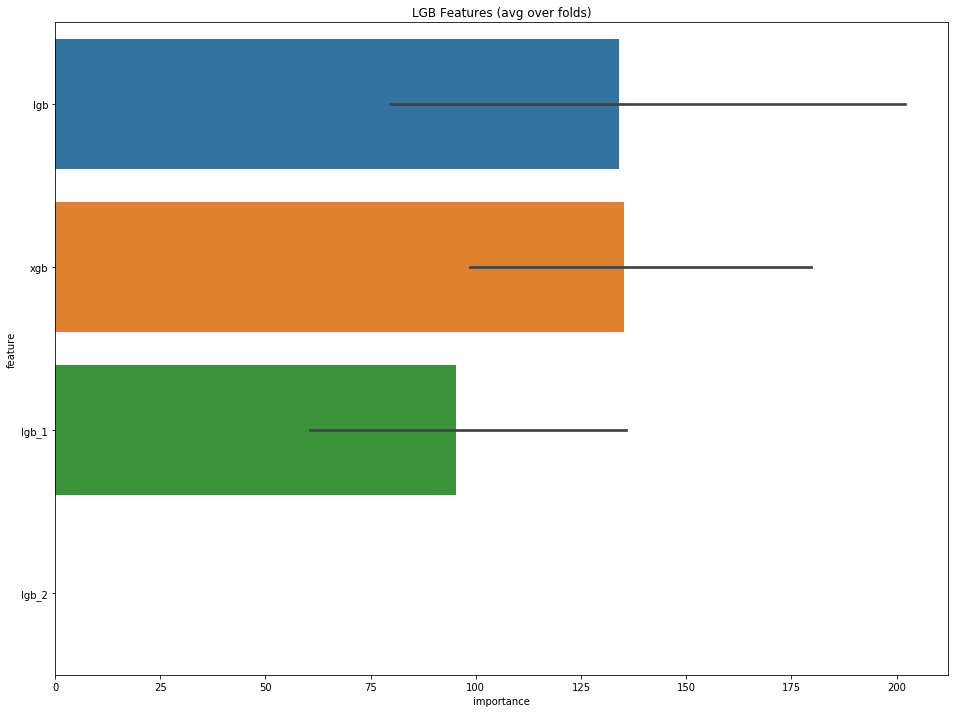

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:27:04 2019
Fold 1 started at Tue Dec 17 12:27:24 2019
Fold 2 started at Tue Dec 17 12:27:32 2019
Fold 3 started at Tue Dec 17 12:27:37 2019
Fold 4 started at Tue Dec 17 12:27:44 2019
Fold 5 started at Tue Dec 17 12:28:03 2019
Fold 6 started at Tue Dec 17 12:29:07 2019
Fold 7 started at Tue Dec 17 12:29:22 2019
Fold 8 started at Tue Dec 17 12:29:30 2019
Fold 9 started at Tue Dec 17 12:29:37 2019
CV mean score: 2.6317, std: 0.4545.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:29:48 2019
Fold 1 started at Tue Dec 17 12:29:49 2019
Fold 2 started at Tue Dec 17 12:29:49 2019
Fold 3 started at Tue Dec 17 12:29:49 2019
Fold 4 started at Tue Dec 17 12:29:49 2019
Fold 5 started at Tue Dec 17 12:29:50 2019
Fold 6 started at Tue Dec 17 12:29:50 2019
Fold 7 started at Tue Dec 17 12:29:50 2019
Fold 8 started at Tue Dec 17 12:29:50 2019
Fold 9 started at Tue Dec 17 12:29:50 2019
CV mean score: 2.7895, std: 0.5373.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:29:51 2019
[0]	train-rmse:23.9857	valid_data-rmse:24.1082
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.45546	valid_data-rmse:2.30427
Stopping. Best iteration:
[526]	train-rmse:1.39238	valid_data-rmse:2.29561

Fold 1 started at Tue Dec 17 12:29:51 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.42835	valid_data-rmse:2.64307
Stopping. Best iteration:
[369]	train-rmse:1.87783	valid_data-rmse:2.56688

Fold 2 started at Tue Dec 17 12:29:51 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8713
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:29:54 2019
Fold 1 started at Tue Dec 17 12:29:54 2019
Fold 2 started at Tue Dec 17 12:29:54 2019
Fold 3 started at Tue Dec 17 12:29:54 2019
Fold 4 started at Tue Dec 17 12:29:54 2019
Fold 5 started at Tue Dec 17 12:29:54 2019
Fold 6 started at Tue Dec 17 12:29:54 2019
Fold 7 started at Tue Dec 17 12:29:54 2019
Fold 8 started at Tue Dec 17 12:29:54 2019
Fold 9 started at Tue Dec 17 12:29:54 2019
CV mean score: 3.6824, std: 0.8690.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:29:54 2019
Fold 1 started at Tue Dec 17 12:29:54 2019
Fold 2 started at Tue Dec 17 12:29:54 2019
Fold 3 started at Tue Dec 17 12:29:54 2019
Fold 4 started at Tue Dec 17 12:29:55 2019
Fold 5 started at Tue Dec 17 12:29:55 2019
Fold 6 started at Tue Dec 17 12:29:55 2019
Fold 7 started at Tue Dec 17 12:29:55 2019
Fold 8 started at Tue Dec 17 12:29:55 2019
Fold 9 started at Tue Dec 17 12:29:55 2019
CV mean score: 2.6184, std: 0.4680.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:29:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[326]	training's rmse: 2.5878	valid_1's rmse: 2.5541
Fold 1 started at Tue Dec 17 12:30:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 2.69104	valid_1's rmse: 2.31809
Fold 2 started at Tue Dec 17 12:30:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 2.61648	valid_1's rmse: 2.78076
Fold 3 started at Tue Dec 17 12:30:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[658]	training's rmse: 2.51416	valid_1's rmse: 2.61343
Fold 4 started at Tue Dec 17 12:30:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 2.42619	valid_1's rmse: 3.69511
Fold 5 started at Tue 

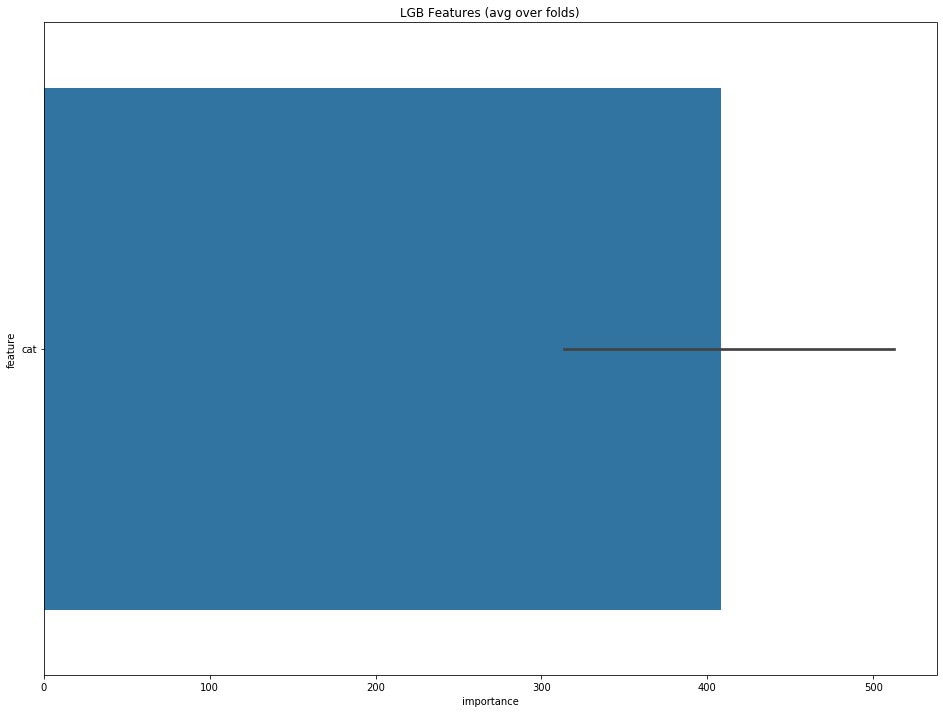

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:30:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's rmse: 2.59711	valid_1's rmse: 2.51536
Fold 1 started at Tue Dec 17 12:31:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.65742	valid_1's rmse: 2.29968
Fold 2 started at Tue Dec 17 12:31:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 2.59989	valid_1's rmse: 2.78313
Fold 3 started at Tue Dec 17 12:31:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.52232	valid_1's rmse: 2.5853
Early stopping, best iteration is:
[1406]	training's rmse: 2.50603	valid_1's rmse: 2.57518
Fold 4 started at Tue Dec 17 12:31:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rm

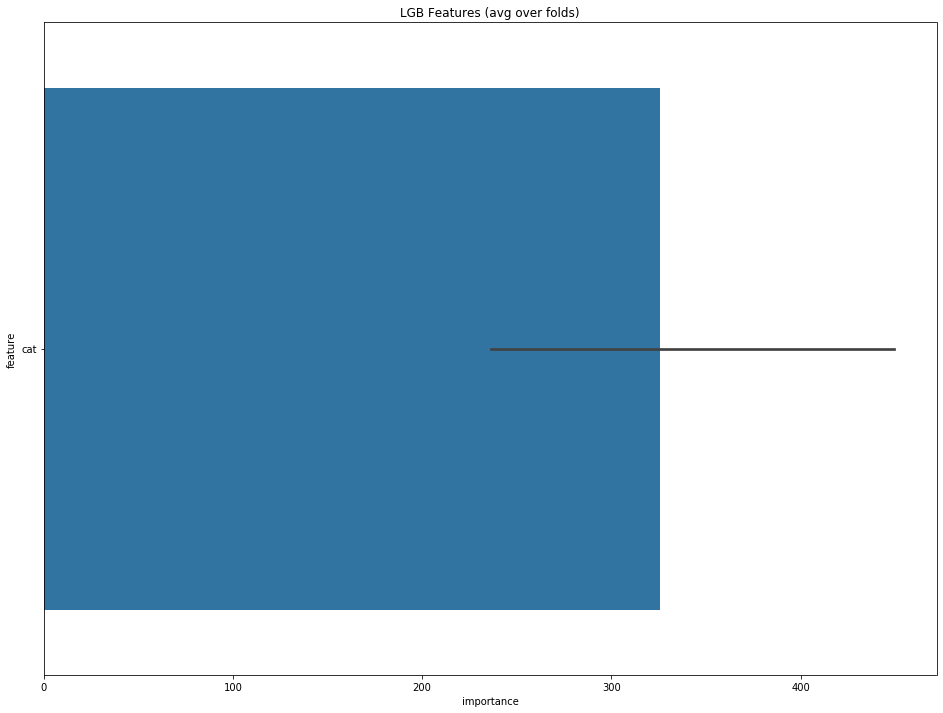

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:31:47 2019
Fold 1 started at Tue Dec 17 12:31:58 2019
Fold 2 started at Tue Dec 17 12:32:15 2019
Fold 3 started at Tue Dec 17 12:32:21 2019
Fold 4 started at Tue Dec 17 12:32:47 2019
Fold 5 started at Tue Dec 17 12:33:16 2019
Fold 6 started at Tue Dec 17 12:33:24 2019
Fold 7 started at Tue Dec 17 12:33:43 2019
Fold 8 started at Tue Dec 17 12:33:49 2019
Fold 9 started at Tue Dec 17 12:33:54 2019
CV mean score: 2.6546, std: 0.4392.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:34:02 2019
Fold 1 started at Tue Dec 17 12:34:02 2019
Fold 2 started at Tue Dec 17 12:34:02 2019
Fold 3 started at Tue Dec 17 12:34:03 2019
Fold 4 started at Tue Dec 17 12:34:03 2019
Fold 5 started at Tue Dec 17 12:34:03 2019
Fold 6 started at Tue Dec 17 12:34:03 2019
Fold 7 started at Tue Dec 17 12:34:04 2019
Fold 8 started at Tue Dec 17 12:34:04 2019
Fold 9 started at Tue Dec 17 12:34:04 2019
CV mean score: 2.9070, std: 0.4460.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:34:04 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.76026	valid_data-rmse:3.02348
Stopping. Best iteration:
[319]	train-rmse:2.41889	valid_data-rmse:2.84108

Fold 1 started at Tue Dec 17 12:34:04 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.77947	valid_data-rmse:2.48916
Stopping. Best iteration:
[453]	train-rmse:1.87399	valid_data-rmse:2.48494

Fold 2 started at Tue Dec 17 12:34:05 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8621
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Be

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:34:06 2019
Fold 1 started at Tue Dec 17 12:34:06 2019
Fold 2 started at Tue Dec 17 12:34:06 2019
Fold 3 started at Tue Dec 17 12:34:06 2019
Fold 4 started at Tue Dec 17 12:34:06 2019
Fold 5 started at Tue Dec 17 12:34:06 2019
Fold 6 started at Tue Dec 17 12:34:06 2019
Fold 7 started at Tue Dec 17 12:34:06 2019
Fold 8 started at Tue Dec 17 12:34:06 2019
Fold 9 started at Tue Dec 17 12:34:06 2019
CV mean score: 3.2472, std: 0.7072.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:34:06 2019
Fold 1 started at Tue Dec 17 12:34:07 2019
Fold 2 started at Tue Dec 17 12:34:07 2019
Fold 3 started at Tue Dec 17 12:34:07 2019
Fold 4 started at Tue Dec 17 12:34:07 2019
Fold 5 started at Tue Dec 17 12:34:07 2019
Fold 6 started at Tue Dec 17 12:34:07 2019
Fold 7 started at Tue Dec 17 12:34:07 2019
Fold 8 started at Tue Dec 17 12:34:07 2019
Fold 9 started at Tue Dec 17 12:34:08 2019
CV mean score: 2.6350, std: 0.3909.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:34:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.7286	valid_1's rmse: 2.50141
Early stopping, best iteration is:
[965]	training's rmse: 2.73306	valid_1's rmse: 2.49699
Fold 1 started at Tue Dec 17 12:34:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[281]	training's rmse: 2.88392	valid_1's rmse: 2.62072
Fold 2 started at Tue Dec 17 12:34:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 2.98594	valid_1's rmse: 2.85686
Fold 3 started at Tue Dec 17 12:34:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[658]	training's rmse: 2.71807	valid_1's rmse: 3.03165
Fold 4 started at Tue Dec 17 12:34:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rms

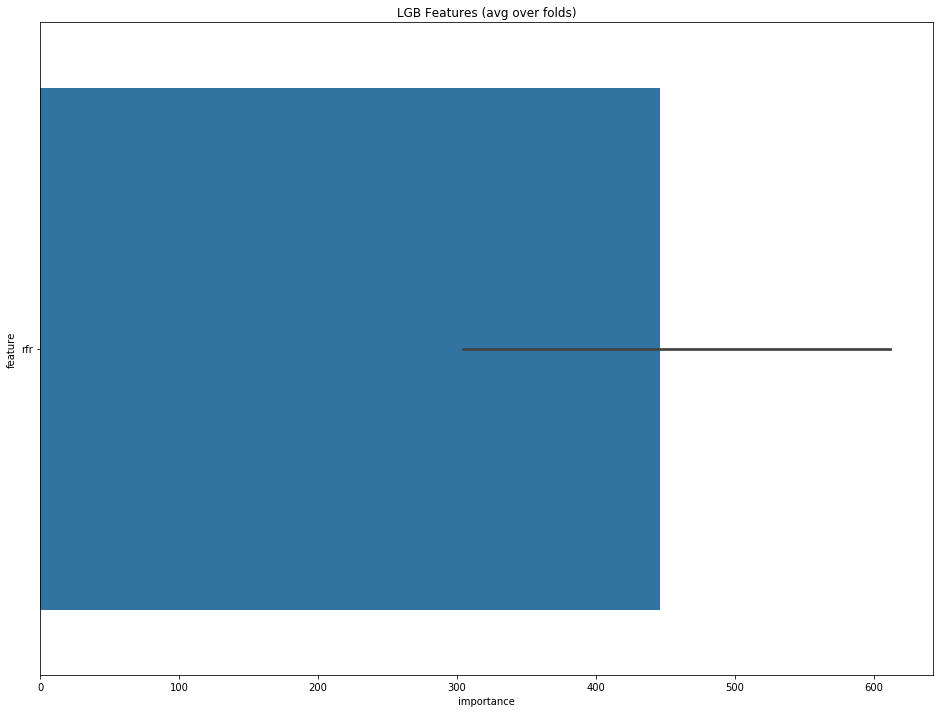

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:35:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.8125	valid_1's rmse: 2.48468
Early stopping, best iteration is:
[1440]	training's rmse: 2.7976	valid_1's rmse: 2.47408
Fold 1 started at Tue Dec 17 12:35:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 2.84946	valid_1's rmse: 2.58489
Fold 2 started at Tue Dec 17 12:35:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 2.95079	valid_1's rmse: 2.87511
Fold 3 started at Tue Dec 17 12:35:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[770]	training's rmse: 2.76331	valid_1's rmse: 3.00917
Fold 4 started at Tue Dec 17 12:35:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's rms

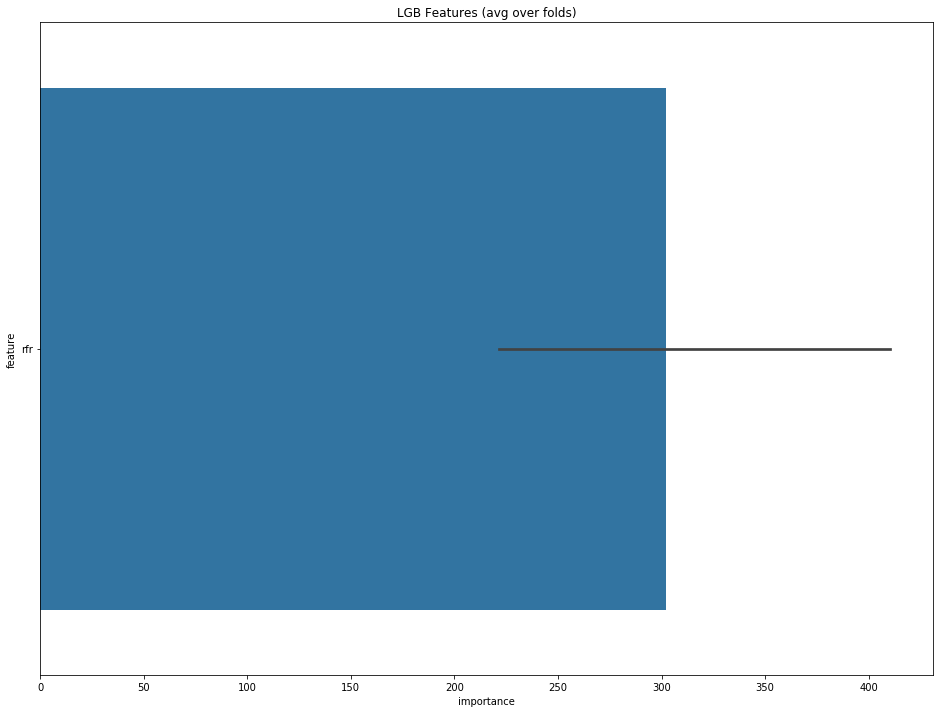

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:35:59 2019
Fold 1 started at Tue Dec 17 12:36:14 2019
Fold 2 started at Tue Dec 17 12:36:26 2019
Fold 3 started at Tue Dec 17 12:36:30 2019
Fold 4 started at Tue Dec 17 12:36:35 2019
Fold 5 started at Tue Dec 17 12:37:05 2019
Fold 6 started at Tue Dec 17 12:37:11 2019
Fold 7 started at Tue Dec 17 12:37:18 2019
Fold 8 started at Tue Dec 17 12:37:22 2019
Fold 9 started at Tue Dec 17 12:37:26 2019
CV mean score: 2.9676, std: 0.5238.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:37:39 2019
Fold 1 started at Tue Dec 17 12:37:39 2019
Fold 2 started at Tue Dec 17 12:37:39 2019
Fold 3 started at Tue Dec 17 12:37:39 2019
Fold 4 started at Tue Dec 17 12:37:40 2019
Fold 5 started at Tue Dec 17 12:37:40 2019
Fold 6 started at Tue Dec 17 12:37:40 2019
Fold 7 started at Tue Dec 17 12:37:40 2019
Fold 8 started at Tue Dec 17 12:37:40 2019
Fold 9 started at Tue Dec 17 12:37:41 2019
CV mean score: 3.1893, std: 0.5089.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:37:41 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1062
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.9069	valid_data-rmse:2.93198
Stopping. Best iteration:
[353]	train-rmse:2.38651	valid_data-rmse:2.76623

Fold 1 started at Tue Dec 17 12:37:41 2019
[0]	train-rmse:24.1979	valid_data-rmse:22.177
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.90801	valid_data-rmse:2.76738
Stopping. Best iteration:
[398]	train-rmse:2.19053	valid_data-rmse:2.74873

Fold 2 started at Tue Dec 17 12:37:41 2019
[0]	train-rmse:24.0124	valid_data-rmse:23.8668
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:37:43 2019
Fold 1 started at Tue Dec 17 12:37:43 2019
Fold 2 started at Tue Dec 17 12:37:43 2019
Fold 3 started at Tue Dec 17 12:37:43 2019
Fold 4 started at Tue Dec 17 12:37:43 2019
Fold 5 started at Tue Dec 17 12:37:43 2019
Fold 6 started at Tue Dec 17 12:37:43 2019
Fold 7 started at Tue Dec 17 12:37:43 2019
Fold 8 started at Tue Dec 17 12:37:43 2019
Fold 9 started at Tue Dec 17 12:37:43 2019
CV mean score: 3.4785, std: 0.6999.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:37:43 2019
Fold 1 started at Tue Dec 17 12:37:43 2019
Fold 2 started at Tue Dec 17 12:37:43 2019
Fold 3 started at Tue Dec 17 12:37:44 2019
Fold 4 started at Tue Dec 17 12:37:44 2019
Fold 5 started at Tue Dec 17 12:37:44 2019
Fold 6 started at Tue Dec 17 12:37:44 2019
Fold 7 started at Tue Dec 17 12:37:44 2019
Fold 8 started at Tue Dec 17 12:37:44 2019
Fold 9 started at Tue Dec 17 12:37:44 2019
CV mean score: 2.9482, std: 0.5487.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:37:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[27]	training's rmse: 7.68215	valid_1's rmse: 7.70966
Fold 1 started at Tue Dec 17 12:37:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 7.91942	valid_1's rmse: 6.56792
Fold 2 started at Tue Dec 17 12:37:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 7.82289	valid_1's rmse: 7.48229
Fold 3 started at Tue Dec 17 12:37:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[9]	training's rmse: 7.76743	valid_1's rmse: 7.6348
Fold 4 started at Tue Dec 17 12:37:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 7.75768	valid_1's rmse: 8.08485
Fold 5 started at Tue Dec 17 1

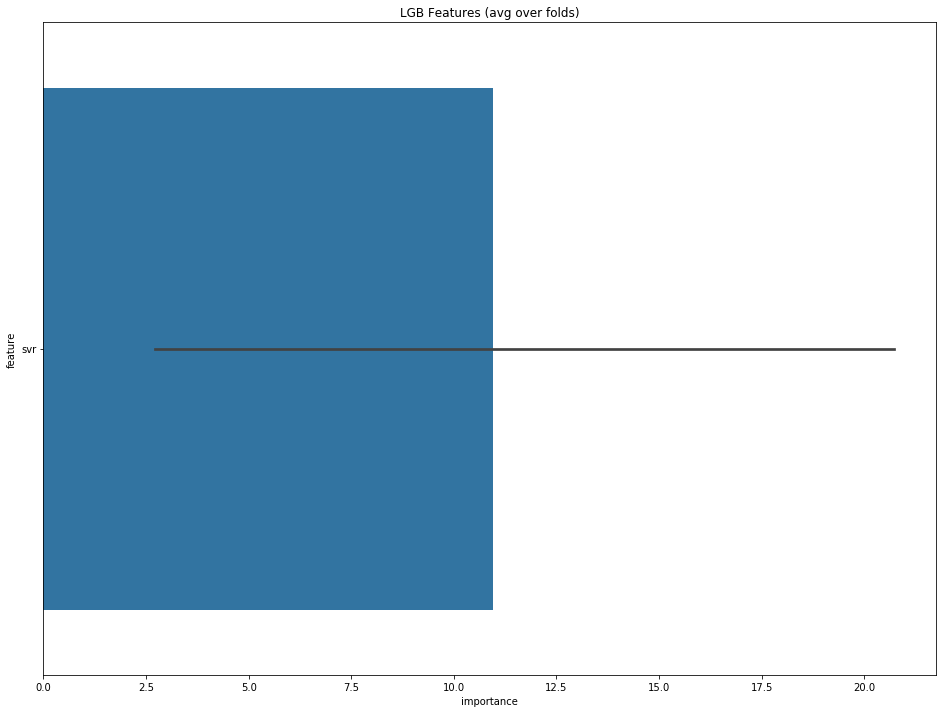

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:37:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[384]	training's rmse: 7.32591	valid_1's rmse: 7.70312
Fold 1 started at Tue Dec 17 12:37:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 7.92157	valid_1's rmse: 6.56834
Fold 2 started at Tue Dec 17 12:37:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 7.82623	valid_1's rmse: 7.48229
Fold 3 started at Tue Dec 17 12:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[57]	training's rmse: 7.70777	valid_1's rmse: 7.60883
Fold 4 started at Tue Dec 17 12:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	training's rmse: 7.70532	valid_1's rmse: 8.07971
Fold 5 started at Tue Dec 

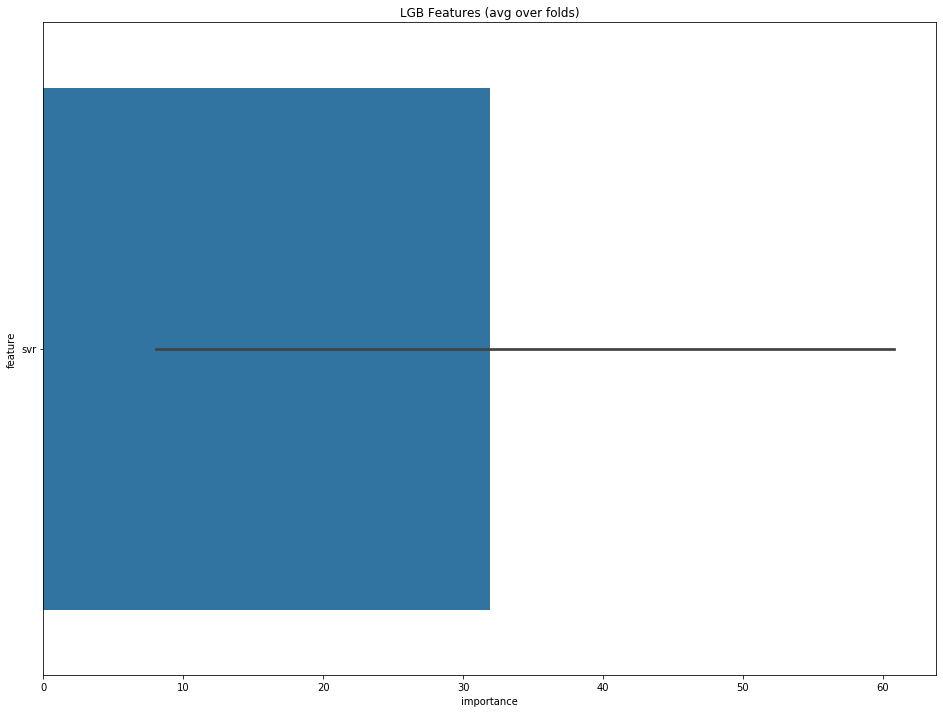

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:37:55 2019
Fold 1 started at Tue Dec 17 12:37:55 2019
Fold 2 started at Tue Dec 17 12:37:56 2019
Fold 3 started at Tue Dec 17 12:38:06 2019
Fold 4 started at Tue Dec 17 12:38:13 2019
Fold 5 started at Tue Dec 17 12:38:15 2019
Fold 6 started at Tue Dec 17 12:38:21 2019
Fold 7 started at Tue Dec 17 12:38:25 2019
Fold 8 started at Tue Dec 17 12:38:25 2019
Fold 9 started at Tue Dec 17 12:38:26 2019
CV mean score: 7.5792, std: 0.5590.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:38:26 2019
Fold 1 started at Tue Dec 17 12:38:26 2019
Fold 2 started at Tue Dec 17 12:38:26 2019
Fold 3 started at Tue Dec 17 12:38:26 2019
Fold 4 started at Tue Dec 17 12:38:27 2019
Fold 5 started at Tue Dec 17 12:38:27 2019
Fold 6 started at Tue Dec 17 12:38:27 2019
Fold 7 started at Tue Dec 17 12:38:27 2019
Fold 8 started at Tue Dec 17 12:38:28 2019
Fold 9 started at Tue Dec 17 12:38:28 2019
CV mean score: 8.7642, std: 2.1061.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:38:28 2019
[0]	train-rmse:24.0026	valid_data-rmse:24.1378
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[227]	train-rmse:7.35819	valid_data-rmse:7.69887

Fold 1 started at Tue Dec 17 12:38:28 2019
[0]	train-rmse:24.215	valid_data-rmse:22.172
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:6.54214	valid_data-rmse:8.05852
Stopping. Best iteration:
[301]	train-rmse:6.91609	valid_data-rmse:7.84307

Fold 2 started at Tue Dec 17 12:38:28 2019
[0]	train-rmse:24.0281	valid_data-rmse:23.8856
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:6.57066	valid_data-rmse:7.22059
Stopping. Best

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:38:30 2019
Fold 1 started at Tue Dec 17 12:38:30 2019
Fold 2 started at Tue Dec 17 12:38:30 2019
Fold 3 started at Tue Dec 17 12:38:30 2019
Fold 4 started at Tue Dec 17 12:38:30 2019
Fold 5 started at Tue Dec 17 12:38:30 2019
Fold 6 started at Tue Dec 17 12:38:30 2019
Fold 7 started at Tue Dec 17 12:38:30 2019
Fold 8 started at Tue Dec 17 12:38:30 2019
Fold 9 started at Tue Dec 17 12:38:30 2019
CV mean score: 7.7391, std: 0.6750.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:38:30 2019
Fold 1 started at Tue Dec 17 12:38:30 2019
Fold 2 started at Tue Dec 17 12:38:31 2019
Fold 3 started at Tue Dec 17 12:38:31 2019
Fold 4 started at Tue Dec 17 12:38:31 2019
Fold 5 started at Tue Dec 17 12:38:31 2019
Fold 6 started at Tue Dec 17 12:38:31 2019
Fold 7 started at Tue Dec 17 12:38:31 2019
Fold 8 started at Tue Dec 17 12:38:31 2019
Fold 9 started at Tue Dec 17 12:38:31 2019
CV mean score: 7.8596, std: 0.6547.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:38:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[469]	training's rmse: 2.58137	valid_1's rmse: 2.32955
Fold 1 started at Tue Dec 17 12:38:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 2.6562	valid_1's rmse: 2.27073
Fold 2 started at Tue Dec 17 12:38:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.67528	valid_1's rmse: 2.7953
Fold 3 started at Tue Dec 17 12:38:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[457]	training's rmse: 2.59999	valid_1's rmse: 2.32972
Fold 4 started at Tue Dec 17 12:38:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 2.50791	valid_1's rmse: 4.00553
Fold 5 started at Tue 

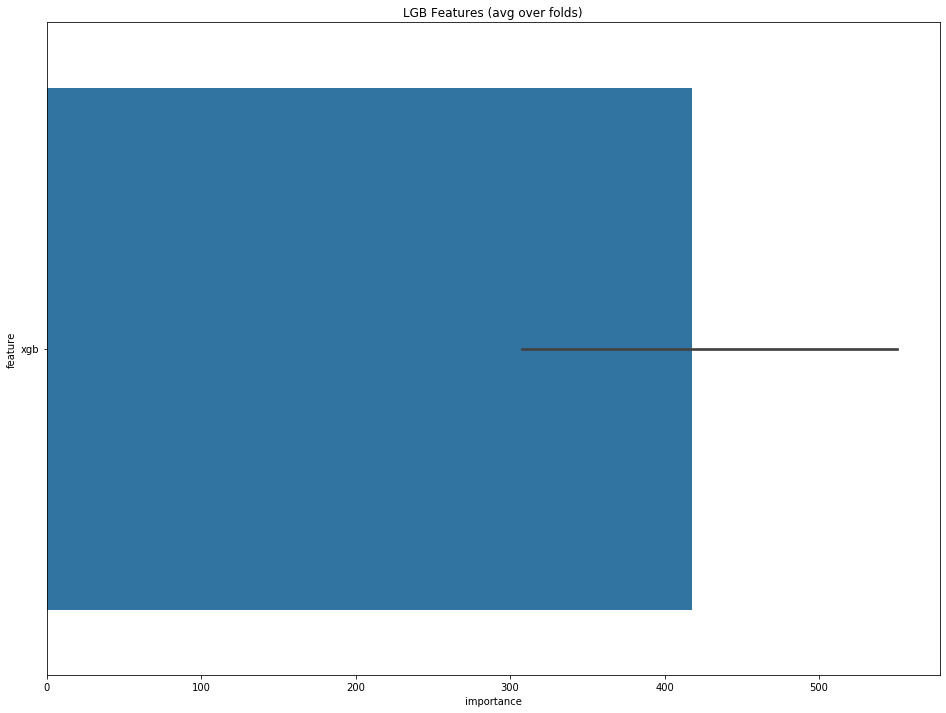

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:38:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[556]	training's rmse: 2.60679	valid_1's rmse: 2.3084
Fold 1 started at Tue Dec 17 12:38:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 2.66242	valid_1's rmse: 2.28106
Fold 2 started at Tue Dec 17 12:38:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 2.66698	valid_1's rmse: 2.79749
Fold 3 started at Tue Dec 17 12:38:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.6271	valid_1's rmse: 2.32025
Fold 4 started at Tue Dec 17 12:38:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 2.48369	valid_1's rmse: 3.9947
Fold 5 started at Tue D

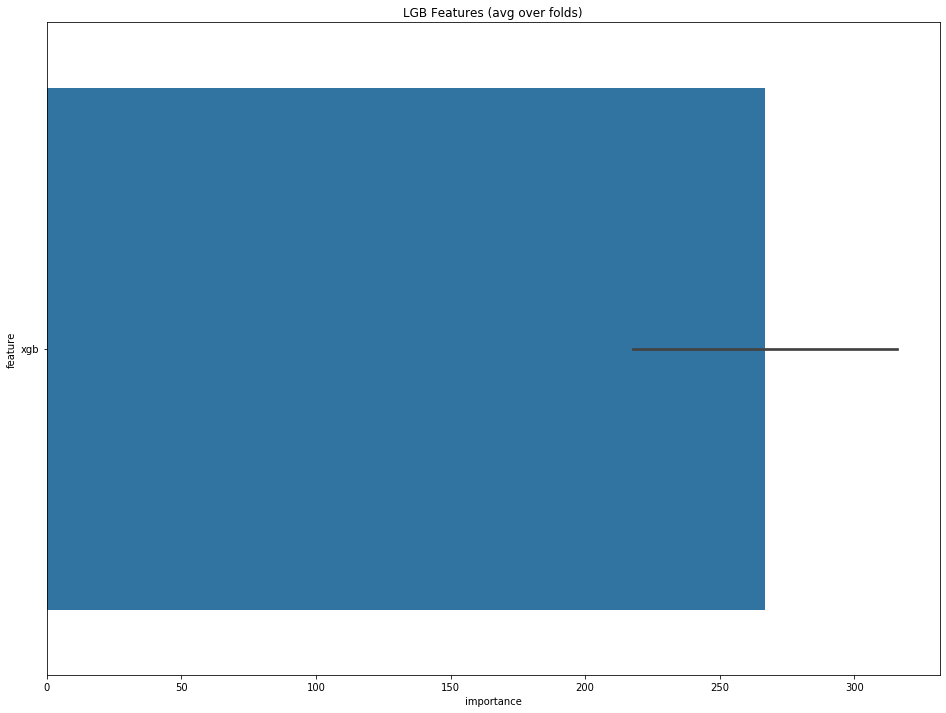

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:39:10 2019
Fold 1 started at Tue Dec 17 12:39:23 2019
Fold 2 started at Tue Dec 17 12:39:30 2019
Fold 3 started at Tue Dec 17 12:39:34 2019
Fold 4 started at Tue Dec 17 12:39:48 2019
Fold 5 started at Tue Dec 17 12:39:54 2019
Fold 6 started at Tue Dec 17 12:40:02 2019
Fold 7 started at Tue Dec 17 12:40:34 2019
Fold 8 started at Tue Dec 17 12:40:39 2019
Fold 9 started at Tue Dec 17 12:40:42 2019
CV mean score: 2.6928, std: 0.5529.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:40:47 2019
Fold 1 started at Tue Dec 17 12:40:47 2019
Fold 2 started at Tue Dec 17 12:40:47 2019
Fold 3 started at Tue Dec 17 12:40:47 2019
Fold 4 started at Tue Dec 17 12:40:48 2019
Fold 5 started at Tue Dec 17 12:40:48 2019
Fold 6 started at Tue Dec 17 12:40:48 2019
Fold 7 started at Tue Dec 17 12:40:48 2019
Fold 8 started at Tue Dec 17 12:40:49 2019
Fold 9 started at Tue Dec 17 12:40:49 2019
CV mean score: 2.8880, std: 0.5429.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:40:49 2019
[0]	train-rmse:23.9862	valid_data-rmse:24.1083
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.82828	valid_data-rmse:2.76039
Stopping. Best iteration:
[356]	train-rmse:2.25949	valid_data-rmse:2.64327

Fold 1 started at Tue Dec 17 12:40:49 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.77296	valid_data-rmse:2.4611
Stopping. Best iteration:
[361]	train-rmse:2.18917	valid_data-rmse:2.37992

Fold 2 started at Tue Dec 17 12:40:50 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:40:51 2019
Fold 1 started at Tue Dec 17 12:40:51 2019
Fold 2 started at Tue Dec 17 12:40:51 2019
Fold 3 started at Tue Dec 17 12:40:51 2019
Fold 4 started at Tue Dec 17 12:40:51 2019
Fold 5 started at Tue Dec 17 12:40:51 2019
Fold 6 started at Tue Dec 17 12:40:51 2019
Fold 7 started at Tue Dec 17 12:40:51 2019
Fold 8 started at Tue Dec 17 12:40:51 2019
Fold 9 started at Tue Dec 17 12:40:51 2019
CV mean score: 3.3915, std: 0.8141.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:40:51 2019
Fold 1 started at Tue Dec 17 12:40:52 2019
Fold 2 started at Tue Dec 17 12:40:52 2019
Fold 3 started at Tue Dec 17 12:40:52 2019
Fold 4 started at Tue Dec 17 12:40:52 2019
Fold 5 started at Tue Dec 17 12:40:52 2019
Fold 6 started at Tue Dec 17 12:40:52 2019
Fold 7 started at Tue Dec 17 12:40:52 2019
Fold 8 started at Tue Dec 17 12:40:52 2019
Fold 9 started at Tue Dec 17 12:40:52 2019
CV mean score: 2.6476, std: 0.4966.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:40:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[462]	training's rmse: 2.51376	valid_1's rmse: 2.21793
Fold 1 started at Tue Dec 17 12:40:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[215]	training's rmse: 2.6947	valid_1's rmse: 2.60341
Fold 2 started at Tue Dec 17 12:40:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.60111	valid_1's rmse: 2.91462
Fold 3 started at Tue Dec 17 12:40:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.45387	valid_1's rmse: 2.76356
Fold 4 started at Tue Dec 17 12:40:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 2.32681	valid_1's rmse: 3.92433
Fold 5 started at Tue

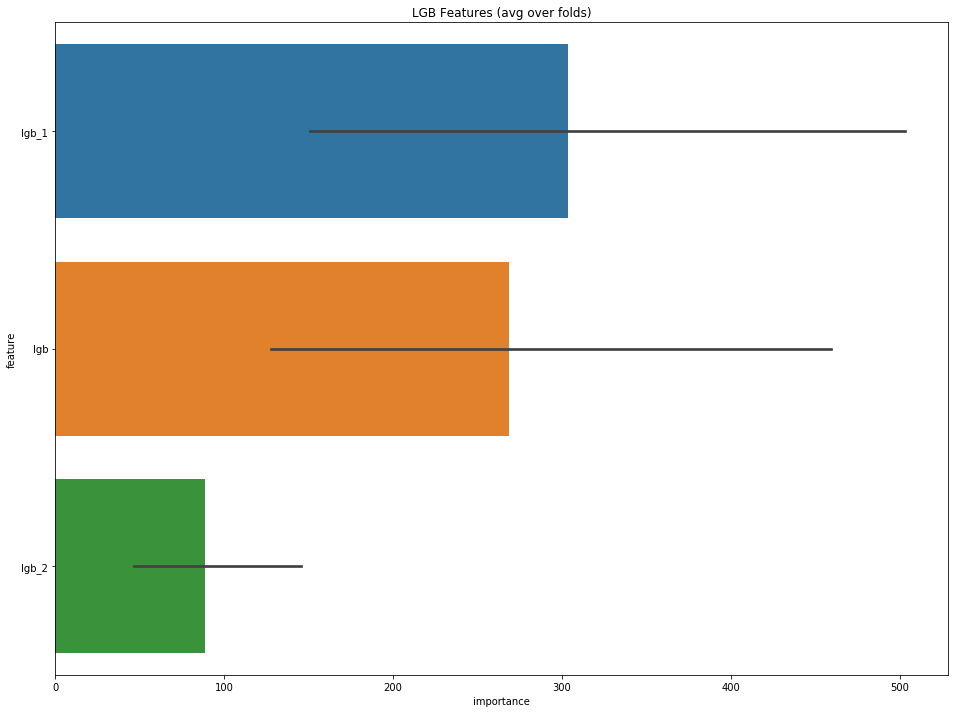

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:41:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[759]	training's rmse: 2.50454	valid_1's rmse: 2.20403
Fold 1 started at Tue Dec 17 12:41:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 2.61633	valid_1's rmse: 2.6123
Fold 2 started at Tue Dec 17 12:41:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.61032	valid_1's rmse: 2.92237
Fold 3 started at Tue Dec 17 12:41:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.43021	valid_1's rmse: 2.76772
Early stopping, best iteration is:
[914]	training's rmse: 2.438	valid_1's rmse: 2.76644
Fold 4 started at Tue Dec 17 12:41:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse:

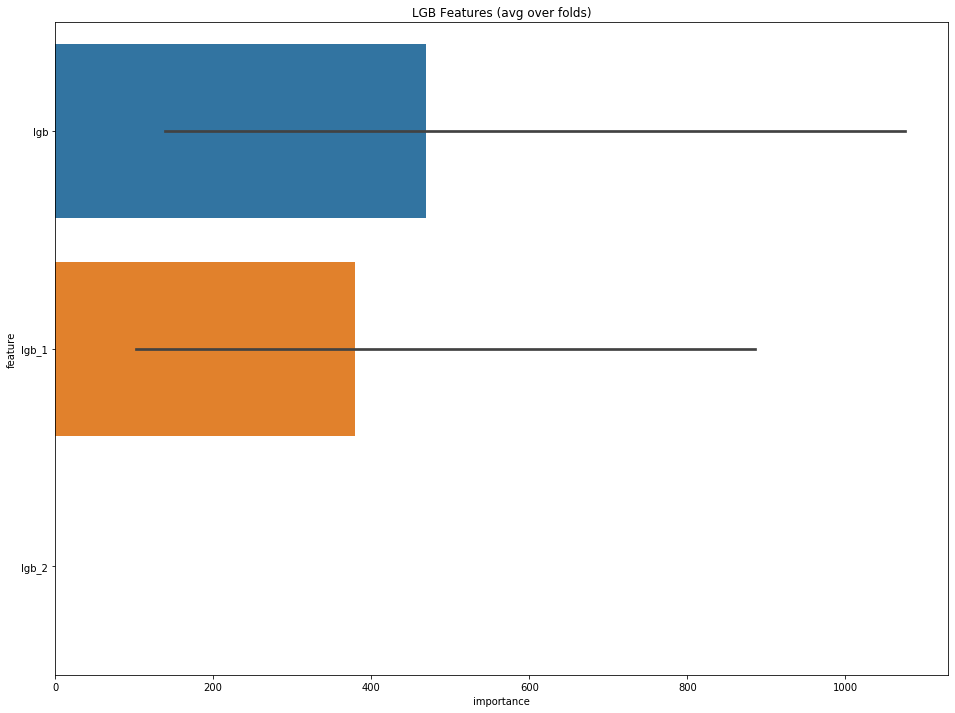

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:41:29 2019
Fold 1 started at Tue Dec 17 12:41:46 2019
Fold 2 started at Tue Dec 17 12:41:50 2019
Fold 3 started at Tue Dec 17 12:41:53 2019
Fold 4 started at Tue Dec 17 12:41:56 2019
Fold 5 started at Tue Dec 17 12:42:06 2019
Fold 6 started at Tue Dec 17 12:42:43 2019
Fold 7 started at Tue Dec 17 12:42:52 2019
Fold 8 started at Tue Dec 17 12:42:58 2019
Fold 9 started at Tue Dec 17 12:43:09 2019
CV mean score: 2.6093, std: 0.4719.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:43:15 2019
Fold 1 started at Tue Dec 17 12:43:15 2019
Fold 2 started at Tue Dec 17 12:43:15 2019
Fold 3 started at Tue Dec 17 12:43:15 2019
Fold 4 started at Tue Dec 17 12:43:16 2019
Fold 5 started at Tue Dec 17 12:43:16 2019
Fold 6 started at Tue Dec 17 12:43:16 2019
Fold 7 started at Tue Dec 17 12:43:16 2019
Fold 8 started at Tue Dec 17 12:43:17 2019
Fold 9 started at Tue Dec 17 12:43:17 2019
CV mean score: 2.8462, std: 0.5025.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:43:17 2019
[0]	train-rmse:23.9863	valid_data-rmse:24.1108
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.59889	valid_data-rmse:2.07428
Stopping. Best iteration:
[479]	train-rmse:1.64806	valid_data-rmse:2.07356

Fold 1 started at Tue Dec 17 12:43:17 2019
[0]	train-rmse:24.1981	valid_data-rmse:22.1723
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.56509	valid_data-rmse:2.80539
Stopping. Best iteration:
[381]	train-rmse:1.92934	valid_data-rmse:2.70427

Fold 2 started at Tue Dec 17 12:43:18 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:43:20 2019
Fold 1 started at Tue Dec 17 12:43:20 2019
Fold 2 started at Tue Dec 17 12:43:20 2019
Fold 3 started at Tue Dec 17 12:43:20 2019
Fold 4 started at Tue Dec 17 12:43:20 2019
Fold 5 started at Tue Dec 17 12:43:20 2019
Fold 6 started at Tue Dec 17 12:43:20 2019
Fold 7 started at Tue Dec 17 12:43:20 2019
Fold 8 started at Tue Dec 17 12:43:20 2019
Fold 9 started at Tue Dec 17 12:43:20 2019
CV mean score: 3.4430, std: 0.7155.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:43:20 2019
Fold 1 started at Tue Dec 17 12:43:20 2019
Fold 2 started at Tue Dec 17 12:43:20 2019
Fold 3 started at Tue Dec 17 12:43:20 2019
Fold 4 started at Tue Dec 17 12:43:20 2019
Fold 5 started at Tue Dec 17 12:43:20 2019
Fold 6 started at Tue Dec 17 12:43:21 2019
Fold 7 started at Tue Dec 17 12:43:21 2019
Fold 8 started at Tue Dec 17 12:43:21 2019
Fold 9 started at Tue Dec 17 12:43:21 2019
CV mean score: 2.6599, std: 0.4709.


In [261]:
print(scorelist)

[7.809950303954757, 2.6367757522537607, 2.64805230656749, 2.64805230656749, 2.938123193062133, 2.647488249634088, 2.6263728408392386, 2.7021090573330904, 2.693710708148506, 2.6857567637136777, 2.780705530255989, 2.8326469800409066, 3.781027300872354, 2.5998981973105026, 2.7804647726678047, 2.7646298236180527, 2.7174157308462705, 2.984128033759144, 2.966137433110078, 3.6494277534825885, 2.601851091265849, 2.6993400553768048, 2.68158998782105, 2.680184832622415, 2.8960122337769314, 2.7872811438725416, 3.7002157251632384, 2.6209198381972816, 2.687909674485703, 2.6785253336299317, 2.6701409863596863, 2.746013708795863, 2.775511485919819, 3.878309637551788, 2.6032100244931504, 2.695787718494926, 2.689463107029075, 2.668723460351396, 2.7694615374050047, 2.783378105189204, 3.628539415125416, 2.5953355286592434, 2.74045968650807, 2.7391313999543816, 2.6804009614756636, 2.905925689079612, 2.8541718447444806, 3.7697207565988684, 2.629141778720828, 2.840847058724057, 2.821199315648676, 2.75140962

In [262]:
min(scorelist)

2.5874649436366814

In [263]:
scorelist[0:7]

[7.809950303954757,
 2.6367757522537607,
 2.64805230656749,
 2.64805230656749,
 2.938123193062133,
 2.647488249634088,
 2.6263728408392386]